# H&M Capstone 3 project - Preprocessing and Modeling

## The business problem is classifying new products into an existing taxonomy of product categories for online retail stores such as H&M

### Product category is the variable we want to predict

- Features include product title, product description, one product image per row
- Each product has a unique article ID which is set as the index of the dataframe

In the previous notebook, data wrangling and exploratory data analysis was done 
The major product categories we would like to predict have been chosen. 
A key issue with keeping color variants of products is that these products are very similar to each other, and we want to keep them together and not have them assigned to both training and testing data. To deal with this issue, some preprocessing is done to treat the color variants as a single product, and by extension recompute the imbalanced class of products belonging to each product category.


### This notebook covers the scope of preprocessing and modeling 
1. Removing duplicate image embeddings
2. Train test split using GroupShuffleSplit (30% testing)
3. Create a Bag of words with tokenization of the product title and product description
    - Strip punctuation
    - Create tokens using tokenization
    - Count the number of tokens (take out stopwords)
4. Machine Learning Models with performance metrics
    - Stochastic Gradient Descent Classifier with Elastic Net
    - Random Forest Classifier
    - KNN 
5. Results and interpretation
    - Model metrics and results

## Imports

In [75]:
#!pip install jupyter-resource-usage

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
import xgboost as xgb

import base64
from PIL import Image
from io import BytesIO
from IPython.core.display import HTML

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/pandabear/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pandabear/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
MAX_DICT_SIZE = 100
# Use all rows in NUM_ROWS is None
NUM_ROWS = None

## Load the data


In [79]:
df_h_and_m = pd.read_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/data/interim/H_and_M_dataset.csv', index_col='article_id')
if NUM_ROWS:
    df = df_h_and_m[:NUM_ROWS]
else:
    df = df_h_and_m

In [80]:
df.head()

product_code          prod_name  product_type_no  \
article_id                                                     
108775015   108775        Strap top          253               
108775044   108775        Strap top          253               
108775051   108775        Strap top (1)      253               
110065001   110065        OP T-shirt (Idro)  306               
110065002   110065        OP T-shirt (Idro)  306               

                product_type_name  product_group_name  \
article_id                                              
108775015   Sweater/Cardigan/Vest  Garment Upper body   
108775044   Sweater/Cardigan/Vest  Garment Upper body   
108775051   Sweater/Cardigan/Vest  Garment Upper body   
110065001   Underwear/PJs          Underwear            
110065002   Underwear/PJs          Underwear            

            graphical_appearance_no graphical_appearance_name  \
article_id                                                      
108775015   1010016                  Solid                      
108775044   1010016                  Solid                      
108775051   1010017                  Stripe                     
110065001   1010016                  Solid                      
110065002   1010016                  Solid                      

            colour_group_code colour_group_name  perceived_colour_value_id  \
article_id                                                                   
108775015   9                  Black             4                           
108775044   10                 White             3                           
108775051   11                 Off White         1                           
110065001   9                  Black             4                           
110065002   10                 White             3                           

            ...       502       503       504       505       506       507  \
article_id  ...                                                               
108775015   ...  0.283601  0.502333  0.815049  0.183200  1.749047  1.393814   
108775044   ...  0.369955  0.305547  0.750164  0.278698  3.498078  1.059729   
108775051   ...  0.673954  1.023912  1.220658  0.990421  0.603554  1.449252   
110065001   ...  0.443555  2.535063  0.854901  0.170298  0.000000  5.164192   
110065002   ...  1.739273  1.536174  0.807216  0.026798  0.012599  3.243781   

                 508       509       510       511  
article_id                                          
108775015   0.003090  3.470509  0.953905  1.414786  
108775044   0.080655  0.457405  0.473151  1.298293  
108775051   0.105316  2.191562  2.410787  0.329729  
110065001   2.344141  1.108159  0.782095  0.245456  
110065002   1.929202  0.880281  2.152518  1.053739  

[5 rows x 537 columns]

In [82]:
print(f'df size: {df.shape}')

df size: (99332, 537)


In [83]:
df.columns

Index(['product_code', 'prod_name', 'product_type_no', 'product_type_name',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=537)

In [84]:
# Drop unused columns
#'product_code'
cols_to_drop = ['product_type_no',
       'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name','perceived_colour_master_id',
               'perceived_colour_master_name','department_no','department_name','index_code','index_name',
                'index_group_no','index_group_name','section_no','section_name','garment_group_no','garment_group_name']
df.drop(cols_to_drop, axis=1, inplace=True)

In [85]:
df.head()

product_code          prod_name      product_type_name  \
article_id                                                           
108775015   108775        Strap top          Sweater/Cardigan/Vest   
108775044   108775        Strap top          Sweater/Cardigan/Vest   
108775051   108775        Strap top (1)      Sweater/Cardigan/Vest   
110065001   110065        OP T-shirt (Idro)  Underwear/PJs           
110065002   110065        OP T-shirt (Idro)  Underwear/PJs           

                                                                                                                                                                                                                                                 detail_desc  \
article_id                                                                                                                                                                                                                                                     
108775015   Jersey top with narrow shoulder straps.                                                                                                                                                                                                            
108775044   Jersey top with narrow shoulder straps.                                                                                                                                                                                                            
108775051   Jersey top with narrow shoulder straps.                                                                                                                                                                                                            
110065001   Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.   
110065002   Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.   

                          product_title         0         1         2  \
article_id                                                              
108775015   ['strap', 'top']             1.671856  0.076411  1.992960   
108775044   ['strap', 'top']             0.317337  0.022370  0.790894   
108775051   ['strap', 'top', '(1)']      0.972625  0.119625  2.423473   
110065001   ['op', 't-shirt', '(idro)']  0.715175  0.000000  1.995459   
110065002   ['op', 't-shirt', '(idro)']  1.627883  0.009426  0.193758   

                   3         4  ...       502       503       504       505  \
article_id                      ...                                           
108775015   0.515366  0.087093  ...  0.283601  0.502333  0.815049  0.183200   
108775044   0.184620  0.122858  ...  0.369955  0.305547  0.750164  0.278698   
108775051   1.054603  0.002196  ...  0.673954  1.023912  1.220658  0.990421   
110065001   0.098002  0.026993  ...  0.443555  2.535063  0.854901  0.170298   
110065002   1.295485  0.028507  ...  1.739273  1.536174  0.807216  0.026798   

                 506       507       508       509       510       511  
article_id                                                              
108775015   1.749047  1.393814  0.003090  3.470509  0.953905  1.414786  
108775044   3.498078  1.059729  0.080655  0.457405  0.473151  1.298293  
108775051   0.603554  1.449252  0.105316  2.191562  2.410787  0.329729  
110065001   0.000000  5.164192  2.344141  1.108159  0.782095  0.245456  
110065002   0.012599  3.243781  1.929202  0.880281  2.152518  1.053739  

[5 rows x 517 columns]

In [86]:
df.isna().sum()

product_code         0  
prod_name            0  
product_type_name    0  
detail_desc          369
product_title        0  
                    ..  
507                  0  
508                  0  
509                  0  
510                  0  
511                  0  
Length: 517, dtype: int64

Since the only column missing information is the product description, this is ok to keep.

In [87]:
# Convert the product description null values to empty strings
df['detail_desc'].fillna('',inplace=True)

In [88]:
df.isna().sum()

product_code         0
prod_name            0
product_type_name    0
detail_desc          0
product_title        0
                    ..
507                  0
508                  0
509                  0
510                  0
511                  0
Length: 517, dtype: int64

## Relabel misclassified product categories
After running the analysis, it is clear some product category labels are incorrect in the dataset and should be corrected. Classes jumpsuits were frequently labeled as trousers, and shorts as trousers


In [89]:
relabel = pd.read_csv('/Users/pandabear/springboard/H_and_M_product_category_classification/models/Relabel.csv', header=None)
relabel.columns = ['article_id','product_label']


In [90]:
df.loc[800537001]['product_type_name']

'Dress'

In [91]:
relabel_list = relabel.to_dict(orient='split')['data']
for row in relabel_list:
    df.loc[row[0],'product_type_name'] = row[1]

In [93]:
df.loc[800537001]['product_type_name']

'Sweater/Cardigan/Vest'

In [94]:
df['product_type_name'].unique()

array(['Sweater/Cardigan/Vest', 'Underwear/PJs', 'Socks/Tights', 'Top',
       'Trousers', 'Bodysuit', 'Outerwear', 'Accessories', 'Shoes',
       'Swimwear', 'Skirt', 'T-shirt', 'Dress', 'Hat', 'Shorts',
       'Jewelry', 'Bag', 'Full length'], dtype=object)

## 1. Check the number of duplicates for image embeddings
In the data wrangling stage we checked for exact duplicates, but this check is to see if there are images that are the same but have slightly different product titles/descriptions.

In [95]:
image_cols = [str(num) for num in range(512)]
image_embeddings = df[image_cols]
duplicate_images = image_embeddings[image_embeddings.duplicated(keep=False) == True].sort_values(by='0')
print(f'There are a total of {duplicate_images.shape[0]} rows')
duplicate_images.head()

There are a total of 397 rows


0         1         2         3         4         5  \
article_id                                                               
631450001   0.000000  0.718425  0.499194  3.073000  0.268538  0.143195   
661686001   0.000000  0.718425  0.499194  3.073000  0.268538  0.143195   
722475006   0.011881  0.018850  0.211799  0.402413  0.452787  0.771340   
781758005   0.011881  0.018850  0.211799  0.402413  0.452787  0.771340   
879086001   0.024319  0.031018  1.041525  1.254949  0.495849  0.010483   

                   6         7         8         9  ...       502       503  \
article_id                                          ...                       
631450001   1.224393  1.212663  0.867520  2.828853  ...  2.458086  2.350473   
661686001   1.224393  1.212663  0.867520  2.828853  ...  2.458086  2.350473   
722475006   2.329740  0.108756  0.435526  0.403535  ...  2.118542  0.241202   
781758005   2.329740  0.108756  0.435526  0.403535  ...  2.118542  0.241202   
879086001   0.381270  1.058385  0.000000  0.584427  ...  1.940401  0.010902   

                 504       505       506       507       508       509  \
article_id                                                               
631450001   0.606510  0.488055  0.281623  0.522974  4.141664  0.633914   
661686001   0.606510  0.488055  0.281623  0.522974  4.141664  0.633914   
722475006   1.065701  0.674406  3.149235  0.872026  1.138089  0.835722   
781758005   1.065701  0.674406  3.149235  0.872026  1.138089  0.835722   
879086001   0.596070  0.006220  0.011655  0.327071  0.012588  0.685774   

                 510       511  
article_id                      
631450001   1.004539  0.687645  
661686001   1.004539  0.687645  
722475006   0.290696  1.262451  
781758005   0.290696  1.262451  
879086001   1.458734  6.389759  

[5 rows x 512 columns]

In [96]:
df.loc[631450001]

product_code         631450                                                                                                                                                                                         
prod_name            Jarl Dress                                                                                                                                                                                     
product_type_name    Dress                                                                                                                                                                                          
detail_desc          Sleeveless, A-line dress in airy, patterned chiffon with narrow, braided shoulder straps and a braided trim around the neckline and armholes. The dress lining is made from recycled polyester.
product_title        ['jarl', 'dress']                                                                                                              

In [97]:
df.loc[661686001]

product_code         661686                                                                                                                                                                                         
prod_name            ES JARL DRESS                                                                                                                                                                                  
product_type_name    Dress                                                                                                                                                                                          
detail_desc          Sleeveless, A-line dress in airy, patterned chiffon with narrow, braided shoulder straps and a braided trim around the neckline and armholes. The dress lining is made from recycled polyester.
product_title        ['es', 'jarl', 'dress']                                                                                                        

Looking at these shows they are the same product with the same product description and image. Remove these duplicates from the dataset. 

In [98]:
df.drop(duplicate_images.index, inplace=True)

In [99]:
df.shape

(98935, 517)

In [100]:
# Separate out the product class from the product title and product description
y = df['product_type_name']
X = df

In [101]:
y

article_id
108775015    Sweater/Cardigan/Vest
108775044    Sweater/Cardigan/Vest
108775051    Sweater/Cardigan/Vest
110065001    Underwear/PJs        
110065002    Underwear/PJs        
                 ...              
952938001    Top                  
953450001    Socks/Tights         
953763001    Sweater/Cardigan/Vest
956217002    Dress                
959461001    Dress                
Name: product_type_name, Length: 98935, dtype: object

In [102]:
product_cat = list(y.unique())
len(product_cat)

18

In [103]:
X.head()

product_code          prod_name      product_type_name  \
article_id                                                           
108775015   108775        Strap top          Sweater/Cardigan/Vest   
108775044   108775        Strap top          Sweater/Cardigan/Vest   
108775051   108775        Strap top (1)      Sweater/Cardigan/Vest   
110065001   110065        OP T-shirt (Idro)  Underwear/PJs           
110065002   110065        OP T-shirt (Idro)  Underwear/PJs           

                                                                                                                                                                                                                                                 detail_desc  \
article_id                                                                                                                                                                                                                                                     
108775015   Jersey top with narrow shoulder straps.                                                                                                                                                                                                            
108775044   Jersey top with narrow shoulder straps.                                                                                                                                                                                                            
108775051   Jersey top with narrow shoulder straps.                                                                                                                                                                                                            
110065001   Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.   
110065002   Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.   

                          product_title         0         1         2  \
article_id                                                              
108775015   ['strap', 'top']             1.671856  0.076411  1.992960   
108775044   ['strap', 'top']             0.317337  0.022370  0.790894   
108775051   ['strap', 'top', '(1)']      0.972625  0.119625  2.423473   
110065001   ['op', 't-shirt', '(idro)']  0.715175  0.000000  1.995459   
110065002   ['op', 't-shirt', '(idro)']  1.627883  0.009426  0.193758   

                   3         4  ...       502       503       504       505  \
article_id                      ...                                           
108775015   0.515366  0.087093  ...  0.283601  0.502333  0.815049  0.183200   
108775044   0.184620  0.122858  ...  0.369955  0.305547  0.750164  0.278698   
108775051   1.054603  0.002196  ...  0.673954  1.023912  1.220658  0.990421   
110065001   0.098002  0.026993  ...  0.443555  2.535063  0.854901  0.170298   
110065002   1.295485  0.028507  ...  1.739273  1.536174  0.807216  0.026798   

                 506       507       508       509       510       511  
article_id                                                              
108775015   1.749047  1.393814  0.003090  3.470509  0.953905  1.414786  
108775044   3.498078  1.059729  0.080655  0.457405  0.473151  1.298293  
108775051   0.603554  1.449252  0.105316  2.191562  2.410787  0.329729  
110065001   0.000000  5.164192  2.344141  1.108159  0.782095  0.245456  
110065002   0.012599  3.243781  1.929202  0.880281  2.152518  1.053739  

[5 rows x 517 columns]

## 2. Train test split using `GroupShuffleSplit`
In order to stratify the training and testing groups to keep the class distributions, iterate through each major category and perform the train test split before combining together at the end. 

In [104]:
major_categories = list(y.unique())
len(major_categories)

18

In [105]:
X[X['product_type_name'] == 'Trousers']

product_code                  prod_name product_type_name  \
article_id                                                              
118458003   118458        Jerry jogger bottoms       Trousers           
118458004   118458        Jerry jogger bottoms       Trousers           
118458028   118458        Jerry jogger bottoms       Trousers           
118458029   118458        Jerry jogger bottoms       Trousers           
118458034   118458        Jerry jogger bottoms       Trousers           
...            ...                         ...            ...           
939549002   939549        Bug sweatpants             Trousers           
939549003   939549        Bug sweatpants             Trousers           
943097001   943097        Sandra HW Wide Trousers 1  Trousers           
949198001   949198        Saturday jogger            Trousers           
949594001   949594        LOGG Elvis jogger.         Trousers           

                                                                                                                                                                                                             detail_desc  \
article_id                                                                                                                                                                                                                 
118458003   Trousers in sweatshirt fabric with an elasticated drawstring waist, side pockets, a back pocket and ribbed hems. Soft brushed inside.                                                                          
118458004   Trousers in sweatshirt fabric with an elasticated drawstring waist, side pockets, a back pocket and ribbed hems. Soft brushed inside.                                                                          
118458028   Trousers in sweatshirt fabric with an elasticated drawstring waist, side pockets, a back pocket and ribbed hems. Soft brushed inside.                                                                          
118458029   Trousers in sweatshirt fabric with an elasticated drawstring waist, side pockets, a back pocket and ribbed hems. Soft brushed inside.                                                                          
118458034   Trousers in sweatshirt fabric with an elasticated drawstring waist, side pockets, a back pocket and ribbed hems. Soft brushed inside.                                                                          
...                                                                                                                                           ...                                                                          
939549002   Trousers in organic cotton sweatshirt fabric. High waist with covered elastication and a drawstring, pockets in the side seams and tapered legs with covered elastication at the hems. Soft brushed inside.    
939549003   Trousers in organic cotton sweatshirt fabric. High waist with covered elastication and a drawstring, pockets in the side seams and tapered legs with covered elastication at the hems. Soft brushed inside.    
943097001   High-waisted trousers in a linen and cotton weave with a zip fly and button, side and back pockets and extra-long, wide, straight legs with sewn-in creases at the front.                                      
949198001   Joggers in sweatshirt fabric made from a cotton blend with an elasticated, drawstring waist, discreet side pockets and straight legs. Soft brushed inside. The polyester content of the joggers is recycled.   
949594001   Joggers in soft sweatshirt fabric with an elasticated, drawstring waist, diagonal side pockets and slim legs with ribbed hems.                                                                                 

                                        product_title         0         1  \
article_id                                                                  
118458003   ['jerry', 'jogger', 'bottoms']     

In [106]:
# Initiate empty X_train, y_train, X_test and y_test dataframes
X_train,  X_test = pd.DataFrame(), pd.DataFrame()
y_train, y_test = list(), list()

# Iterate over each category so the class distribution is maintained (in lieu of stratify which isn't part of GroupShuffleSplit)
for cat in major_categories:
    X_cat = X[X['product_type_name'] == cat]
    y_cat = y[X_cat.index]
    
    # Do the splitting based on the group `product_code` which is the same for color variants
    gs = GroupShuffleSplit(n_splits=1, test_size=.3, random_state=0)
    train_ix, test_ix = next(gs.split(X_cat, y_cat, groups=X_cat.product_code))
        
    # index the dataframe to create the train and test sets 
    X_train_cat = X_cat.iloc[train_ix]
    y_train_cat = y_cat.iloc[train_ix]
    X_test_cat = X_cat.iloc[test_ix]
    y_test_cat = y_cat.iloc[test_ix]
    
    # Concatenate dataframes
    X_train = pd.concat([X_train,X_train_cat], axis=0)
    y_train.extend(y_train_cat)
    X_test = pd.concat([X_test,X_test_cat], axis=0)
    y_test.extend(y_test_cat)
    

### Check class distributions to check imbalanced classes
This should look similar to the bar graph from the EDA notebook

In [107]:
# Represent the product categories as a percentage (don't include color variants) before training/testing split
no_color_variants = X.groupby('product_code').first()
df_size = no_color_variants.shape[0]

original_class_percentages = pd.DataFrame([(x/df_size) * 100.00 for x in no_color_variants.product_type_name.value_counts()], index=no_color_variants.product_type_name.value_counts().index)
original_class_percentages.columns = ['Percentage']
original_class_percentages = original_class_percentages.reset_index()
original_class_percentages

index  Percentage
0   Dress                  12.552206 
1   Sweater/Cardigan/Vest  12.220810 
2   Top                    11.903033 
3   Trousers               10.545669 
4   Outerwear              8.920465  
5   Accessories            5.172962  
6   Underwear/PJs          5.170692  
7   T-shirt                4.907391  
8   Shoes                  4.521518  
9   Full length            3.690757  
10  Skirt                  3.588614  
11  Shorts                 3.495551  
12  Jewelry                3.007536  
13  Swimwear               2.692028  
14  Hat                    2.564917  
15  Socks/Tights           2.514981  
16  Bag                    1.756855  
17  Bodysuit               0.774015

In [108]:
no_color_variants_train = X_train.groupby('product_code').first()
no_color_variants_test = X_test.groupby('product_code').first()

In [109]:
print(no_color_variants.shape)
print(no_color_variants_train.shape)
print(no_color_variants_test.shape)


(44056, 516)
(30870, 516)
(13262, 516)


In [110]:
# Represent the product categories as a percentage (don't include color variants)
class_percentages_train = pd.DataFrame([(x / no_color_variants_train.shape[0]) * 100.00 for x in no_color_variants_train.product_type_name.value_counts()], index=no_color_variants_train.product_type_name.value_counts().index)
class_percentages_train.columns = ['Percentage']
class_percentages_train = class_percentages_train.reset_index()
class_percentages_train

index  Percentage
0   Dress                  12.533204 
1   Sweater/Cardigan/Vest  12.290249 
2   Top                    11.904762 
3   Trousers               10.557175 
4   Outerwear              8.901846  
5   Underwear/PJs          5.173307  
6   Accessories            5.166829  
7   T-shirt                4.875283  
8   Shoes                  4.515711  
9   Full length            3.683188  
10  Skirt                  3.586006  
11  Shorts                 3.492063  
12  Jewelry                3.002915  
13  Swimwear               2.691934  
14  Hat                    2.562358  
15  Socks/Tights           2.539683  
16  Bag                    1.752511  
17  Bodysuit               0.770975

In [111]:
class_percentages_test = pd.DataFrame([(x / no_color_variants_test.shape[0]) * 100.00 for x in no_color_variants_test.product_type_name.value_counts()], index=no_color_variants_test.product_type_name.value_counts().index)
class_percentages_test.columns = ['Percentage']
class_percentages_test = class_percentages_test.reset_index()
class_percentages_test


index  Percentage
0   Dress                  12.524506 
1   Sweater/Cardigan/Vest  12.268135 
2   Top                    11.921279 
3   Trousers               10.541396 
4   Outerwear              8.905143  
5   Underwear/PJs          5.172674  
6   Accessories            5.157593  
7   T-shirt                4.901222  
8   Shoes                  4.509124  
9   Full length            3.717388  
10  Skirt                  3.589202  
11  Shorts                 3.483637  
12  Jewelry                3.001056  
13  Swimwear               2.676821  
14  Hat                    2.563716  
15  Socks/Tights           2.541095  
16  Bag                    1.756899  
17  Bodysuit               0.769115

[Text(0, 0, 'Dress'),
 Text(1, 0, 'Sweater/Cardigan/Vest'),
 Text(2, 0, 'Top'),
 Text(3, 0, 'Trousers'),
 Text(4, 0, 'Outerwear'),
 Text(5, 0, 'Underwear/PJs'),
 Text(6, 0, 'Accessories'),
 Text(7, 0, 'T-shirt'),
 Text(8, 0, 'Shoes'),
 Text(9, 0, 'Full length'),
 Text(10, 0, 'Skirt'),
 Text(11, 0, 'Shorts'),
 Text(12, 0, 'Jewelry'),
 Text(13, 0, 'Swimwear'),
 Text(14, 0, 'Hat'),
 Text(15, 0, 'Socks/Tights'),
 Text(16, 0, 'Bag'),
 Text(17, 0, 'Bodysuit')]

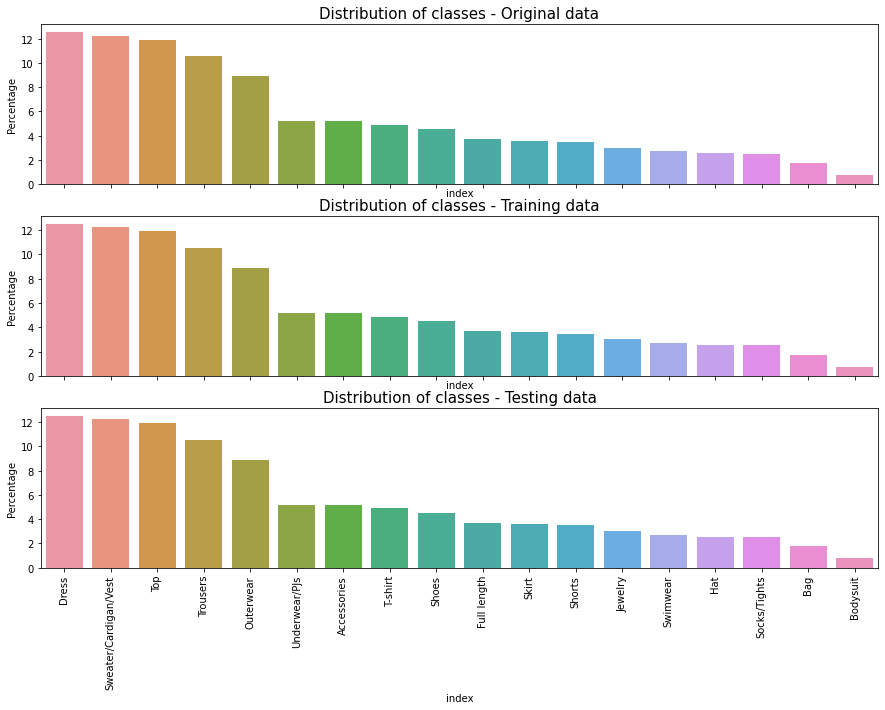

In [112]:
# Compare the training and testing class distributions
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(15,10))

sns.barplot(x='index', y='Percentage', data=original_class_percentages, ax=axes[0])
sns.barplot(x='index', y='Percentage', data=class_percentages_train, ax=axes[1])
sns.barplot(x='index', y='Percentage', data=class_percentages_test, ax=axes[2])

axes[0].set_title('Distribution of classes - Original data', size = 15)
axes[1].set_title('Distribution of classes - Training data', size = 15)
axes[2].set_title('Distribution of classes - Testing data', size = 15)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)

The class distributions between training and testing look similar, and are similar to the class distribution before training/testing split, indicating that class imbalance proportions are maintained.

In [113]:
# Drop the product categories and product_code from X_train and X_test
X_train.drop(['product_type_name','product_code'], axis=1, inplace=True)
X_test.drop(['product_type_name','product_code'], axis=1, inplace=True)

In [114]:
X_test.head()

prod_name  \
article_id                          
112679048   SWEATSHIRT  OC          
112679052   SWEATSHIRT  OC          
194270002   HELENA 2-pack tanktop   
194270044   HELENA 2-pack tanktop   
194270045   HELENA 2-pack tanktop   

                                                                                                                                                 detail_desc  \
article_id                                                                                                                                                     
112679048   Sweatshirt in soft organic cotton with a  press-stud on one shoulder (sizes 12-18 months and 18-24 months without a press-stud). Brushed inside.   
112679052   Sweatshirt in soft organic cotton with a  press-stud on one shoulder (sizes 12-18 months and 18-24 months without a press-stud). Brushed inside.   
194270002   Tops in soft organic cotton jersey.                                                                                                                
194270044   Tops in soft organic cotton jersey.                                                                                                                
194270045   Tops in soft organic cotton jersey.                                                                                                                

                              product_title         0         1         2  \
article_id                                                                  
112679048   ['sweatshirt', 'oc']             1.222298  0.615706  0.468774   
112679052   ['sweatshirt', 'oc']             0.849320  0.005533  0.210697   
194270002   ['helena', '2-pack', 'tanktop']  1.620172  0.140583  0.715644   
194270044   ['helena', '2-pack', 'tanktop']  0.320825  0.479506  0.718964   
194270045   ['helena', '2-pack', 'tanktop']  1.010420  0.091721  2.454683   

                   3         4         5         6  ...       502       503  \
article_id                                          ...                       
112679048   0.278907  0.051020  0.371239  0.299273  ...  1.263749  0.055026   
112679052   0.409732  0.074123  0.642070  1.199575  ...  0.214699  0.471074   
194270002   1.140085  0.141574  0.181567  0.266037  ...  0.245893  0.083284   
194270044   0.042605  0.000000  0.081761  0.623028  ...  0.194123  0.177390   
194270045   0.907387  0.221087  0.308097  0.050207  ...  0.022513  1.019517   

                 504       505       506       507       508       509  \
article_id                                                               
112679048   1.115489  0.941246  4.357105  0.456812  0.422226  0.774133   
112679052   0.272825  0.753160  4.346872  0.339247  0.383309  0.376162   
194270002   0.433086  0.142297  3.915074  2.237202  0.329445  1.800650   
194270044   0.373834  0.565914  4.546570  1.408547  0.297990  1.143682   
194270045   0.700108  0.753436  0.869249  0.686492  0.169349  2.235411   

                 510       511  
article_id                      
112679048   0.341433  0.750042  
112679052   0.673804  1.245971  
194270002   0.343067  1.338163  
194270044   0.491720  0.764727  
194270045   0.166975  0.287730  

[5 rows x 515 columns]

In [115]:
print(f'X_train size: {X_train.shape}')
print(f'X_test size: {X_test.shape}')
print(f'y_train length: {len(y_train)}')
print(f'y_test length: {len(y_test)}')

X_train size: (69224, 515)
X_test size: (29711, 515)
y_train length: 69224
y_test length: 29711


In [119]:
# Save the index to put back after preprocessing
X_train_index = X_train.index
X_test_index = X_test.index

## 3. Preprocessing text: Create a Bag of words with tokenization
Create a bag of words from the product title and product description, excluding stop words. Set the 'MAX_DICT_SIZE' to limit the number of words to use as features. 

In [120]:
# Example text
test_string = """Strap top Jersey top with narrow shoulder straps."""
product_index = "108775015"

# Text preprocessing steps include converting to lowercase, removing stop words and punctuation

def extract_bag_of_words(test_string):
    # Include everything that is alphabetical, no punctuation
    #tokens = [w for w in word_tokenize(str(test_string).lower()) if w.isalpha()]
    tokens = [w for w in str(test_string).lower().split() if w.isalpha()]
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    return no_stops

# Create a counter of all the words in the column 'combined_words'
def create_word_dict(X, MAX_DICT_SIZE, include_description):
    #all_words_dict = Counter(bag_of_words_df(X.combined_words.sum()))
    if include_description:
        all_words_dict = Counter(extract_bag_of_words(X.combined_words.values.tolist()))
    else:
        all_words_dict = Counter(extract_bag_of_words(X.prod_name.values.tolist()))
    
    # Set cutoff threshold to be 5 or more occurances
    threshold = 5

    truncated_words_dict = {key : value for key, value in all_words_dict.items() if value >= threshold}

    # Sort dictionary in descending order and cap at MAX_DICT_SIZE items

    sorted_truncated_words_list = sorted(truncated_words_dict.items(), key=lambda x: x[1], reverse=True)
    if len(sorted_truncated_words_list) > MAX_DICT_SIZE:
        sorted_truncated_words_list = sorted_truncated_words_list[:MAX_DICT_SIZE]
    return dict(sorted_truncated_words_list)


In [121]:
# Extract bag of words from product title (and also product description)

class BagOfWordsFeatureExtractor():
    def __init__(self, include_description):
        self.include_description = include_description
    
    
    def fit(self, X, y=None):
        # Create the word list to use in the transform step
        
        if self.include_description:
            # Combine product title with description
            X['combined_words'] = X['prod_name'] + " " + X['detail_desc'] 
            print('fit step 1')
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['combined_words']), axis=1)
            print('fit step 2')
            self.all_words_dict = create_word_dict(X, MAX_DICT_SIZE, self.include_description)
            print('fit step 3')
            self.bag_of_word_column_names = list(self.all_words_dict.keys())
        else:
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['prod_name']), axis=1)
            self.all_words_dict = create_word_dict(X, MAX_DICT_SIZE, self.include_description)
            self.bag_of_word_column_names = list(self.all_words_dict.keys())
            
        return self

    
    def transform(self, X):
        #print('start transform')
        # Do a row by row check to see if the word occurs in words_list
        # Initialize new columns and set values to 0
        #print('Before initializing columns to 0')
        for col in self.bag_of_word_column_names:
            X["_" + col] = 0
        
#         print('Completed initializing columns to 0')
        
        if self.include_description:
            X['combined_words'] = X['prod_name'] + " " + X['detail_desc'] 
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['combined_words']), axis=1)
        else:
            X['words_list'] = X.apply(lambda x: extract_bag_of_words(x['prod_name']), axis=1)
            
        for i, index in enumerate(X.index):
#             if i%1000:
#                 print(f'Completed {i} rows')
            for word in X.loc[index,'words_list']:
                if word in self.bag_of_word_column_names:
                    X.loc[index,"_" + word] = 1
#         print('Completed initializing columns to 1')
        
        # Drop columns
        if self.include_description:
            X.drop(['combined_words','words_list'], axis=1, inplace=True)
        else:
            X.drop(['words_list'], axis=1, inplace=True)
#         print('Dropped columns')
        return X

### Consider 3 versions to compare model performance:
1. Image embeddings
2. Product title embeddings
3. Product title + product description embeddings
4. Product title + product description + image embeddings

### 1. Product category prediction using only image embeddings

In [122]:
# The image embedding column names are stored in a list
image_cols = [str(num) for num in range(512)]

X_train_image = X_train[image_cols]
X_test_image = X_test[image_cols]

### 2. NLP pipeline: Product title embeddings

In [123]:
bag_of_words_title = BagOfWordsFeatureExtractor(include_description = False)

p2 = Pipeline([
    ('bag_of_words_title', bag_of_words_title)])

# Product title embeddings
#time_start = time.time()
X_train_2 = p2.fit_transform(X_train)
#print(time.time() - time_start)

X_test_2 = p2.transform(X_test)

# Assign index back
X_train_2.index = X_train_index
X_test_2.index = X_test_index


/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

In [125]:
X_test_2.head()

prod_name  \
article_id                          
112679048   SWEATSHIRT  OC          
112679052   SWEATSHIRT  OC          
194270002   HELENA 2-pack tanktop   
194270044   HELENA 2-pack tanktop   
194270045   HELENA 2-pack tanktop   

                                                                                                                                                 detail_desc  \
article_id                                                                                                                                                     
112679048   Sweatshirt in soft organic cotton with a  press-stud on one shoulder (sizes 12-18 months and 18-24 months without a press-stud). Brushed inside.   
112679052   Sweatshirt in soft organic cotton with a  press-stud on one shoulder (sizes 12-18 months and 18-24 months without a press-stud). Brushed inside.   
194270002   Tops in soft organic cotton jersey.                                                                                                                
194270044   Tops in soft organic cotton jersey.                                                                                                                
194270045   Tops in soft organic cotton jersey.                                                                                                                

                              product_title         0         1         2  \
article_id                                                                  
112679048   ['sweatshirt', 'oc']             1.222298  0.615706  0.468774   
112679052   ['sweatshirt', 'oc']             0.849320  0.005533  0.210697   
194270002   ['helena', '2-pack', 'tanktop']  1.620172  0.140583  0.715644   
194270044   ['helena', '2-pack', 'tanktop']  0.320825  0.479506  0.718964   
194270045   ['helena', '2-pack', 'tanktop']  1.010420  0.091721  2.454683   

                   3         4         5         6  ...  _blouse  _leather  \
article_id                                          ...                      
112679048   0.278907  0.051020  0.371239  0.299273  ...  0        0          
112679052   0.409732  0.074123  0.642070  1.199575  ...  0        0          
194270002   1.140085  0.141574  0.181567  0.266037  ...  0        0          
194270044   0.042605  0.000000  0.081761  0.623028  ...  0        0          
194270045   0.907387  0.221087  0.308097  0.050207  ...  0        0          

            _pull  _fur  _w  _super  _trs  _stretch  _tvp  _utility  
article_id                                                           
112679048   0      0     0   0       0     0         0     0         
112679052   0      0     0   0       0     0         0     0         
194270002   0      0     0   0       0     0         0     0         
194270044   0      0     0   0       0     0         0     0         
194270045   0      0     0   0       0     0         0     0         

[5 rows x 615 columns]

### 3. NLP pipeline: Product title  + description embeddings

In [126]:
bag_of_words_title_desc = BagOfWordsFeatureExtractor(include_description = True)

# Create another set for Product title + product description embeddings
p3 = Pipeline([
    ('bag_of_words_title_desc', bag_of_words_title_desc)
])

X_train_3 = p3.fit_transform(X_train)
X_test_3 = p3.transform(X_test)

# Assign index back
X_train_3.index = X_train_index
X_test_3.index = X_test_index


fit step 1
fit step 2
fit step 3


/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X["_" + col] = 0
/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/2358199283.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

In [127]:
# Remove the 2 original text columns + 512 image embedding columns
nlp_cols = list(X_train_2.columns)[515:]
X_train_2 = X_train_2[nlp_cols]
X_test_2 = X_test_2[nlp_cols]

In [128]:
X_train_2.head()

_fancy  _ls  _hw  _ss  _tee  _slim  _dress  _price  _basic  \
article_id                                                               
108775015   0       0    0    0    0     0      0       0       0        
108775044   0       0    0    0    0     0      0       0       0        
108775051   0       0    0    0    0     0      0       0       0        
145872001   0       0    0    0    0     0      0       0       1        
145872037   0       0    0    0    0     0      0       0       1        

            _denim  ...  _round  _trim  _print  _washed  _loop  _functional  \
article_id          ...                                                       
108775015   0       ...  0       0      0       0        0      0             
108775044   0       ...  0       0      0       0        0      0             
108775051   0       ...  0       0      0       0        0      0             
145872001   0       ...  0       0      0       0        0      1             
145872037   0       ...  0       0      0       0        0      1             

            _buttoned  _slits  _mesh  _welt  
article_id                                   
108775015   0          0       0      0      
108775044   0          0       0      0      
108775051   0          0       0      0      
145872001   0          0       0      0      
145872037   0          0       0      0      

[5 rows x 172 columns]

In [129]:
X_train_2.sum()

_fancy         1751
_ls            1468
_hw            959 
_ss            1035
_tee           3239
               ... 
_functional    2360
_buttoned      2350
_slits         2317
_mesh          2065
_welt          2297
Length: 172, dtype: int64

In [130]:
X_test_2.head()

_fancy  _ls  _hw  _ss  _tee  _slim  _dress  _price  _basic  \
article_id                                                               
112679048   0       0    0    0    0     0      0       0       0        
112679052   0       0    0    0    0     0      0       0       0        
194270002   0       0    0    0    0     0      0       0       0        
194270044   0       0    0    0    0     0      0       0       0        
194270045   0       0    0    0    0     0      0       0       0        

            _denim  ...  _round  _trim  _print  _washed  _loop  _functional  \
article_id          ...                                                       
112679048   0       ...  0       0      0       0        0      0             
112679052   0       ...  0       0      0       0        0      0             
194270002   0       ...  0       0      0       0        0      0             
194270044   0       ...  0       0      0       0        0      0             
194270045   0       ...  0       0      0       0        0      0             

            _buttoned  _slits  _mesh  _welt  
article_id                                   
112679048   0          0       0      0      
112679052   0          0       0      0      
194270002   0          0       0      0      
194270044   0          0       0      0      
194270045   0          0       0      0      

[5 rows x 172 columns]

### 4. Product title + product description + image embeddings

In [131]:
X_train_full = X_train_3.drop(['prod_name','detail_desc','product_title'], axis=1)
X_test_full = X_test_3.drop(['prod_name','detail_desc','product_title'], axis=1)

# Do the same for the title + desc dataset
X_train_3 = X_train_3[nlp_cols]
X_test_3 = X_test_3[nlp_cols]

X_train_3.head()

_fancy  _ls  _hw  _ss  _tee  _slim  _dress  _price  _basic  \
article_id                                                               
108775015   0       0    0    0    0     0      0       0       0        
108775044   0       0    0    0    0     0      0       0       0        
108775051   0       0    0    0    0     0      0       0       0        
145872001   0       0    0    0    0     0      0       0       1        
145872037   0       0    0    0    0     0      0       0       1        

            _denim  ...  _round  _trim  _print  _washed  _loop  _functional  \
article_id          ...                                                       
108775015   0       ...  0       0      0       0        0      0             
108775044   0       ...  0       0      0       0        0      0             
108775051   0       ...  0       0      0       0        0      0             
145872001   0       ...  0       0      0       0        0      1             
145872037   0       ...  0       0      0       0        0      1             

            _buttoned  _slits  _mesh  _welt  
article_id                                   
108775015   0          0       0      0      
108775044   0          0       0      0      
108775051   0          0       0      0      
145872001   0          0       0      0      
145872037   0          0       0      0      

[5 rows x 172 columns]

In [132]:
X_test_3.head()

_fancy  _ls  _hw  _ss  _tee  _slim  _dress  _price  _basic  \
article_id                                                               
112679048   0       0    0    0    0     0      0       0       0        
112679052   0       0    0    0    0     0      0       0       0        
194270002   0       0    0    0    0     0      0       0       0        
194270044   0       0    0    0    0     0      0       0       0        
194270045   0       0    0    0    0     0      0       0       0        

            _denim  ...  _round  _trim  _print  _washed  _loop  _functional  \
article_id          ...                                                       
112679048   0       ...  0       0      0       0        0      0             
112679052   0       ...  0       0      0       0        0      0             
194270002   0       ...  0       0      0       0        0      0             
194270044   0       ...  0       0      0       0        0      0             
194270045   0       ...  0       0      0       0        0      0             

            _buttoned  _slits  _mesh  _welt  
article_id                                   
112679048   0          0       0      0      
112679052   0          0       0      0      
194270002   0          0       0      0      
194270044   0          0       0      0      
194270045   0          0       0      0      

[5 rows x 172 columns]

In [133]:
X_train_2.isna().sum()

_fancy         0
_ls            0
_hw            0
_ss            0
_tee           0
              ..
_functional    0
_buttoned      0
_slits         0
_mesh          0
_welt          0
Length: 172, dtype: int64

In [134]:
col_name = list(X_train_2.columns)
print(f'The number of columns after preprocessing: {len(col_name)}')
#col_name

The number of columns after preprocessing: 172


## Machine Learning Models
Try combinations of the following features:
- image embeddings
- product title features
- product title + description features
- product title + image embeddings
- product title + description features + image embeddings

Build different models and tune hyperparameters using Random Search and cross validation. 
Use AUC as metric to compare performance between the models.

### Stochastic Gradient Descent Classifier
### 1. Image classification features only

In [135]:
X_train_image.shape

(69224, 512)

In [136]:
X_train_image.head()

0         1         2         3         4         5  \
article_id                                                               
108775015   1.671856  0.076411  1.992960  0.515366  0.087093  0.499538   
108775044   0.317337  0.022370  0.790894  0.184620  0.122858  0.215203   
108775051   0.972625  0.119625  2.423473  1.054603  0.002196  1.429509   
145872001   0.352032  0.036019  0.208536  1.069184  0.095426  0.349860   
145872037   0.514889  0.155787  0.148822  0.172575  0.082710  0.406160   

                   6         7         8         9  ...       502       503  \
article_id                                          ...                       
108775015   0.125408  0.519581  0.692295  0.194752  ...  0.283601  0.502333   
108775044   0.008712  0.393076  0.475337  0.341774  ...  0.369955  0.305547   
108775051   0.087665  1.118197  0.183544  0.195096  ...  0.673954  1.023912   
145872001   0.782672  0.327280  0.241861  0.285968  ...  1.096645  0.235036   
145872037   1.001948  0.460893  0.465420  0.301038  ...  0.883630  0.394170   

                 504       505       506       507       508       509  \
article_id                                                               
108775015   0.815049  0.183200  1.749047  1.393814  0.003090  3.470509   
108775044   0.750164  0.278698  3.498078  1.059729  0.080655  0.457405   
108775051   1.220658  0.990421  0.603554  1.449252  0.105316  2.191562   
145872001   0.088652  0.355652  5.857070  0.804569  0.092536  0.340698   
145872037   0.461126  1.258459  5.701306  1.189615  0.281143  0.690465   

                 510       511  
article_id                      
108775015   0.953905  1.414786  
108775044   0.473151  1.298293  
108775051   2.410787  0.329729  
145872001   0.323110  1.655938  
145872037   0.089672  1.439759  

[5 rows x 512 columns]

In [137]:
# Parameters
param_SGDC = {
            'penalty':['elasticnet'],
            'alpha':[1e-3, 1e-2, 1e-1],
            'max_iter':[2000],
            'n_jobs': [-1]
            }

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC, cv=5, random_state=0)

sgdc_model.fit(X_train_image, y_train)
best_model = sgdc_model.best_estimator_
y_pred_image = best_model.predict(X_test_image)

sgdc_model_1 = classification_report(y_test, y_pred_image, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [139]:
print(classification_report(y_train, best_model.predict(X_train_image)))

                       precision    recall  f1-score   support

          Accessories       0.69      0.84      0.76      2989
                  Bag       0.92      0.80      0.86       893
             Bodysuit       0.83      0.58      0.68       670
                Dress       0.81      0.76      0.78      7201
          Full length       0.66      0.44      0.53      1918
                  Hat       0.95      0.85      0.90      1612
              Jewelry       0.94      0.87      0.90      1199
            Outerwear       0.86      0.73      0.79      5461
                Shoes       0.98      0.97      0.97      2591
               Shorts       0.86      0.79      0.82      2759
                Skirt       0.73      0.73      0.73      1841
         Socks/Tights       0.90      0.54      0.67      2575
Sweater/Cardigan/Vest       0.73      0.78      0.76      9738
             Swimwear       0.76      0.74      0.75      2023
              T-shirt       0.84      0.71      0.77  

### Weighted F1-score
Since this is a multi-class classification, the F1 score is calculated for each class in a One-vs-Rest (OvR) approach. The weighted-averaged F1 score is calculated by taking the mean of all per-class F1 scores while considering each class’s support. Since this dataset has class imbalances we want to assign greater contribution to classes with more examples in the dataset, thus the weighted average is used.

Text(0.5, 1.0, 'Confusion Matrix for Image classification features only')

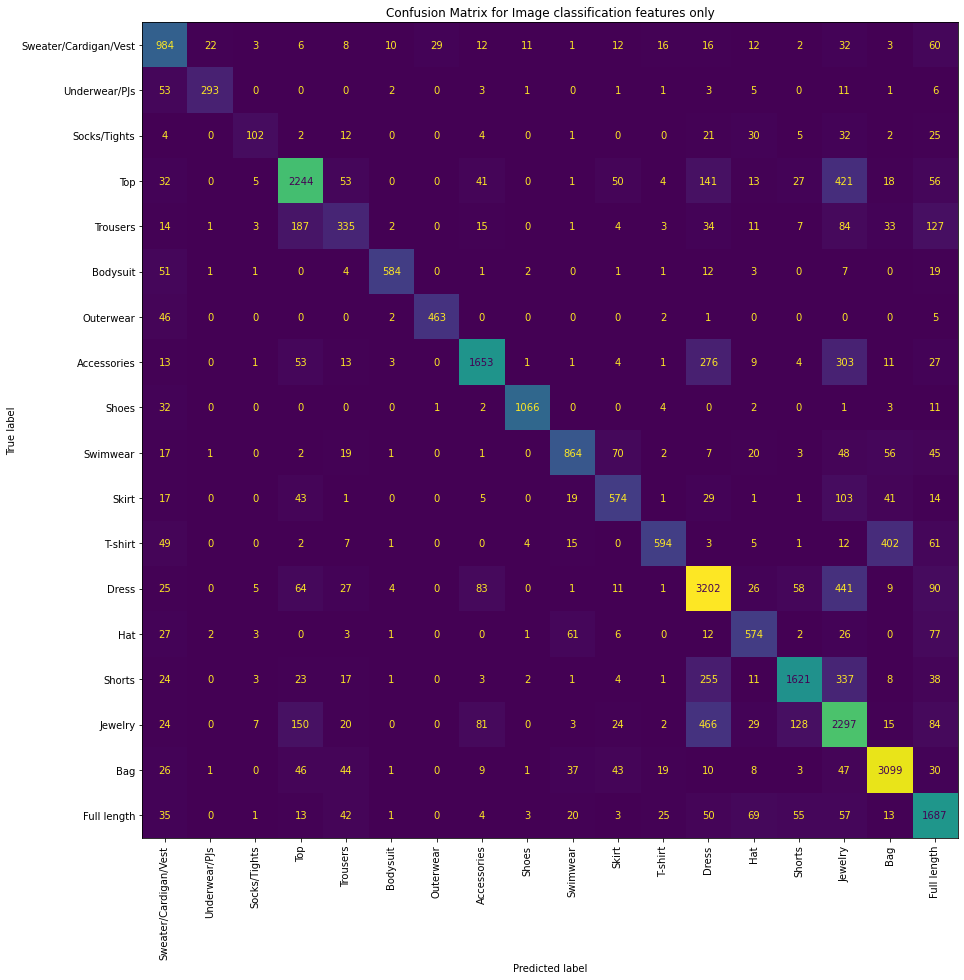

In [140]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_image,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for Image classification features only")


In [141]:
class_labels = list(best_model.classes_)
class_labels

['Accessories',
 'Bag',
 'Bodysuit',
 'Dress',
 'Full length',
 'Hat',
 'Jewelry',
 'Outerwear',
 'Shoes',
 'Shorts',
 'Skirt',
 'Socks/Tights',
 'Sweater/Cardigan/Vest',
 'Swimwear',
 'T-shirt',
 'Top',
 'Trousers',
 'Underwear/PJs']

### Investigate the incorrectly classified products
Calculate a score called `predicted_label_confidence` which is the difference in the confidence scores given in the SGDC's decision_function for the predicted class vs. the actual product category label. Look at the misclassified examples with the highest score i.e. the ones the model was most sure about but got wrong to see if there are any obvious issues with the model or data.

In [142]:
incorrect_labels_idx = X_test_image[y_test != y_pred_image].index
incorrect_labels_info = df.loc[incorrect_labels_idx][['prod_name','detail_desc','product_type_name']]

In [143]:
incorrect_labels_info['predicted_label'] = y_pred_image[y_test != y_pred_image]

In [144]:
incorrect_labels_info

prod_name  \
article_id                         
290519008   Basic co/fl cardigan   
290519011   Basic co/fl cardigan   
290519014   Basic co/fl cardigan   
290519024   Co/fl cardigan         
372008010   Halter                 
...                    ...         
932578001   Milan jumpsuit         
938632001   LOUIS HOOD SET TP      
940036001   Knot Set               
940036002   Knot Set               
942053001   Seamless base layer.   

                                                                                                                                                                                                                                                                                                  detail_desc  \
article_id                                                                                                                                                                                                                                                                                                      
290519008   Cardigan in soft organic cotton sweatshirt fabric with a stand-up collar, press-studs down the front, and ribbing around the neckline, cuffs and hem. Soft brushed inside.                                                                                                                          
290519011   Cardigan in soft organic cotton sweatshirt fabric with a stand-up collar, press-studs down the front, and ribbing around the neckline, cuffs and hem. Soft brushed inside.                                                                                                                          
290519014   Cardigan in soft organic cotton sweatshirt fabric with a stand-up collar, press-studs down the front, and ribbing around the neckline, cuffs and hem. Soft brushed inside.                                                                                                                          
290519024   Cardigan in soft organic cotton sweatshirt fabric with a stand-up collar, press-studs down the front, and ribbing around the neckline, cuffs and hem. Soft brushed inside.                                                                                                                          
372008010   Gently flared vest top in jersey with a sheen. Narrow shoulder straps that cross at the back. Lined at the top.                                                                                                                                                                                     
...                                                                                                                                                                                ...                                                                                                                          
932578001   Ankle-length boiler suit in cotton twill with a soft finish. Collar, concealed buttons at the top and covered elastication and a detachable tie belt at the waist. Flap chest pockets and diagonal front pockets. Long sleeves with buttoned cuffs and wide, gently tapered legs.                   
938632001   Set with a hoodie and sweatpants in soft, printed sweatshirt fabric. Hoodie with long sleeves and ribbing at the cuffs. Sweatpants with covered elastication and a drawstring at the waist and ribbed hems.                                                                                         
940036001   Set with a top and pair of leggings in soft, organic cotton jersey. Top with dropped shoulders, long sleeves, ribbing around the neckline and cuffs and ties at the hem. Leggings with covered elastication at the waist.                                                                           
940036002   Set with a top and pair of leggings in soft, organic cotton jersey. Top with dropped shoulders, long sleeves, ribbing around the neckline and cuffs and ties at the hem. Leggings with cove

In [145]:
# Create a dictionary to map product category class to the index of the decision function
class_labels_dict = dict(zip(class_labels,range(len(class_labels))))
class_labels_dict

{'Accessories': 0,
 'Bag': 1,
 'Bodysuit': 2,
 'Dress': 3,
 'Full length': 4,
 'Hat': 5,
 'Jewelry': 6,
 'Outerwear': 7,
 'Shoes': 8,
 'Shorts': 9,
 'Skirt': 10,
 'Socks/Tights': 11,
 'Sweater/Cardigan/Vest': 12,
 'Swimwear': 13,
 'T-shirt': 14,
 'Top': 15,
 'Trousers': 16,
 'Underwear/PJs': 17}

In [146]:
# Compute the score between predicted label and actual label
predicted_label_scores = best_model.decision_function(X_test_image[y_test != y_pred_image])
article_id_to_idx = dict(zip(incorrect_labels_info.index, range(len(incorrect_labels_info))))
                         
def compute_confidence(row):
    predicted_label_class_idx = class_labels_dict[row['predicted_label']]
    actual_label_class_idx = class_labels_dict[row['product_type_name']]
    idx = article_id_to_idx[row.name]
    return predicted_label_scores[idx, predicted_label_class_idx] - predicted_label_scores[idx, actual_label_class_idx]
    
incorrect_labels_info['predicted_label_confidence'] = incorrect_labels_info.apply(lambda row: compute_confidence(row), axis=1)

/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/4227222099.py:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)



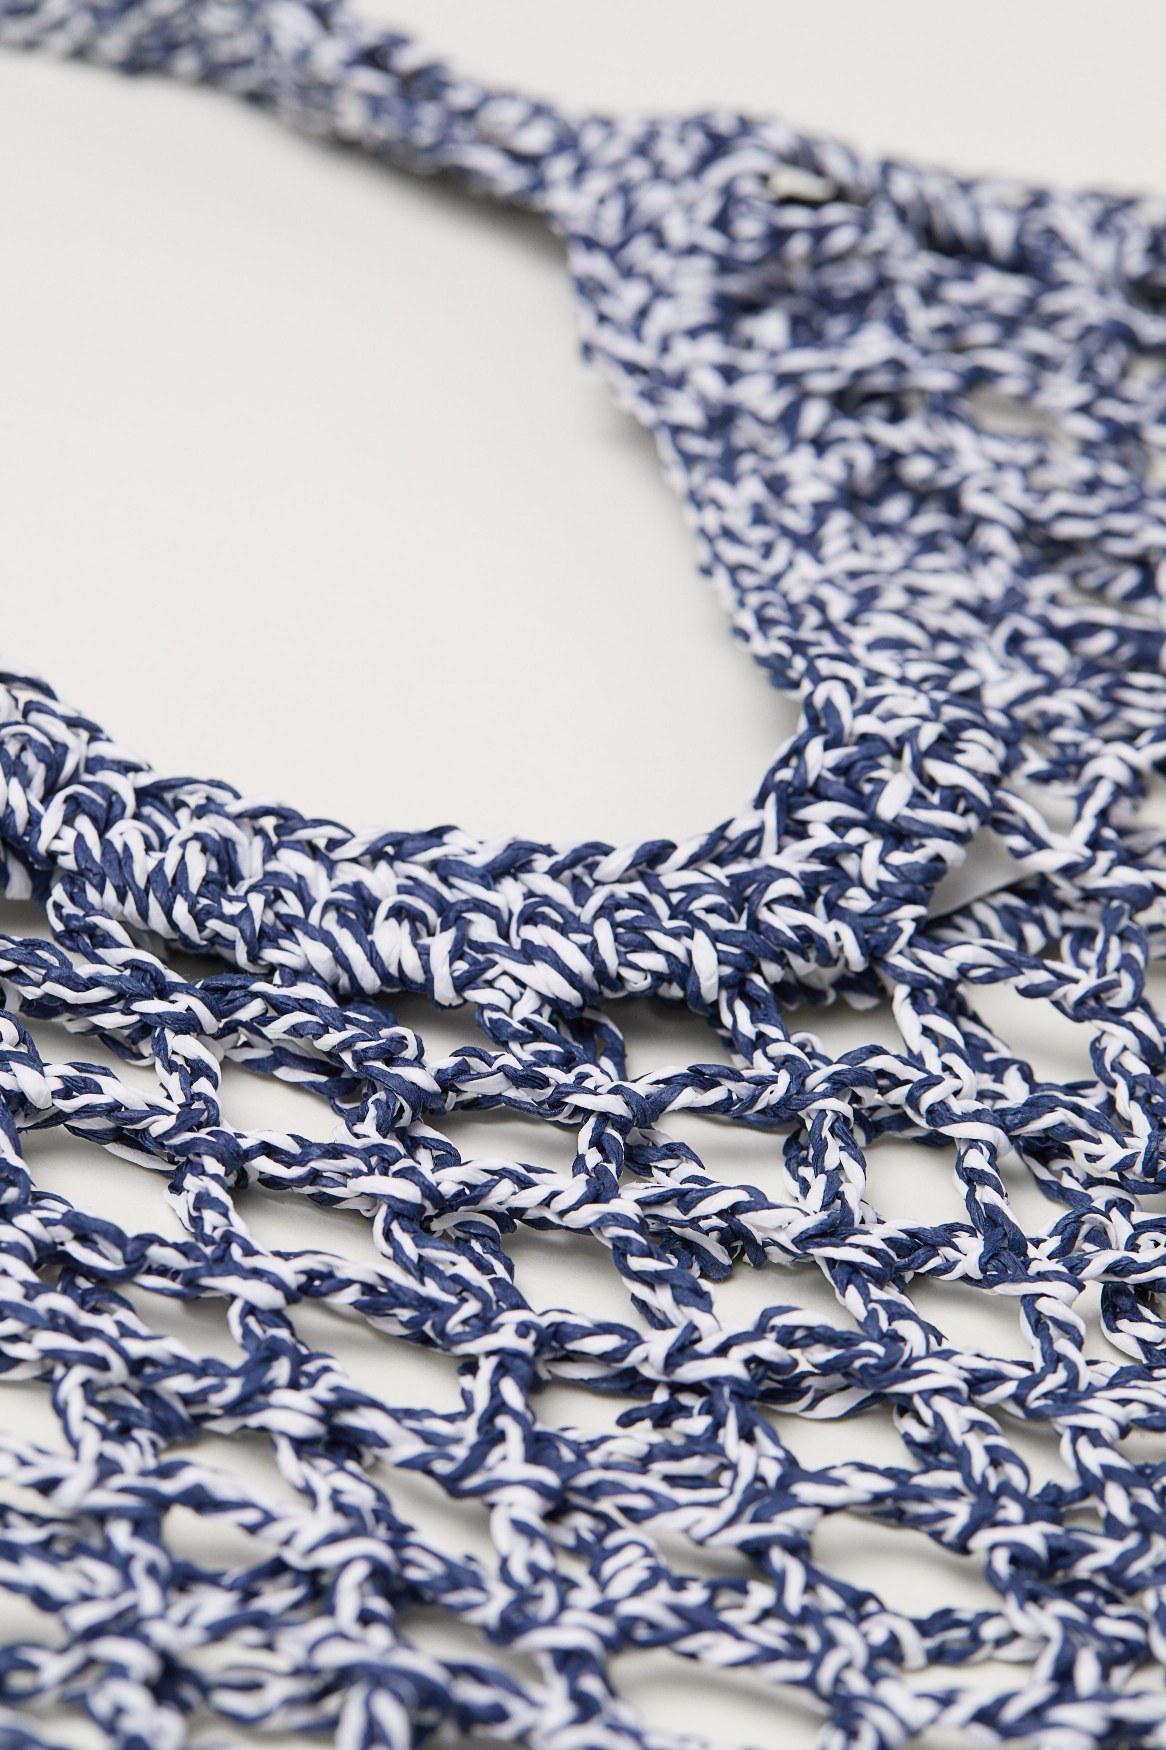
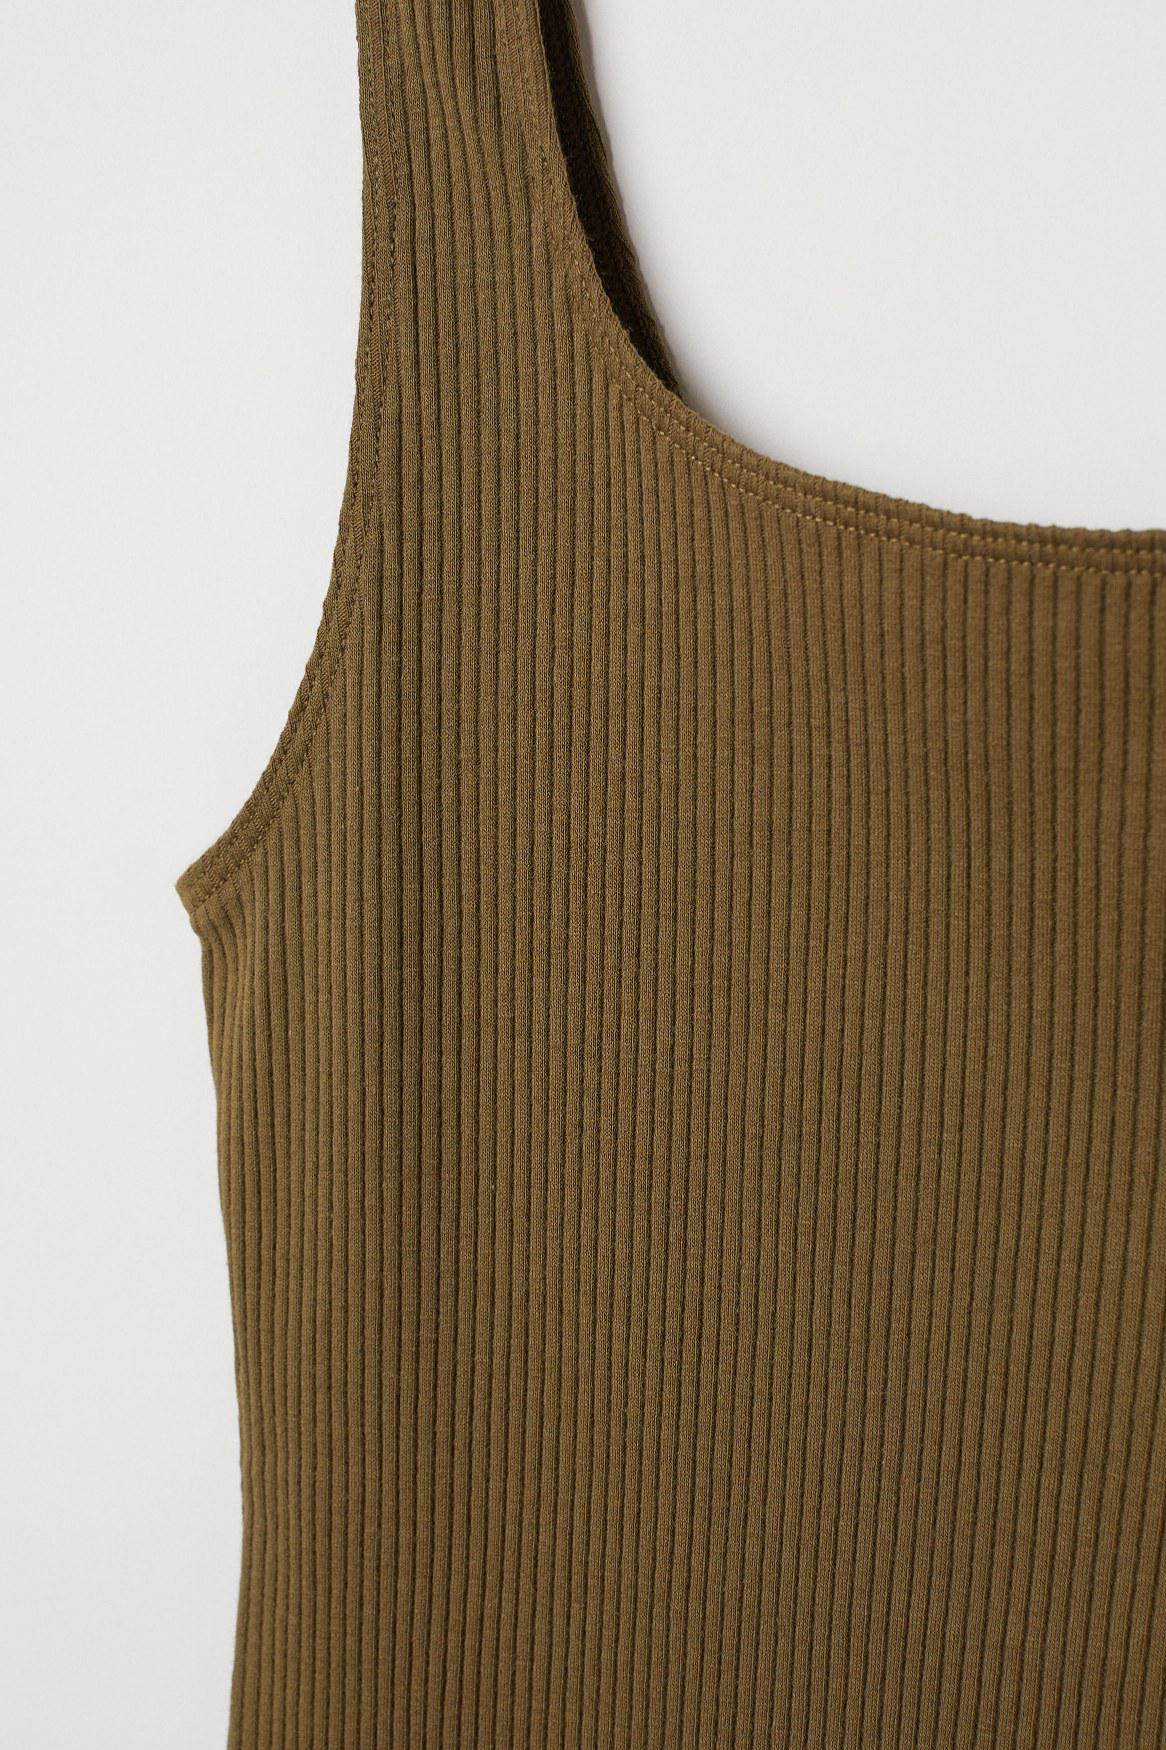
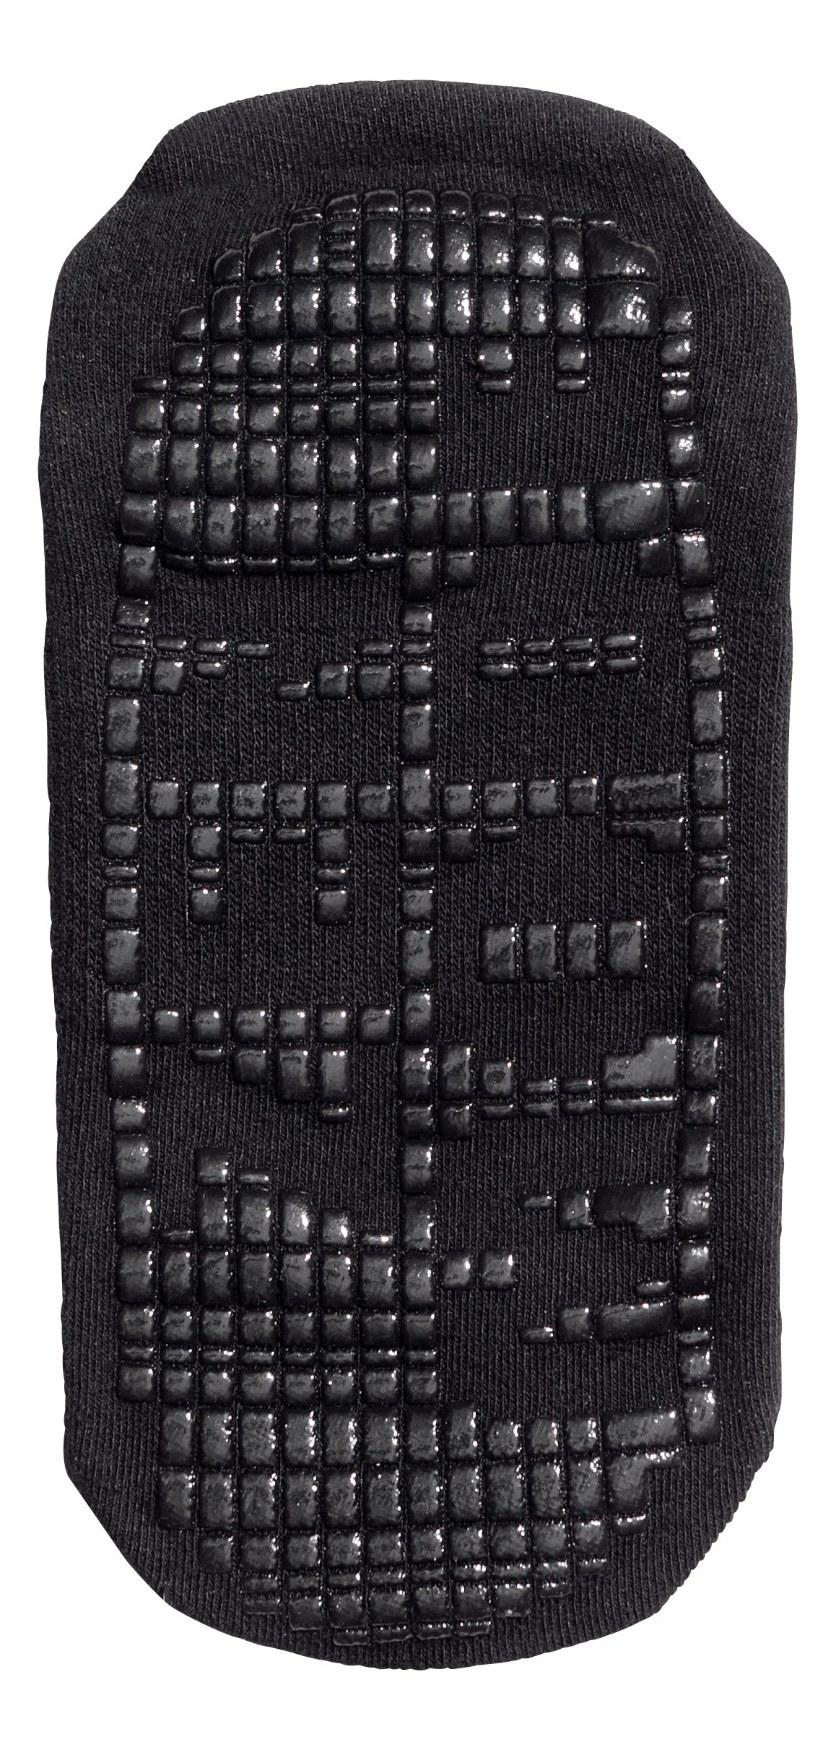
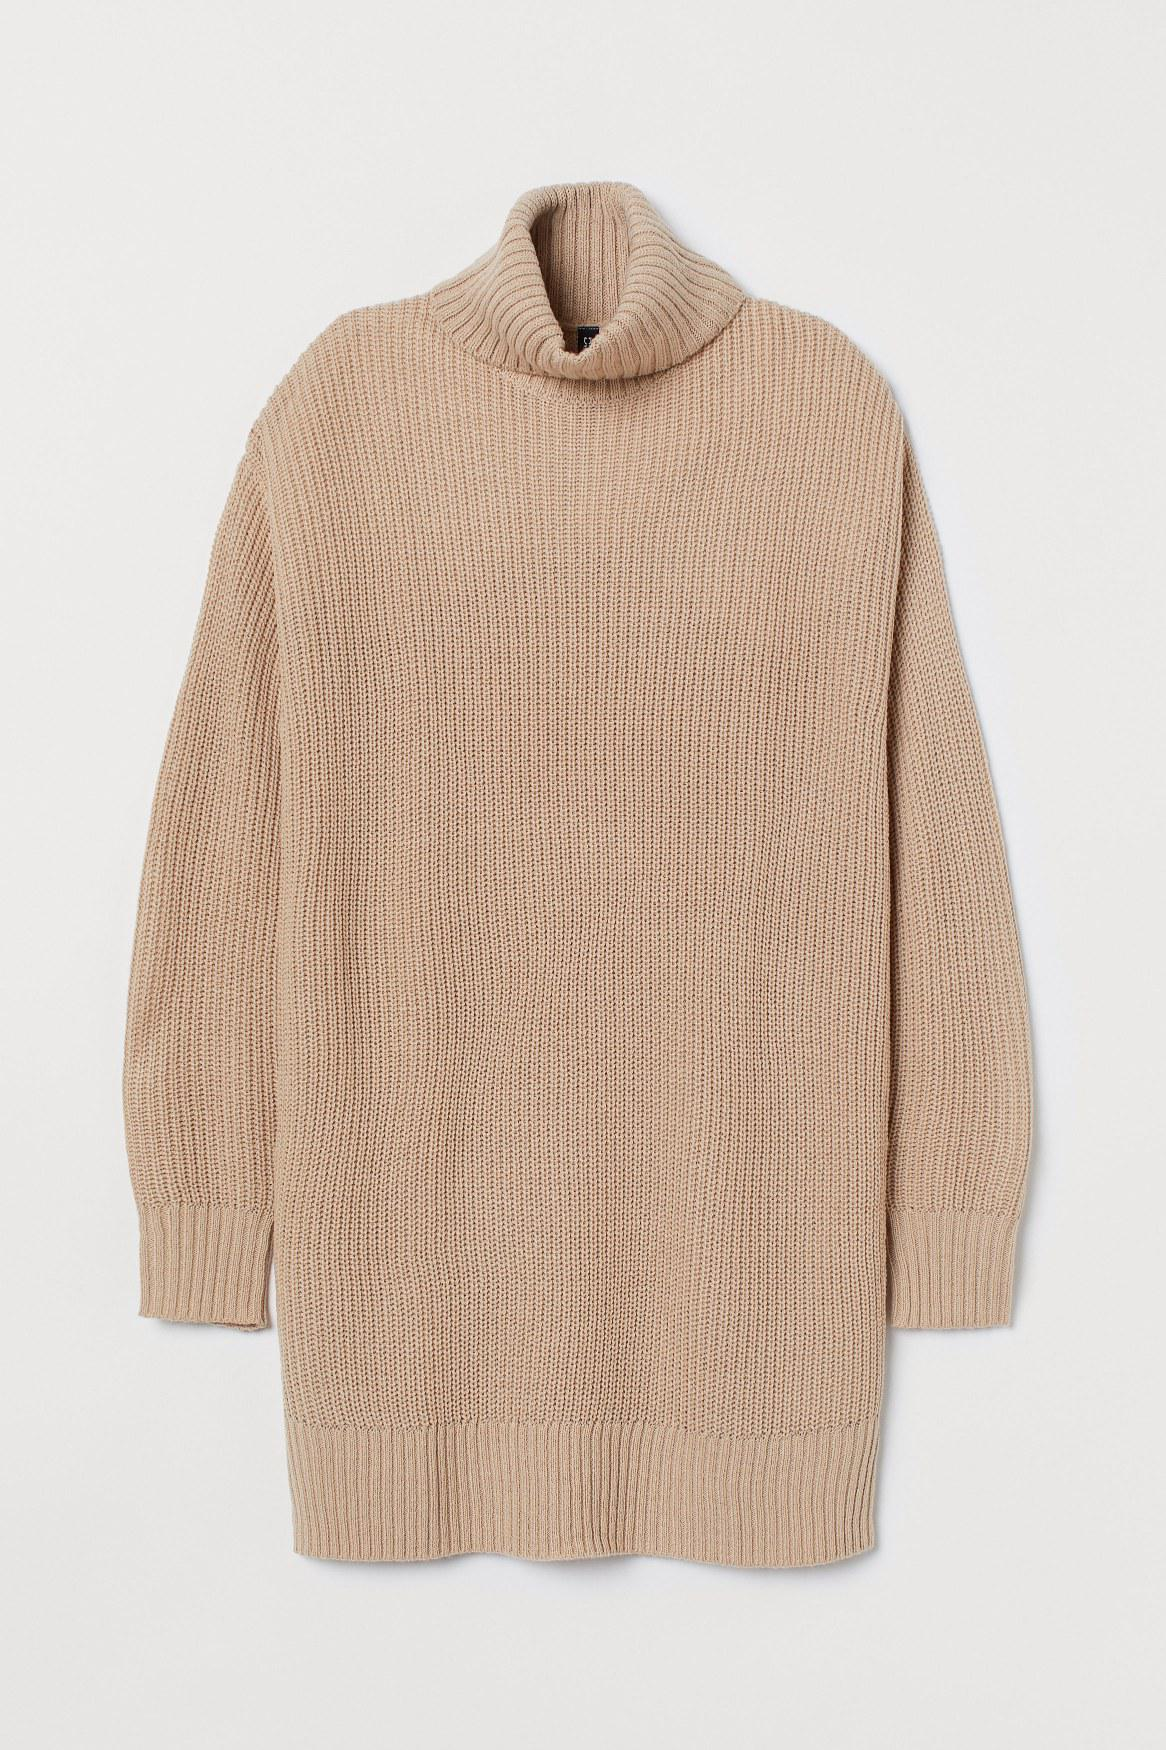
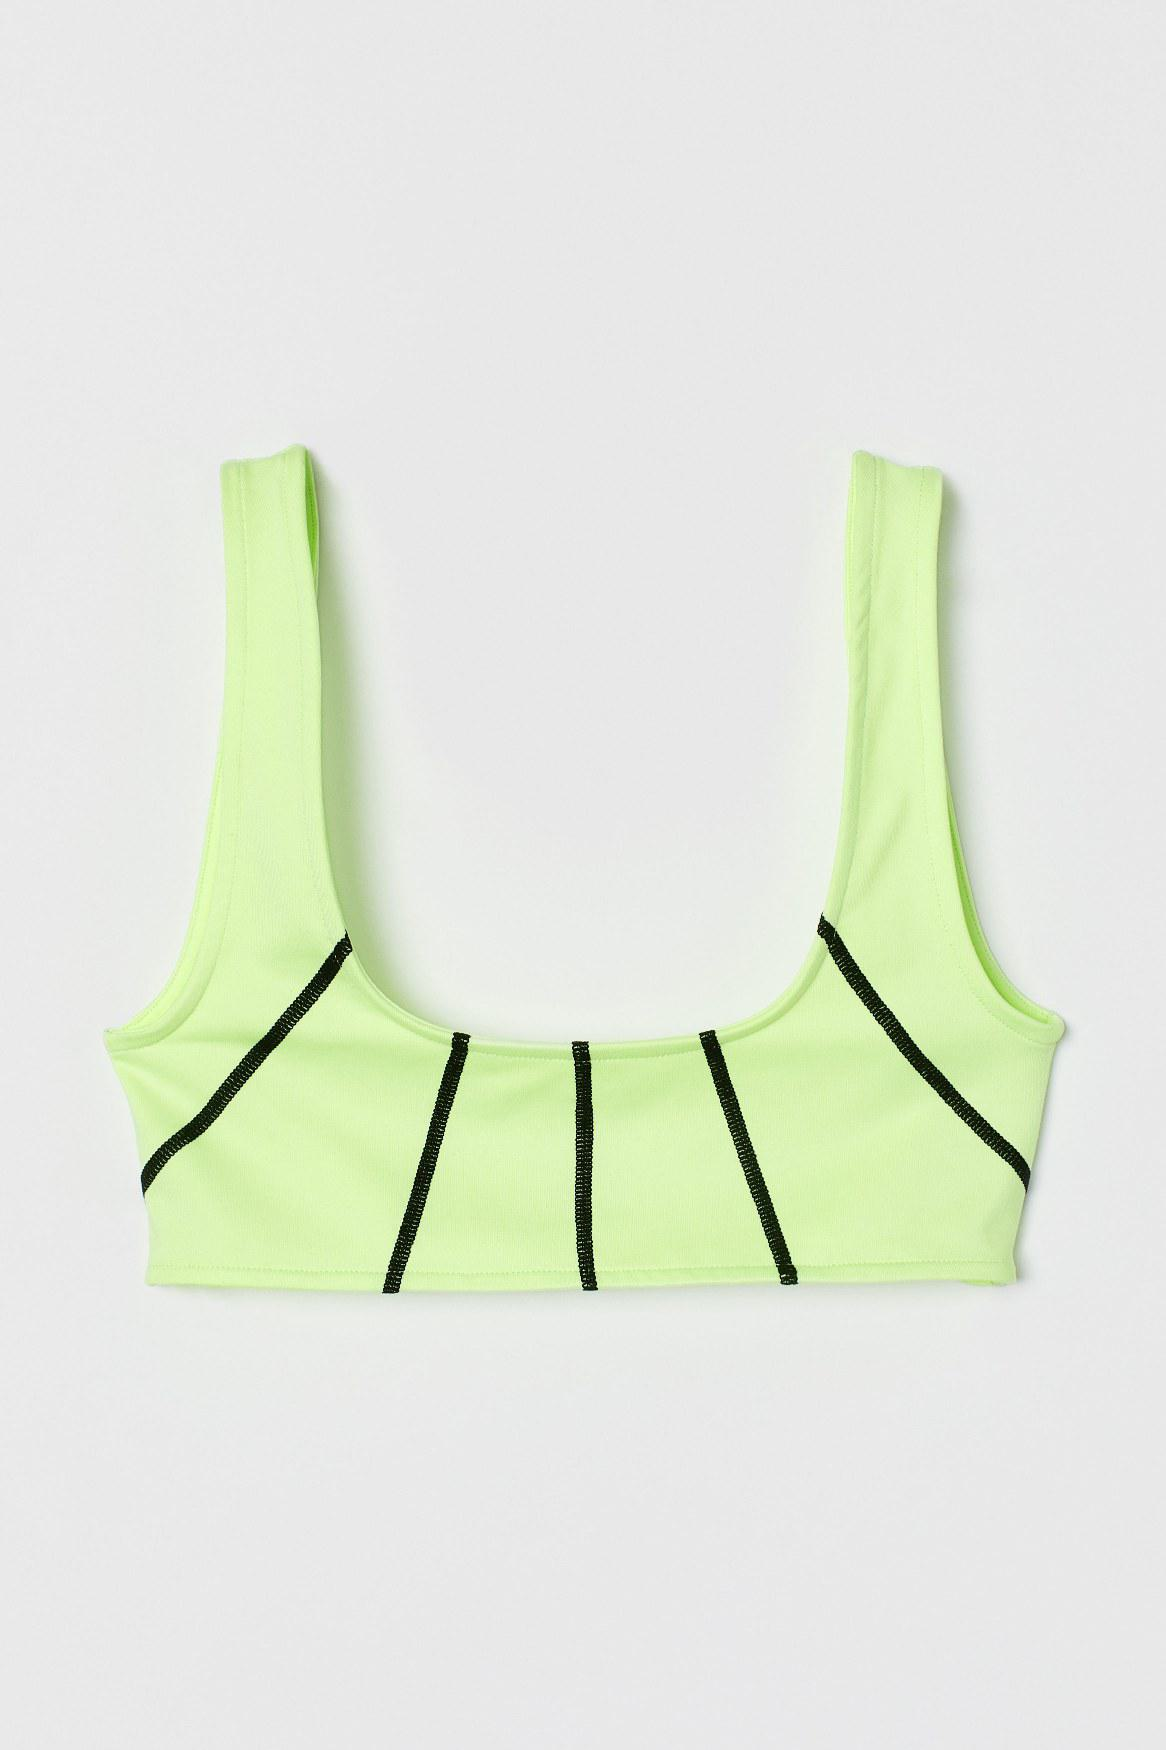
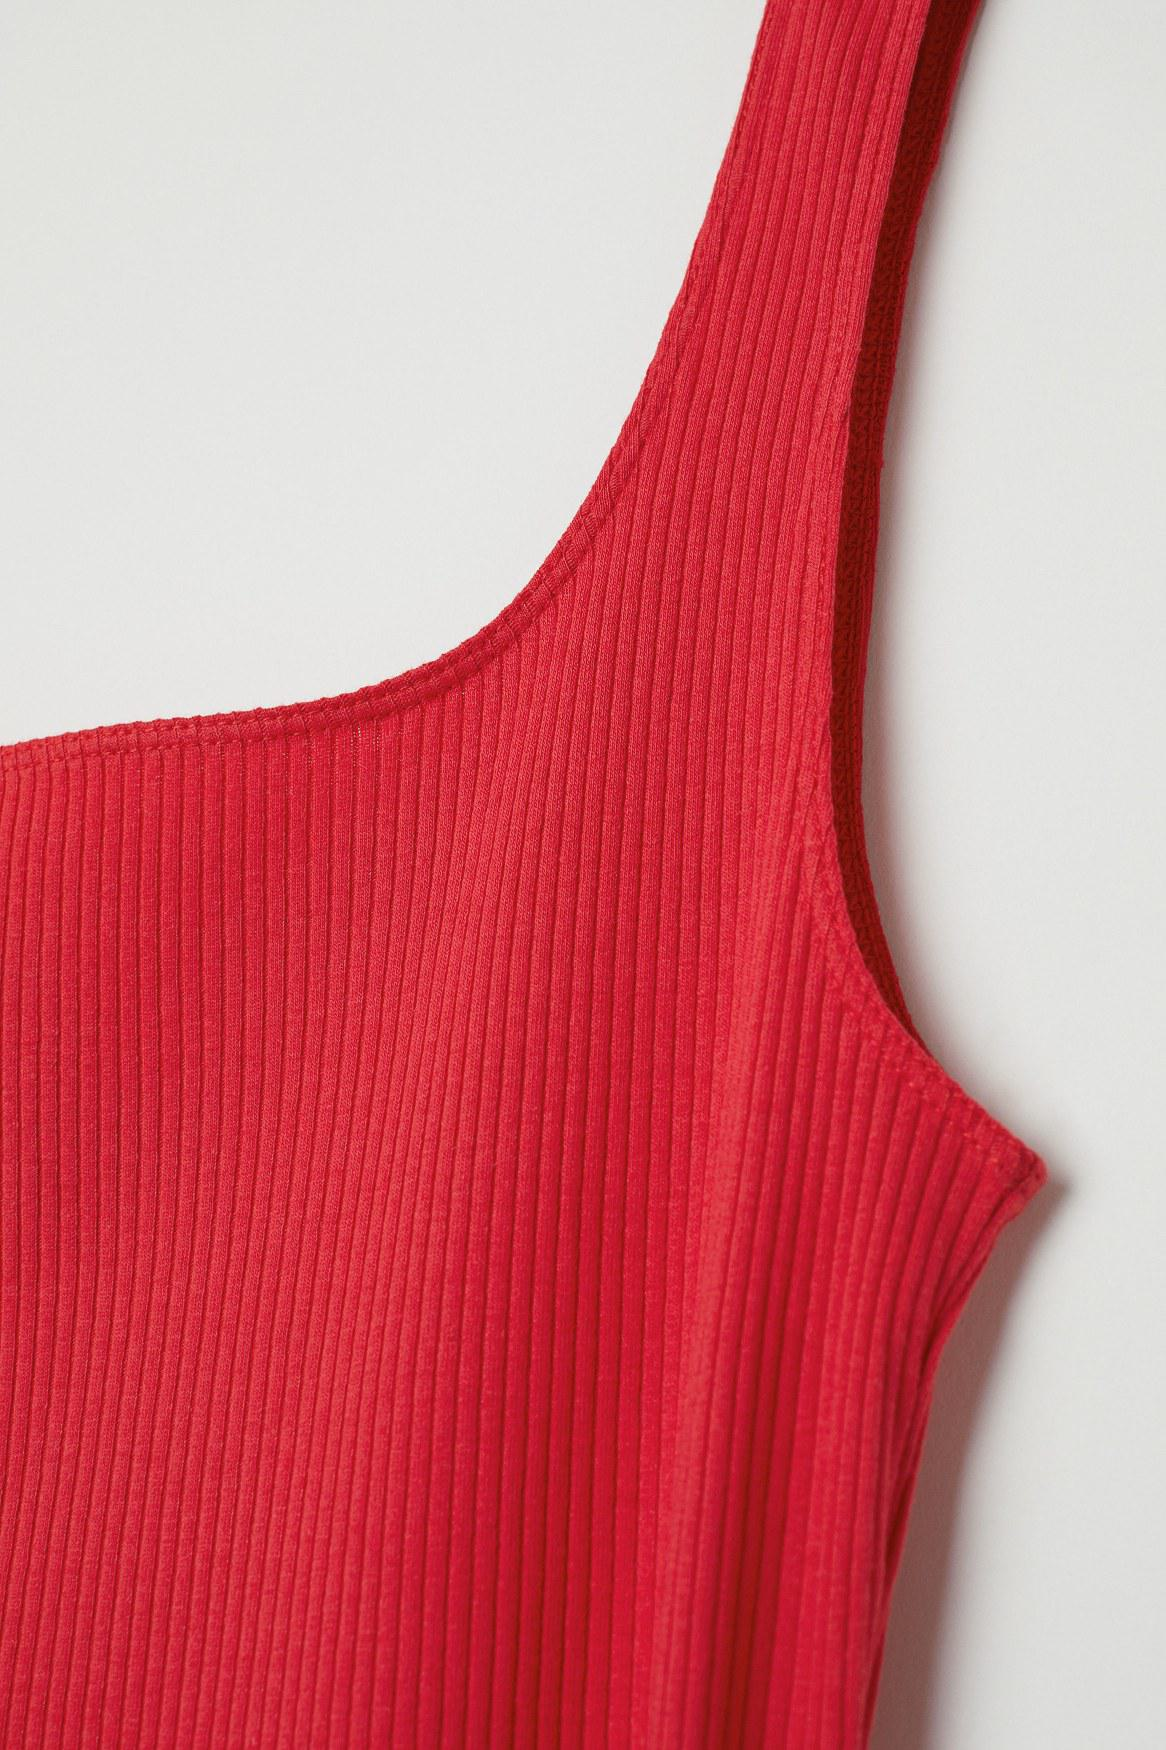
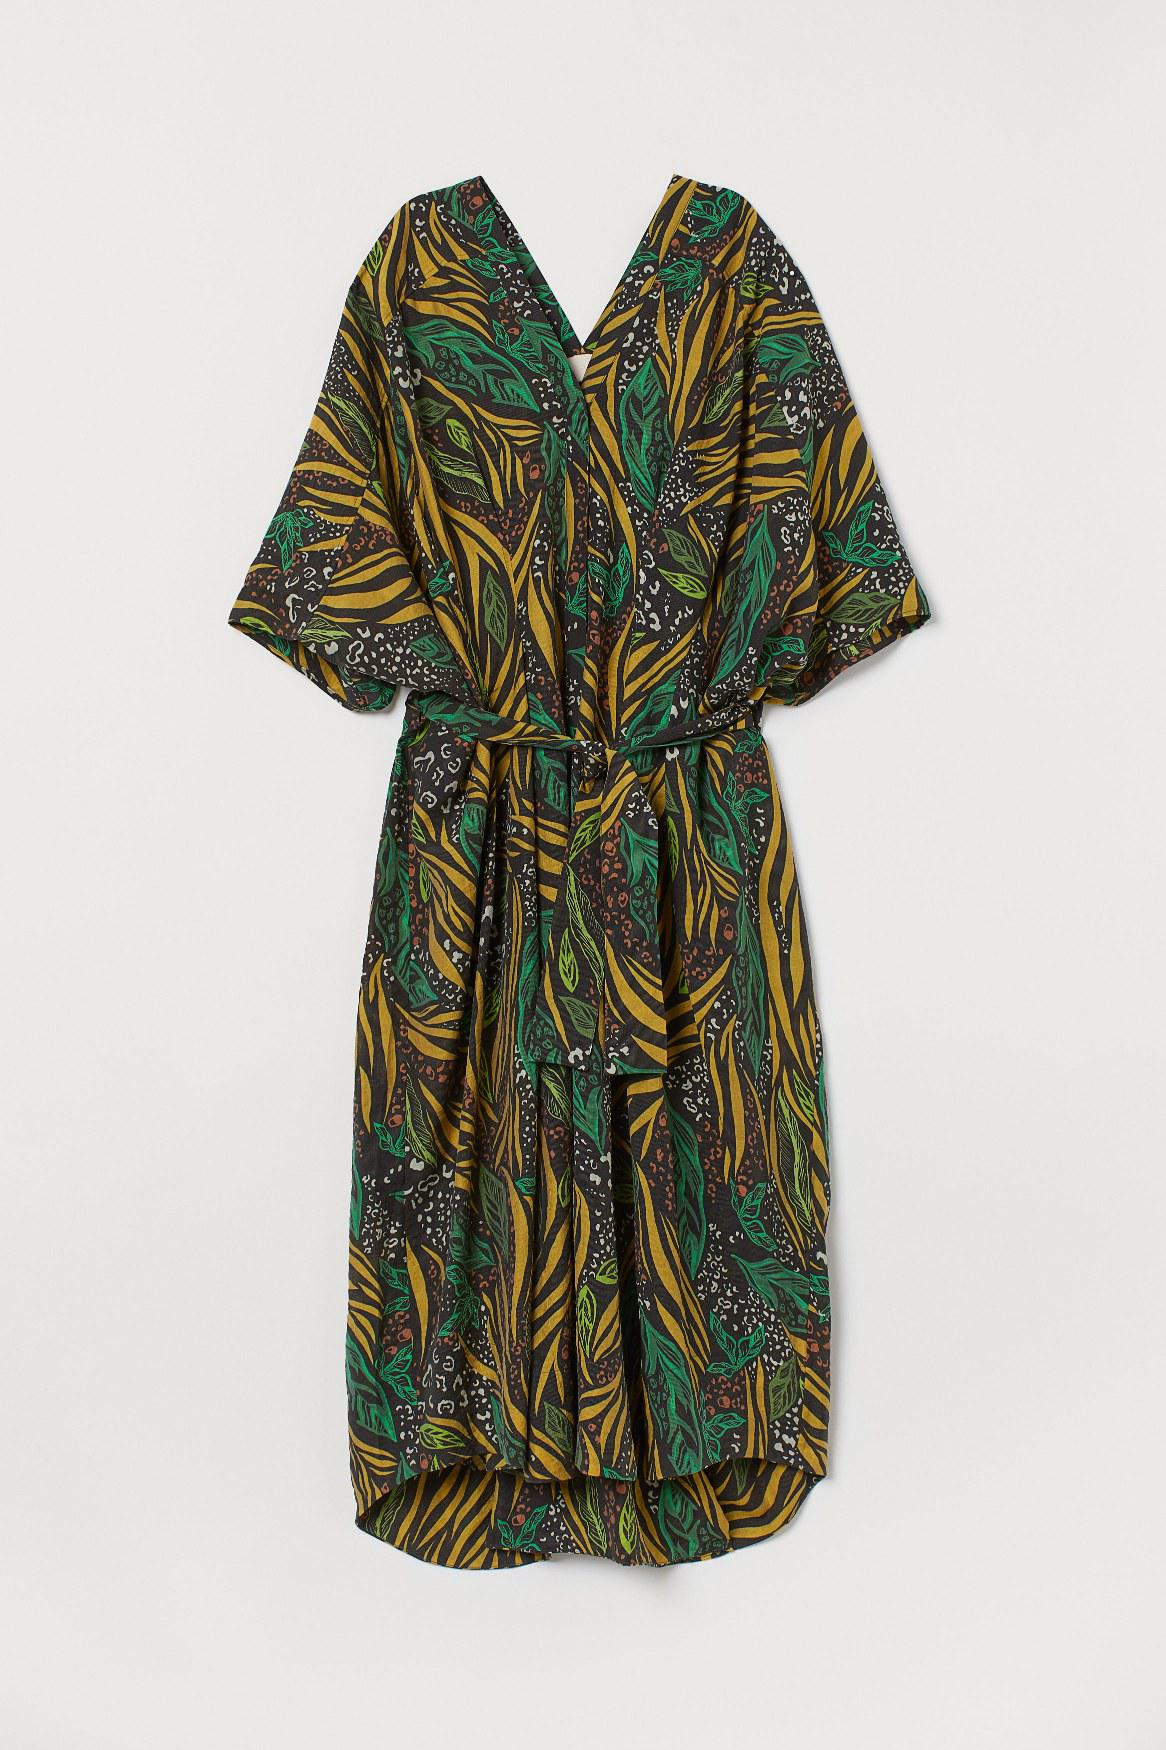
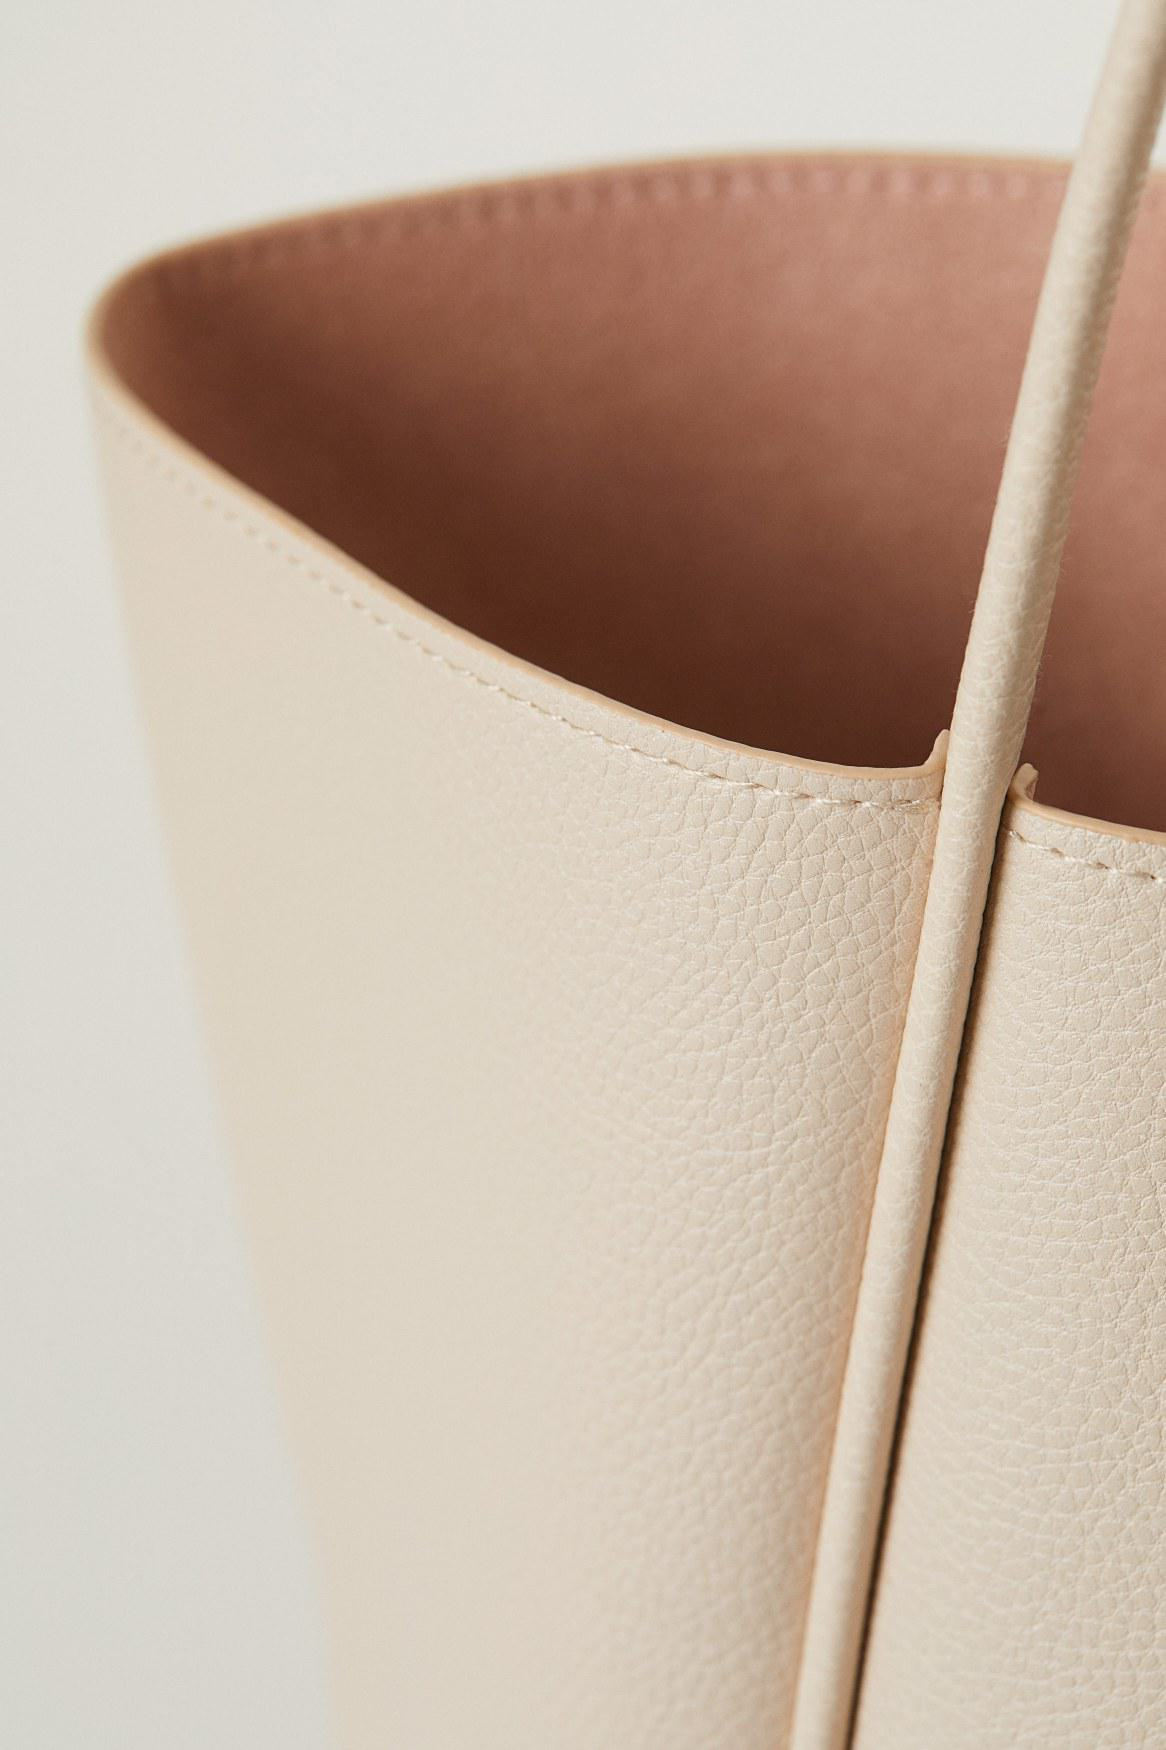
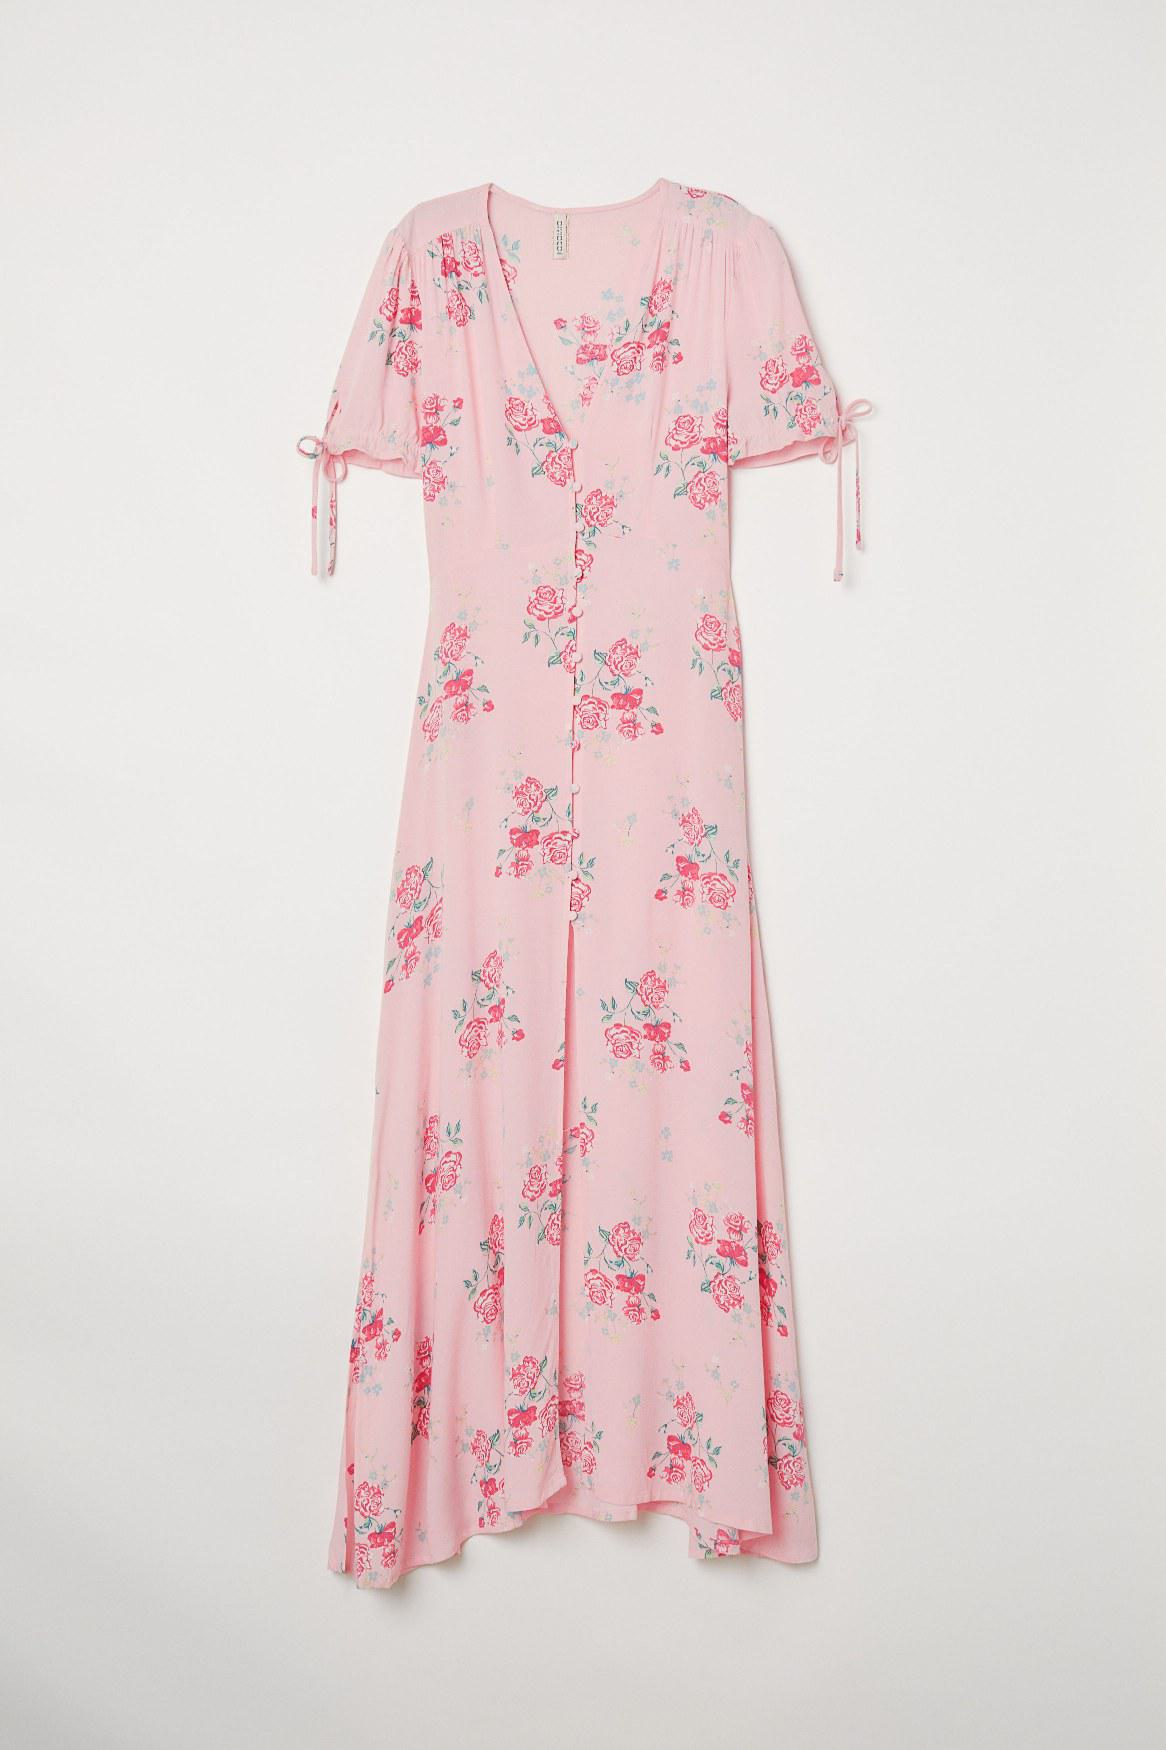
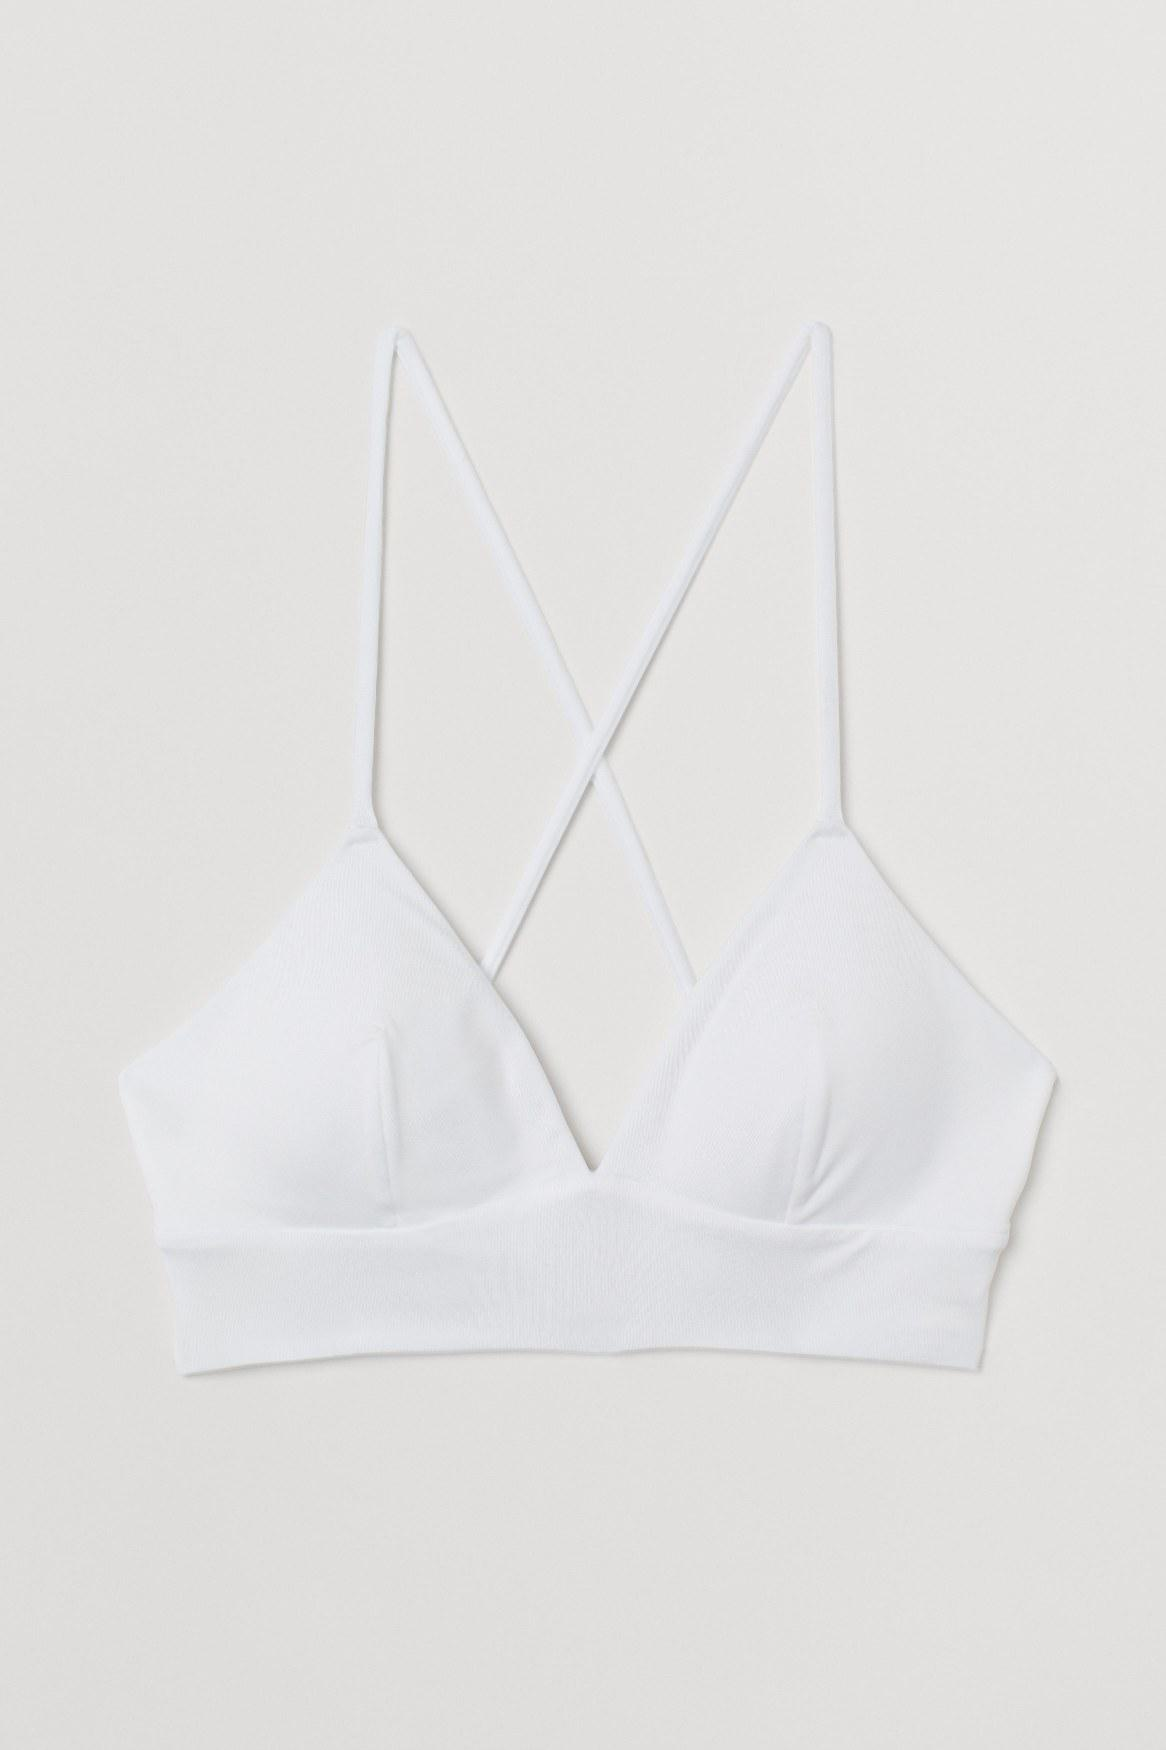

In [179]:
# Plot the product image in the dataframe alongside the predicted class and actual product category

pd.set_option('display.max_colwidth', -1)


def image_base64(im):
    if isinstance(im, str):
        im = Image.open(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'


def display_images(df, image_col):
    return HTML(df.to_html(formatters={image_col: image_formatter}, escape=False))
    

def get_image_path(article_id):
    article_id = '0' + str(article_id)
    return f'/Users/pandabear/springboard/H_and_M_product_category_classification/data/raw/{article_id[:3]}/{article_id}.jpg'


# Only display a small number of rows otherwise image processing is too slow.
incorrect_labels_info_sample = incorrect_labels_info.sort_values('predicted_label_confidence', ascending=False)[:10]
incorrect_labels_info_sample['image'] = incorrect_labels_info_sample.index.map(get_image_path)
display_images(incorrect_labels_info_sample, 'image')

Looking at the examples of misclassified products suggests the product category labels are wrong for some of the rows, e.g. looking at the title, description and image the first product should be a sweater and not a dress. 
Other examples such as hat but was classified as accessories are not too far off, but the original label is still incorrect. 

Shorts are often labeled as Trousers in the dataset even though the product title has the word `shorts` which should be corrected. The model struggles to classify `full length`, which is one of the harder ones to classify since the title and description often does not say it is a 2 piece or full length, but will have the number 2 or the word `set` or `playsuit`.
   
This image classification model struggles to identify items when shown in boxed packaging e.g. instead of an image of socks, a pair of socks in a box is shown and the model classifies it as `accessories`. 

PJs are also often labeled as t-shirt or trousers because of the image, but the title has the word `PJ`, which should improve in the next model when product title is included as a feature.

Other areas this model where this model is struggling:
    -close up pictures instead of the entire product are likely to be misclassified
    -kids trousers are labeled as shorts, probably because of the proportion of the leg length.
   
These incorrect product category labels will be spot checked and manually corrected, but for now it is good to see that model is actually performing better than the classification matrix shown. 

### 2. Product title embeddings only 

In [148]:
X_train_2.head()

_fancy  _ls  _hw  _ss  _tee  _slim  _dress  _price  _basic  \
article_id                                                               
108775015   0       0    0    0    0     0      0       0       0        
108775044   0       0    0    0    0     0      0       0       0        
108775051   0       0    0    0    0     0      0       0       0        
145872001   0       0    0    0    0     0      0       0       1        
145872037   0       0    0    0    0     0      0       0       1        

            _denim  ...  _round  _trim  _print  _washed  _loop  _functional  \
article_id          ...                                                       
108775015   0       ...  0       0      0       0        0      0             
108775044   0       ...  0       0      0       0        0      0             
108775051   0       ...  0       0      0       0        0      0             
145872001   0       ...  0       0      0       0        0      1             
145872037   0       ...  0       0      0       0        0      1             

            _buttoned  _slits  _mesh  _welt  
article_id                                   
108775015   0          0       0      0      
108775044   0          0       0      0      
108775051   0          0       0      0      
145872001   0          0       0      0      
145872037   0          0       0      0      

[5 rows x 172 columns]

In [149]:
sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC, cv=5, random_state=0)

sgdc_model.fit(X_train_2, y_train)
best_model = sgdc_model.best_estimator_
y_pred_2 = best_model.predict(X_test_2)

sgdc_model_2 = classification_report(y_test, y_pred_2, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [150]:
sgdc_model_2['weighted avg']['f1-score']

0.8255671858750333

Text(0.5, 1.0, 'Confusion Matrix for product title features only')

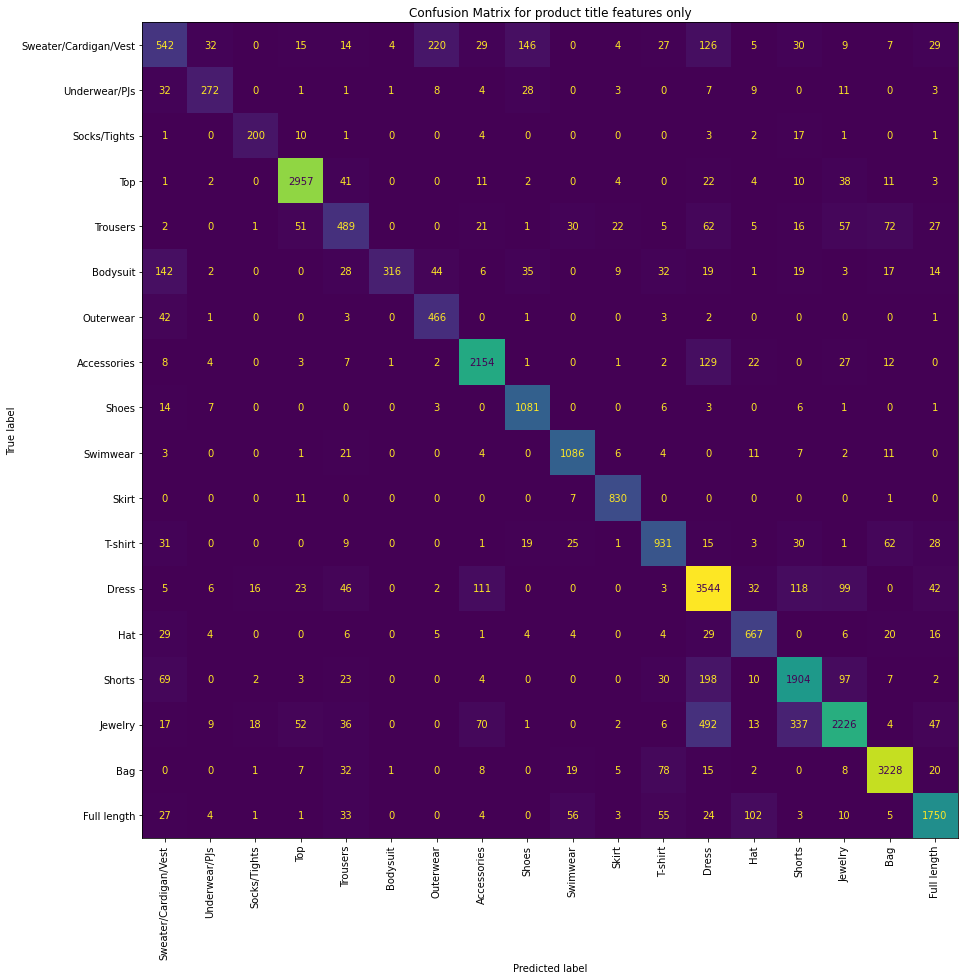

In [173]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_2,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for product title features only")

### 3. Product title + product description embeddings only 


In [151]:

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC, cv=5, random_state=0)

sgdc_model.fit(X_train_3, y_train)
best_model = sgdc_model.best_estimator_
y_pred_3 = best_model.predict(X_test_3)

sgdc_model_3 = classification_report(y_test, y_pred_3, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [152]:
sgdc_model_3['weighted avg']['f1-score']

0.8315863513960282

Text(0.5, 1.0, 'Confusion Matrix for product title and description features only')

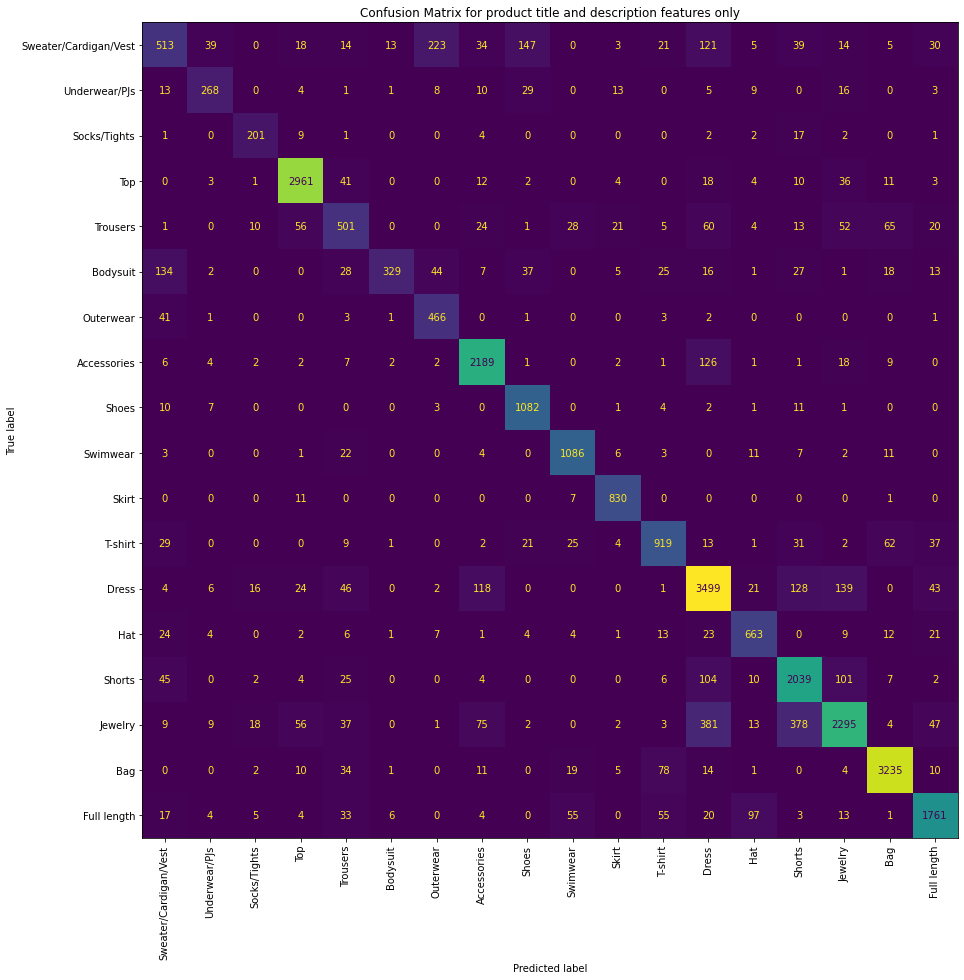

In [174]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_3,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for product title and description features only")

This is performing similar to the product titles only model, with a number of sweater/cardigan/vest, dress, and shorts misclassified. 

### 4. Product title + Image classification

In [153]:
# Create a dataset with product titles and image embeddings
X_train_title_image = pd.concat([X_train_2, X_train_image], axis=1)
X_test_title_image = pd.concat([X_test_2, X_test_image], axis=1)
X_train_title_image.head()

_fancy  _ls  _hw  _ss  _tee  _slim  _dress  _price  _basic  \
article_id                                                               
108775015   0       0    0    0    0     0      0       0       0        
108775044   0       0    0    0    0     0      0       0       0        
108775051   0       0    0    0    0     0      0       0       0        
145872001   0       0    0    0    0     0      0       0       1        
145872037   0       0    0    0    0     0      0       0       1        

            _denim  ...       502       503       504       505       506  \
article_id          ...                                                     
108775015   0       ...  0.283601  0.502333  0.815049  0.183200  1.749047   
108775044   0       ...  0.369955  0.305547  0.750164  0.278698  3.498078   
108775051   0       ...  0.673954  1.023912  1.220658  0.990421  0.603554   
145872001   0       ...  1.096645  0.235036  0.088652  0.355652  5.857070   
145872037   0       ...  0.883630  0.394170  0.461126  1.258459  5.701306   

                 507       508       509       510       511  
article_id                                                    
108775015   1.393814  0.003090  3.470509  0.953905  1.414786  
108775044   1.059729  0.080655  0.457405  0.473151  1.298293  
108775051   1.449252  0.105316  2.191562  2.410787  0.329729  
145872001   0.804569  0.092536  0.340698  0.323110  1.655938  
145872037   1.189615  0.281143  0.690465  0.089672  1.439759  

[5 rows x 684 columns]

In [154]:
print(X_train_title_image.shape)
print(len(y_train))
print(X_test_title_image.shape)
print(len(y_test))

(69224, 684)
69224
(29711, 684)
29711


In [155]:
param_SGDC_4 = {
            'penalty':['l2'],
            'alpha':[1e-3, 1e-2, 1e-1],
            'max_iter':[2000],
            'n_jobs': [-1]
            }

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC_4, cv=5, random_state=0)

sgdc_model.fit(X_train_title_image, y_train)
best_model = sgdc_model.best_estimator_
y_pred_4 = best_model.predict(X_test_title_image)

sgdc_model_4 = classification_report(y_test, y_pred_4, output_dict=True)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix for Product title and image classification features')

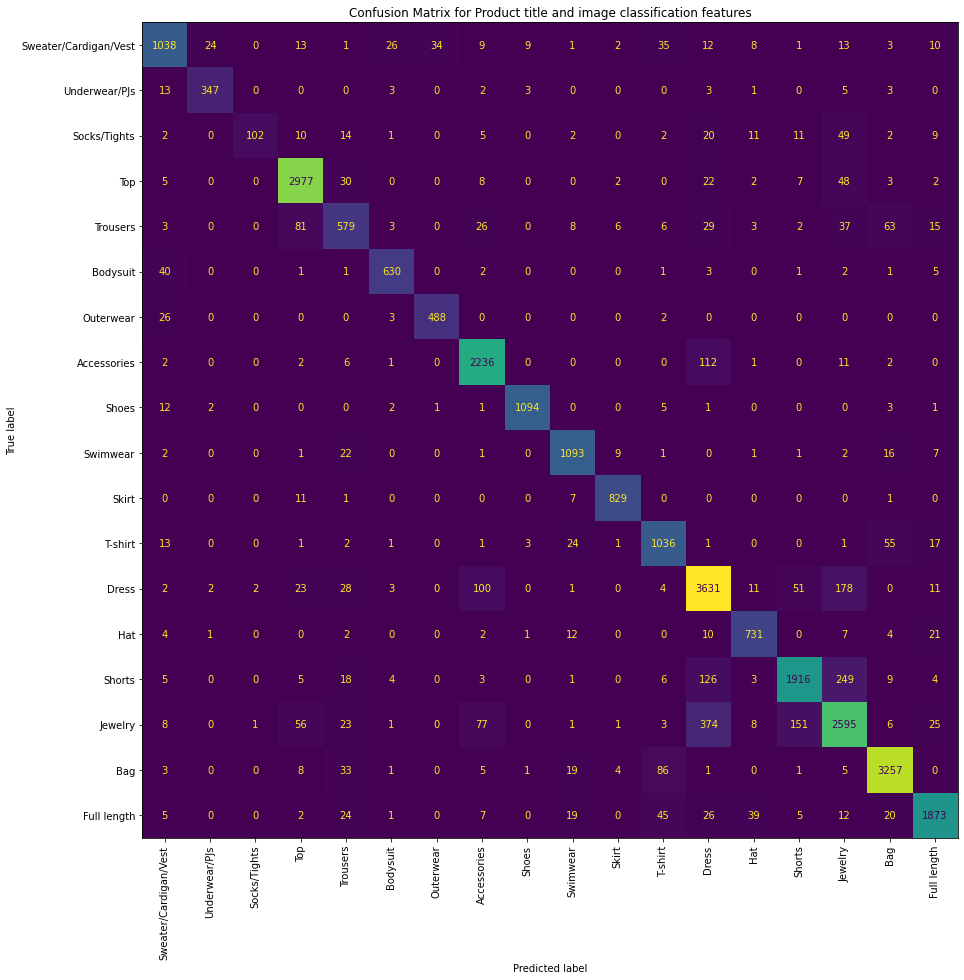

In [156]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_4,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for Product title and image classification features")

The top performing product categories are:
- Trousers, shoes, skirt, outerwear, sweater/cardigan/vest, Top, t-shirt, dress

This heatmap shows that there are some classes that perform worse:
- The top incorrect labels are Accessories, Shorts, Jewelry, Dress

### 5. Product title + product description + Image classification

In [158]:
X_train_full.head()

0         1         2         3         4         5  \
article_id                                                               
108775015   1.671856  0.076411  1.992960  0.515366  0.087093  0.499538   
108775044   0.317337  0.022370  0.790894  0.184620  0.122858  0.215203   
108775051   0.972625  0.119625  2.423473  1.054603  0.002196  1.429509   
145872001   0.352032  0.036019  0.208536  1.069184  0.095426  0.349860   
145872037   0.514889  0.155787  0.148822  0.172575  0.082710  0.406160   

                   6         7         8         9  ...  _round  _trim  \
article_id                                          ...                  
108775015   0.125408  0.519581  0.692295  0.194752  ...  0       0       
108775044   0.008712  0.393076  0.475337  0.341774  ...  0       0       
108775051   0.087665  1.118197  0.183544  0.195096  ...  0       0       
145872001   0.782672  0.327280  0.241861  0.285968  ...  0       0       
145872037   1.001948  0.460893  0.465420  0.301038  ...  0       0       

            _print  _washed  _loop  _functional  _buttoned  _slits  _mesh  \
article_id                                                                  
108775015   0       0        0      0            0          0       0       
108775044   0       0        0      0            0          0       0       
108775051   0       0        0      0            0          0       0       
145872001   0       0        0      1            0          0       0       
145872037   0       0        0      1            0          0       0       

            _welt  
article_id         
108775015   0      
108775044   0      
108775051   0      
145872001   0      
145872037   0      

[5 rows x 684 columns]

In [159]:
X_test_full.head()

0         1         2         3         4         5  \
article_id                                                               
112679048   1.222298  0.615706  0.468774  0.278907  0.051020  0.371239   
112679052   0.849320  0.005533  0.210697  0.409732  0.074123  0.642070   
194270002   1.620172  0.140583  0.715644  1.140085  0.141574  0.181567   
194270044   0.320825  0.479506  0.718964  0.042605  0.000000  0.081761   
194270045   1.010420  0.091721  2.454683  0.907387  0.221087  0.308097   

                   6         7         8         9  ...  _round  _trim  \
article_id                                          ...                  
112679048   0.299273  0.229687  0.255918  0.202568  ...  0       0       
112679052   1.199575  0.632329  0.471781  0.185745  ...  0       0       
194270002   0.266037  0.105068  0.432356  0.120942  ...  0       0       
194270044   0.623028  0.474288  1.167822  0.400388  ...  0       0       
194270045   0.050207  0.172918  0.420462  0.104838  ...  0       0       

            _print  _washed  _loop  _functional  _buttoned  _slits  _mesh  \
article_id                                                                  
112679048   0       0        0      0            0          0       0       
112679052   0       0        0      0            0          0       0       
194270002   0       0        0      0            0          0       0       
194270044   0       0        0      0            0          0       0       
194270045   0       0        0      0            0          0       0       

            _welt  
article_id         
112679048   0      
112679052   0      
194270002   0      
194270044   0      
194270045   0      

[5 rows x 684 columns]

In [160]:
param_SGDC_5 = {
            'penalty':['l2'],
            'alpha':[1e-3, 1e-2, 1e-1],
            'max_iter':[2000],
            'n_jobs': [-1]
            }

sgdc_model = RandomizedSearchCV(SGDClassifier(), param_distributions=param_SGDC_5, cv=5, random_state=0)

sgdc_model.fit(X_train_full, y_train)
best_model = sgdc_model.best_estimator_
y_pred = best_model.predict(X_test_full)

sgdc_model_5 = classification_report(y_test, y_pred, output_dict=True)
sgdc_model_5

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'Accessories': {'precision': 0.6986552567237164,
  'recall': 0.9225181598062954,
  'f1-score': 0.7951304347826087,
  'support': 1239},
 'Bag': {'precision': 0.9266304347826086,
  'recall': 0.8973684210526316,
  'f1-score': 0.9117647058823529,
  'support': 380},
 'Bodysuit': {'precision': 0.8983957219251337,
  'recall': 0.7,
  'f1-score': 0.7868852459016393,
  'support': 240},
 'Dress': {'precision': 0.9518889247659025,
  'recall': 0.9491307147456536,
  'f1-score': 0.9505078187973561,
  'support': 3106},
 'Full length': {'precision': 0.7503168567807351,
  'recall': 0.6875725900116144,
  'f1-score': 0.7175757575757576,
  'support': 861},
 'Hat': {'precision': 0.9503105590062112,
  'recall': 0.8908296943231441,
  'f1-score': 0.9196093163035312,
  'support': 687},
 'Jewelry': {'precision': 0.9118198874296435,
  'recall': 0.9364161849710982,
  'f1-score': 0.923954372623574,
  'support': 519},
 'Outerwear': {'precision': 0.8918811881188119,
  'recall': 0.9490096923725242,
  'f1-score': 0.91

In [161]:
sgdc_model_5['weighted avg']['f1-score']

0.8897056072579401

Text(0.5, 1.0, 'Confusion Matrix for Product title, description, image classification features')

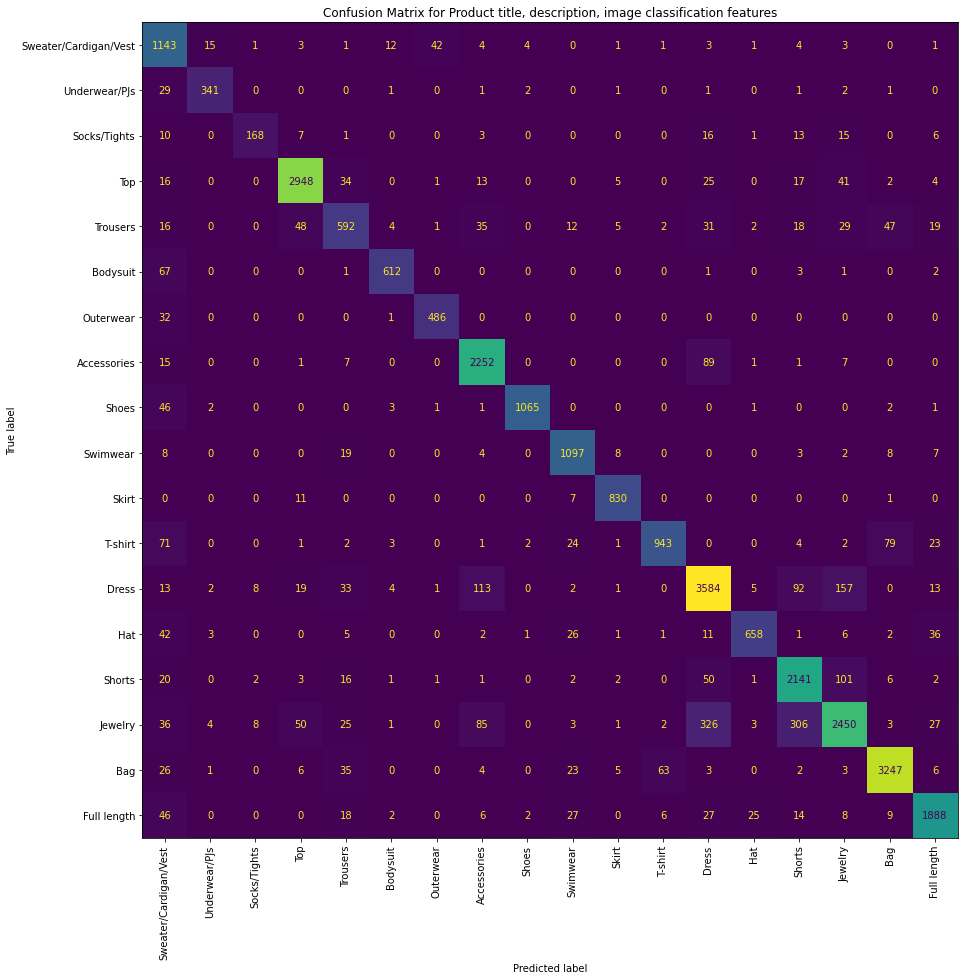

In [162]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for Product title, description, image classification features")

These results look similar to the product title + image classification

The top performing product categories are:
- Trousers, shoes, skirt, outerwear, t-shirt, Top, dress

This heatmap shows that there are some classes that perform worse:
- Dress and Jewelery seem to be confused for each other

In [163]:
# Create a table summarizing the metrics for each SDGC variant
sgdc_results = {'features':['Image','Product title','Product title + product description','Product title + Image classification','Product title + product description + image'],
               'weighted avg f1-score':[sgdc_model_1['weighted avg']['f1-score'],sgdc_model_2['weighted avg']['f1-score'],sgdc_model_3['weighted avg']['f1-score'],sgdc_model_4['weighted avg']['f1-score'],sgdc_model_5['weighted avg']['f1-score']]}

sgdc_results = pd.DataFrame(sgdc_results)
sgdc_results


features  weighted avg f1-score
0  Image                                        0.748600             
1  Product title                                0.825567             
2  Product title + product description          0.831586             
3  Product title + Image classification         0.889079             
4  Product title + product description + image  0.889706

These combinations shows that classification using image only performs the worst. 
Product title performs about the same as product title + description and that product description doesnt add much additional information to the model. 

Product title + description + images performs the same as title + images, so to simplify the model and reduce dimensionality, drop the description features. 

Subsequent models will use product title and image embeddings only.

In [164]:
lab = LabelEncoder()

#perform label encoding on 'team' column
y_train_encoded = lab.fit_transform(y_train)
y_test_encoded = lab.transform(y_test)
y_test_encoded


array([12, 12, 12, ...,  4,  4,  4])

In [165]:
y_train_encoded

array([12, 12, 12, ...,  4,  4,  4])

In [257]:
# Save X_train_title_image, X_test_title_image, y_train_encoded, y_test_encoded

# path1 = '/Users/pandabear/springboard/H_and_M_product_category_classification/notebooks/'
# X_train_title_image.to_csv(path1 + 'X_train_title_image.csv')
# X_test_title_image.to_csv(path1 + 'X_test_title_image.csv')

# import pickle
# pickle.dump(y_train_encoded, open(path1 + 'y_train_encoded.pkl', 'wb'))
# pickle.dump(y_test_encoded, open(path1 + 'y_test_encoded.pkl', 'wb'))
# print('Saved to file')

Saved to file


# Random Forest

In [166]:
from sklearn.ensemble import RandomForestClassifier

time_start = time.time()

param_grid = {
    "n_estimators": [200, 300],
#     "max_depth": [3, 5, 10, 20],
    "min_samples_leaf": [1, 2],
    'warm_start':[True]
}

rf_model = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), param_distributions=param_grid, cv=5, verbose=0, n_jobs=-1)

rf_model.fit(X_train_title_image, y_train_encoded)

best_rf_model = rf_model.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_title_image)

/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [167]:
print(time.time() - time_start)

9743.242377281189


In [168]:
rf_model.best_params_

{'warm_start': True, 'n_estimators': 300, 'min_samples_leaf': 1}

In [169]:
print(classification_report(y_test_encoded, y_pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1239
           1       0.93      0.83      0.88       380
           2       0.94      0.42      0.58       240
           3       0.89      0.97      0.93      3106
           4       0.78      0.40      0.53       861
           5       0.96      0.89      0.92       687
           6       0.91      0.91      0.91       519
           7       0.92      0.89      0.91      2373
           8       0.97      0.98      0.97      1122
           9       0.89      0.93      0.91      1156
          10       0.98      0.97      0.97       849
          11       0.90      0.74      0.81      1156
          12       0.80      0.89      0.84      4047
          13       0.90      0.78      0.84       795
          14       0.85      0.84      0.84      2349
          15       0.79      0.76      0.77      3330
          16       0.90      0.97      0.93      3424
          17       0.89    

Text(0.5, 1.0, 'Confusion Matrix for Product title, image classification features')

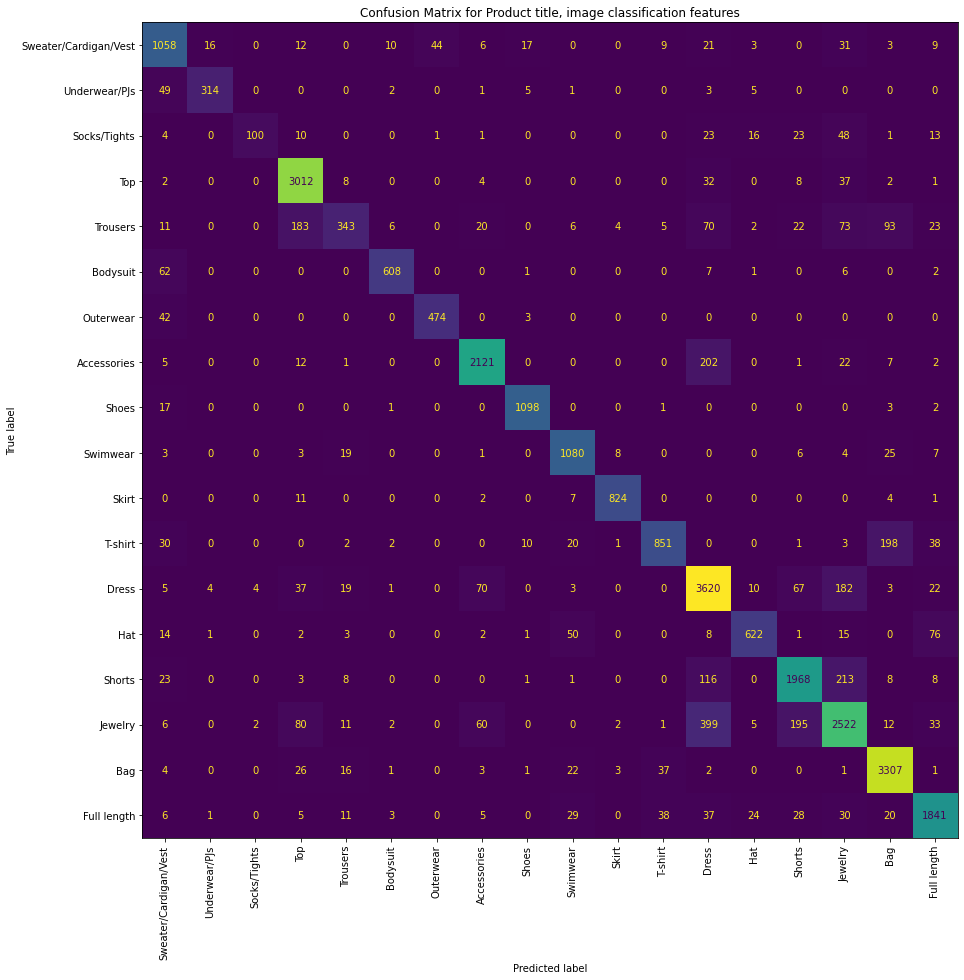

In [170]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test_encoded,
        y_pred_rf,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for Product title, image classification features")

Comparing the Random Forest model to the SGDC model, for the Random Forest model:

- Trousers are being misclassified for Tops
- T-shirt class is misclassified for Bag
- Dress is misclassified for Accessories less


In [171]:
# Convert y_pred_rf into non encoded format for easy comparison
y_pred_rf_nonencoded = lab.inverse_transform(y_pred_rf)

# Create a dataframe of only incorrect labels
rf_incorrect_labels_idx = X_test_title_image[y_test != y_pred_rf_nonencoded].index
rf_incorrect_labels_info = df.loc[rf_incorrect_labels_idx][['prod_name','detail_desc','product_type_name']]
rf_incorrect_labels_info['predicted_label'] = y_pred_rf_nonencoded[y_test != y_pred_rf_nonencoded]

/var/folders/5_/87js___11b5312gjj36qhf_m0000gn/T/ipykernel_6164/2749908985.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rf_incorrect_labels_info_subset['image'] = rf_incorrect_labels_info_subset.index.map(get_image_path)



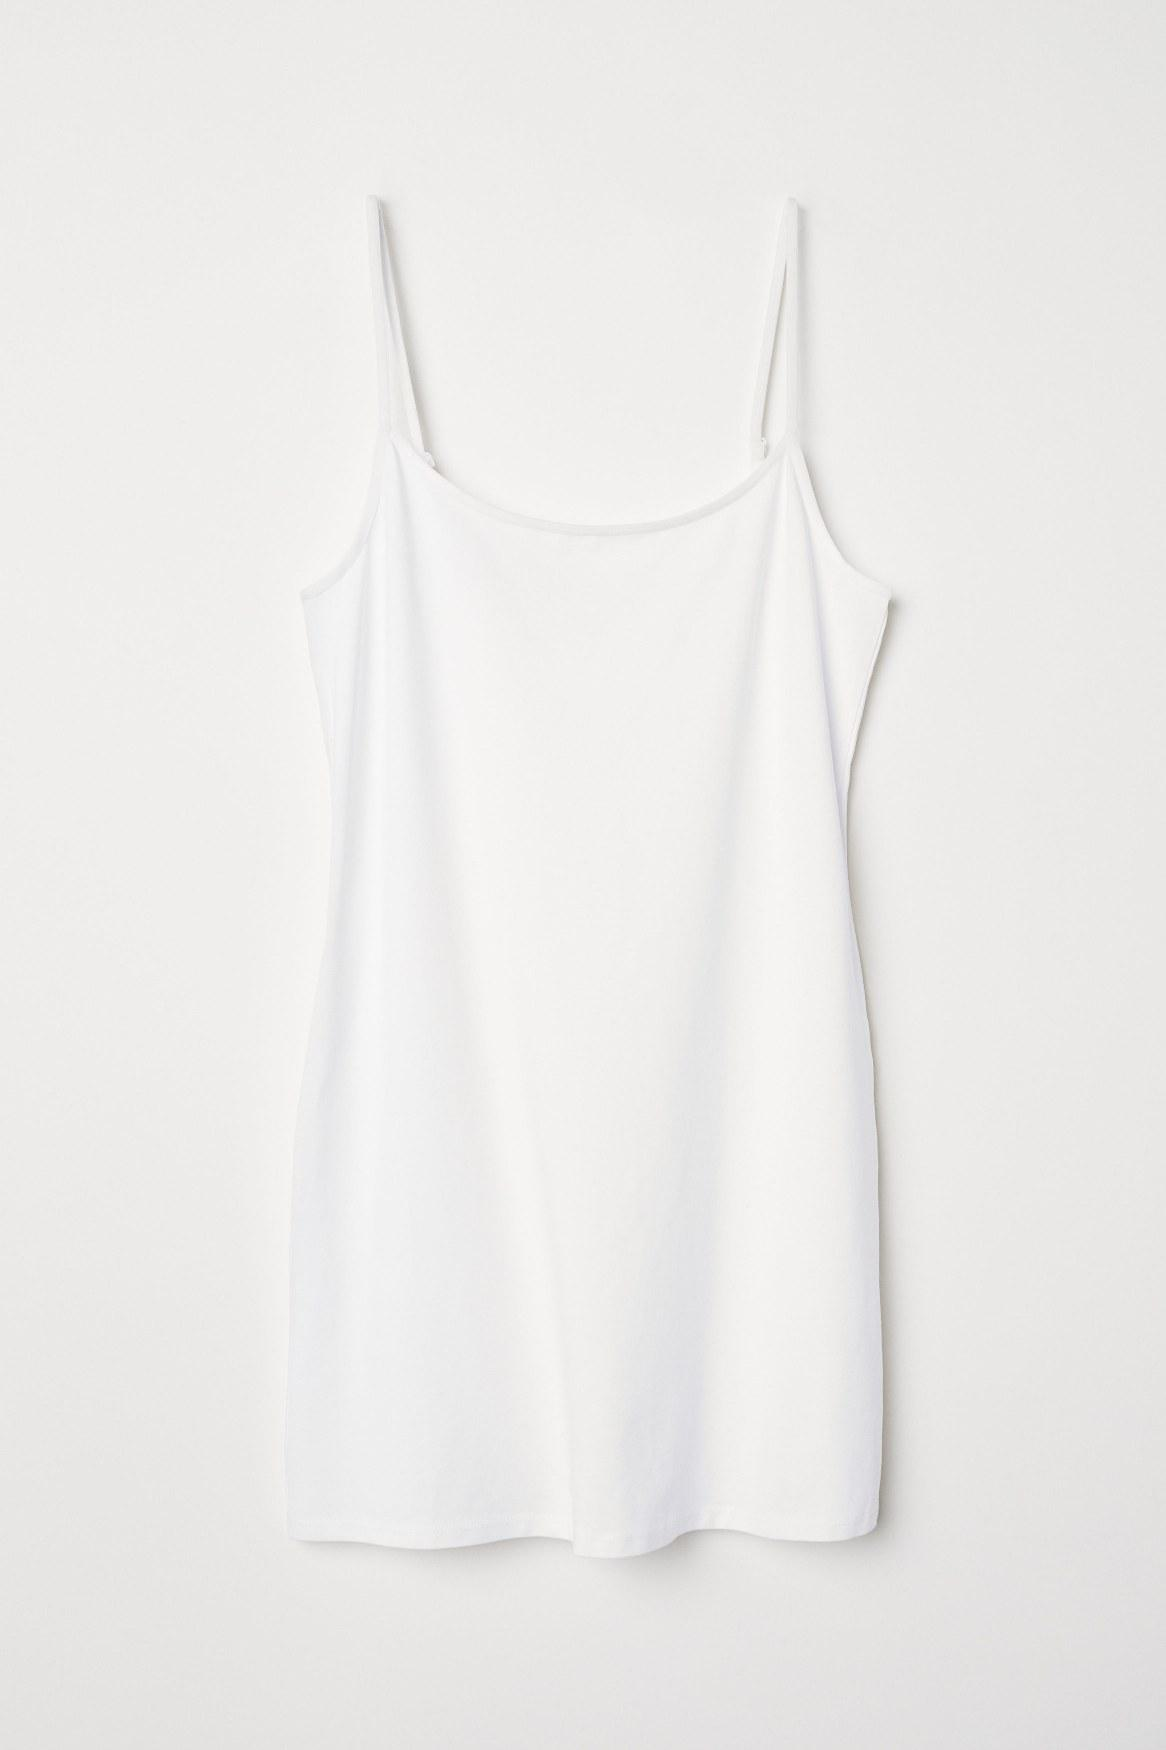
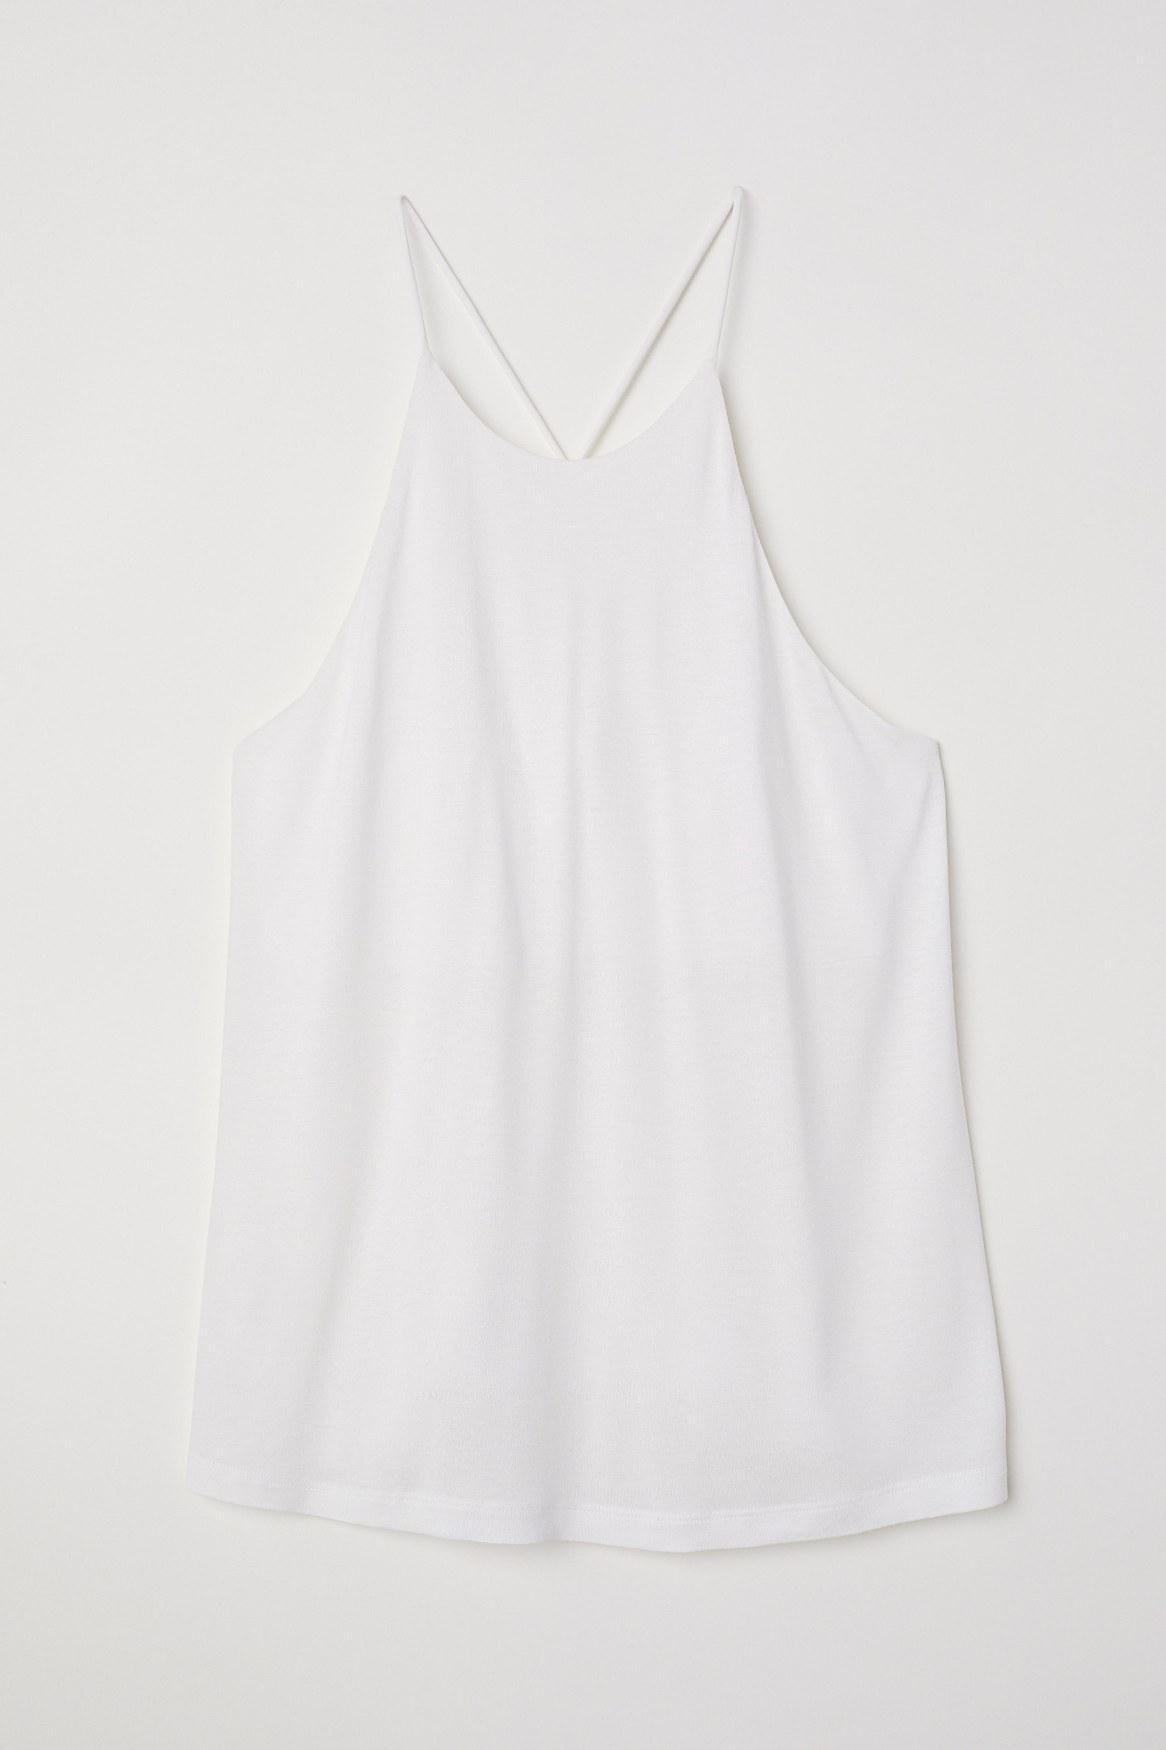
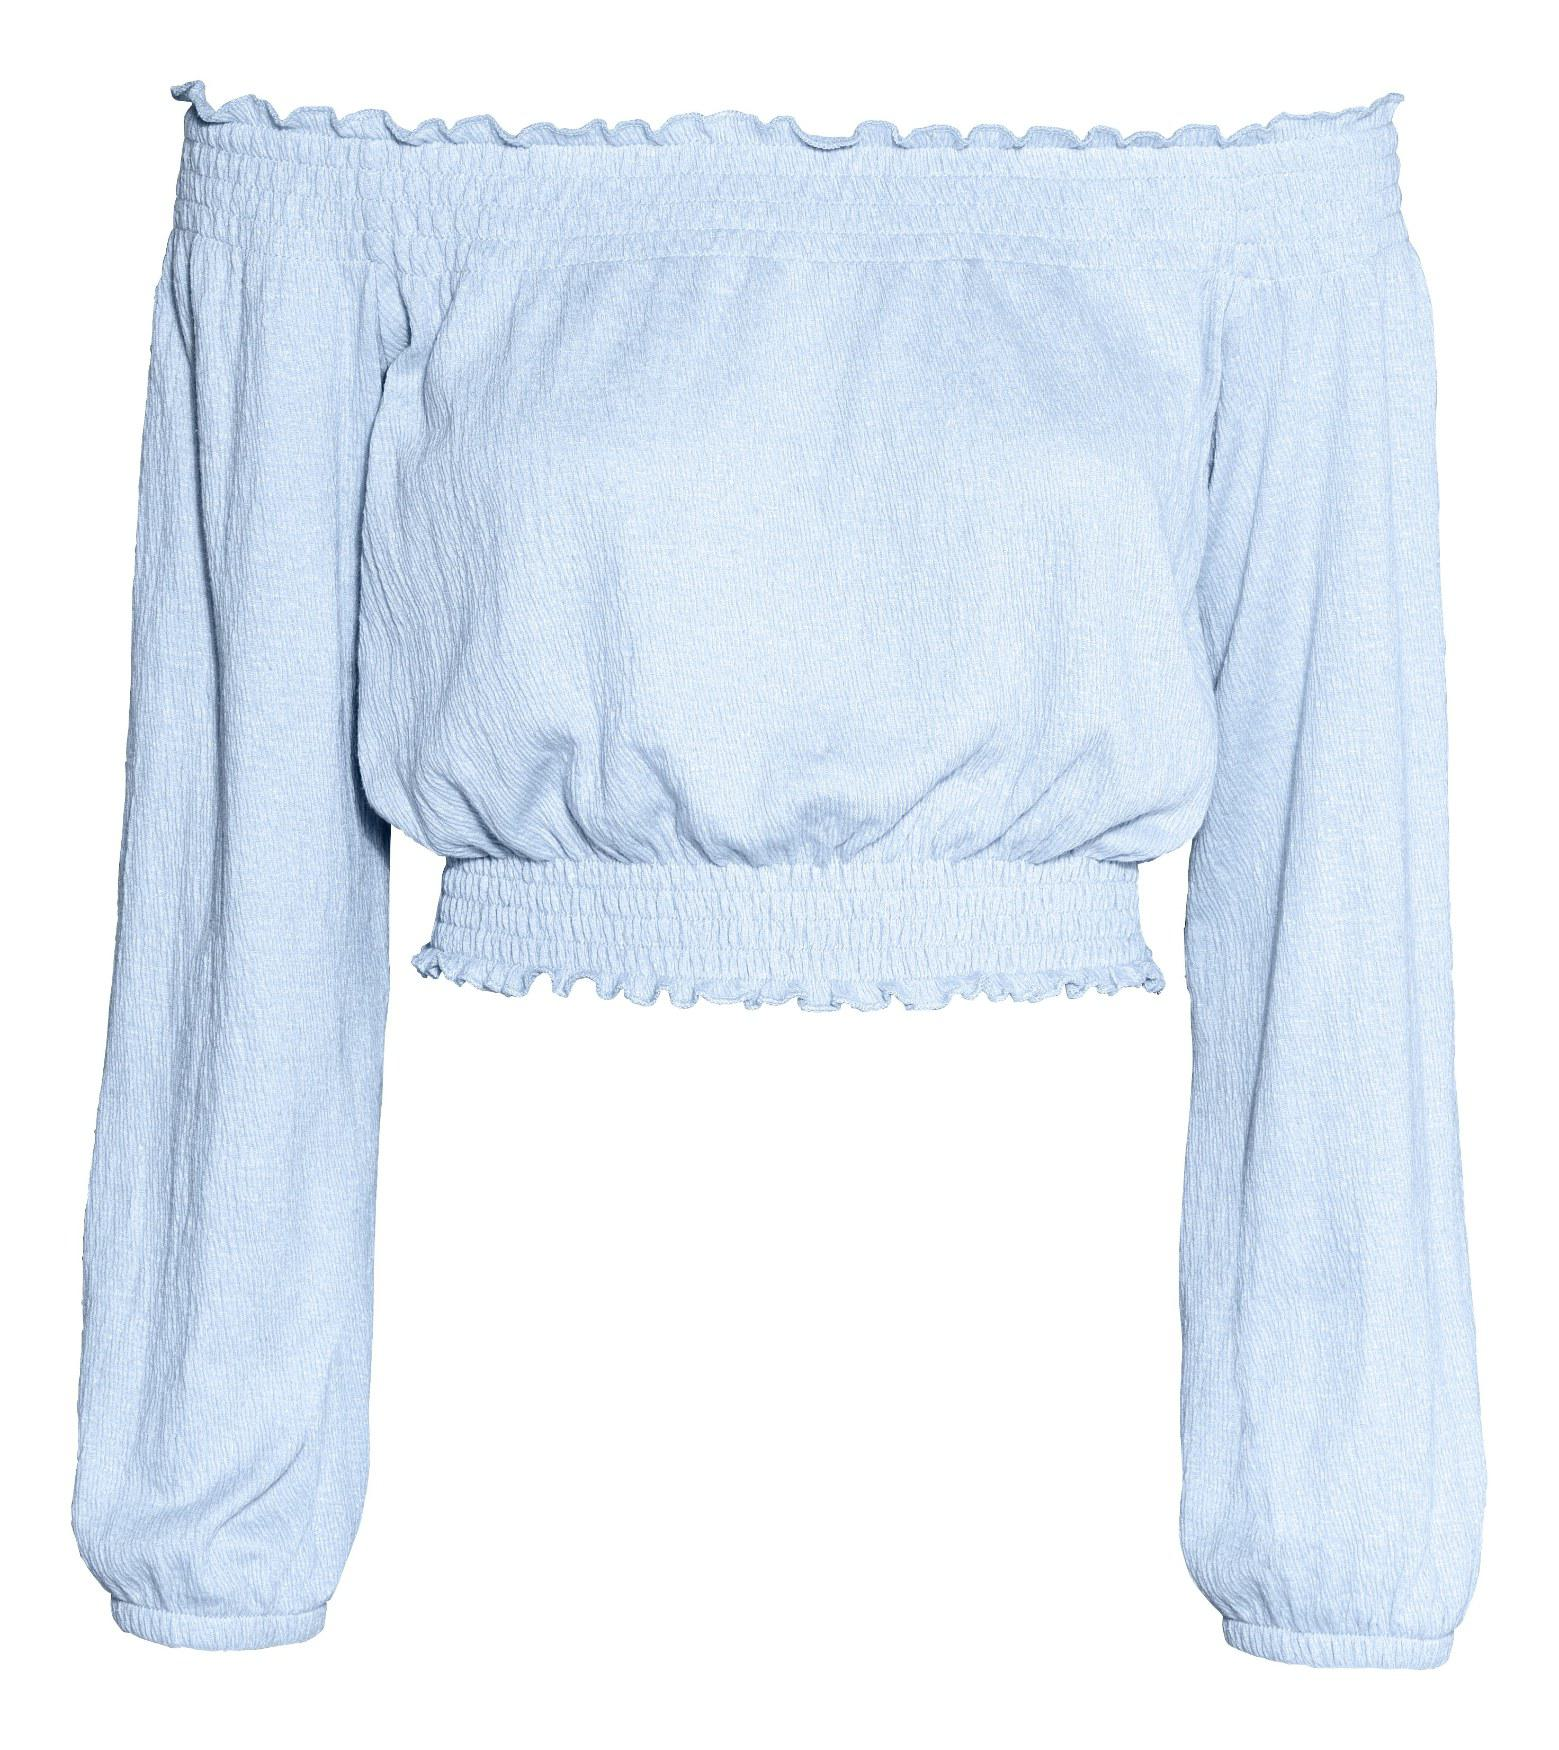
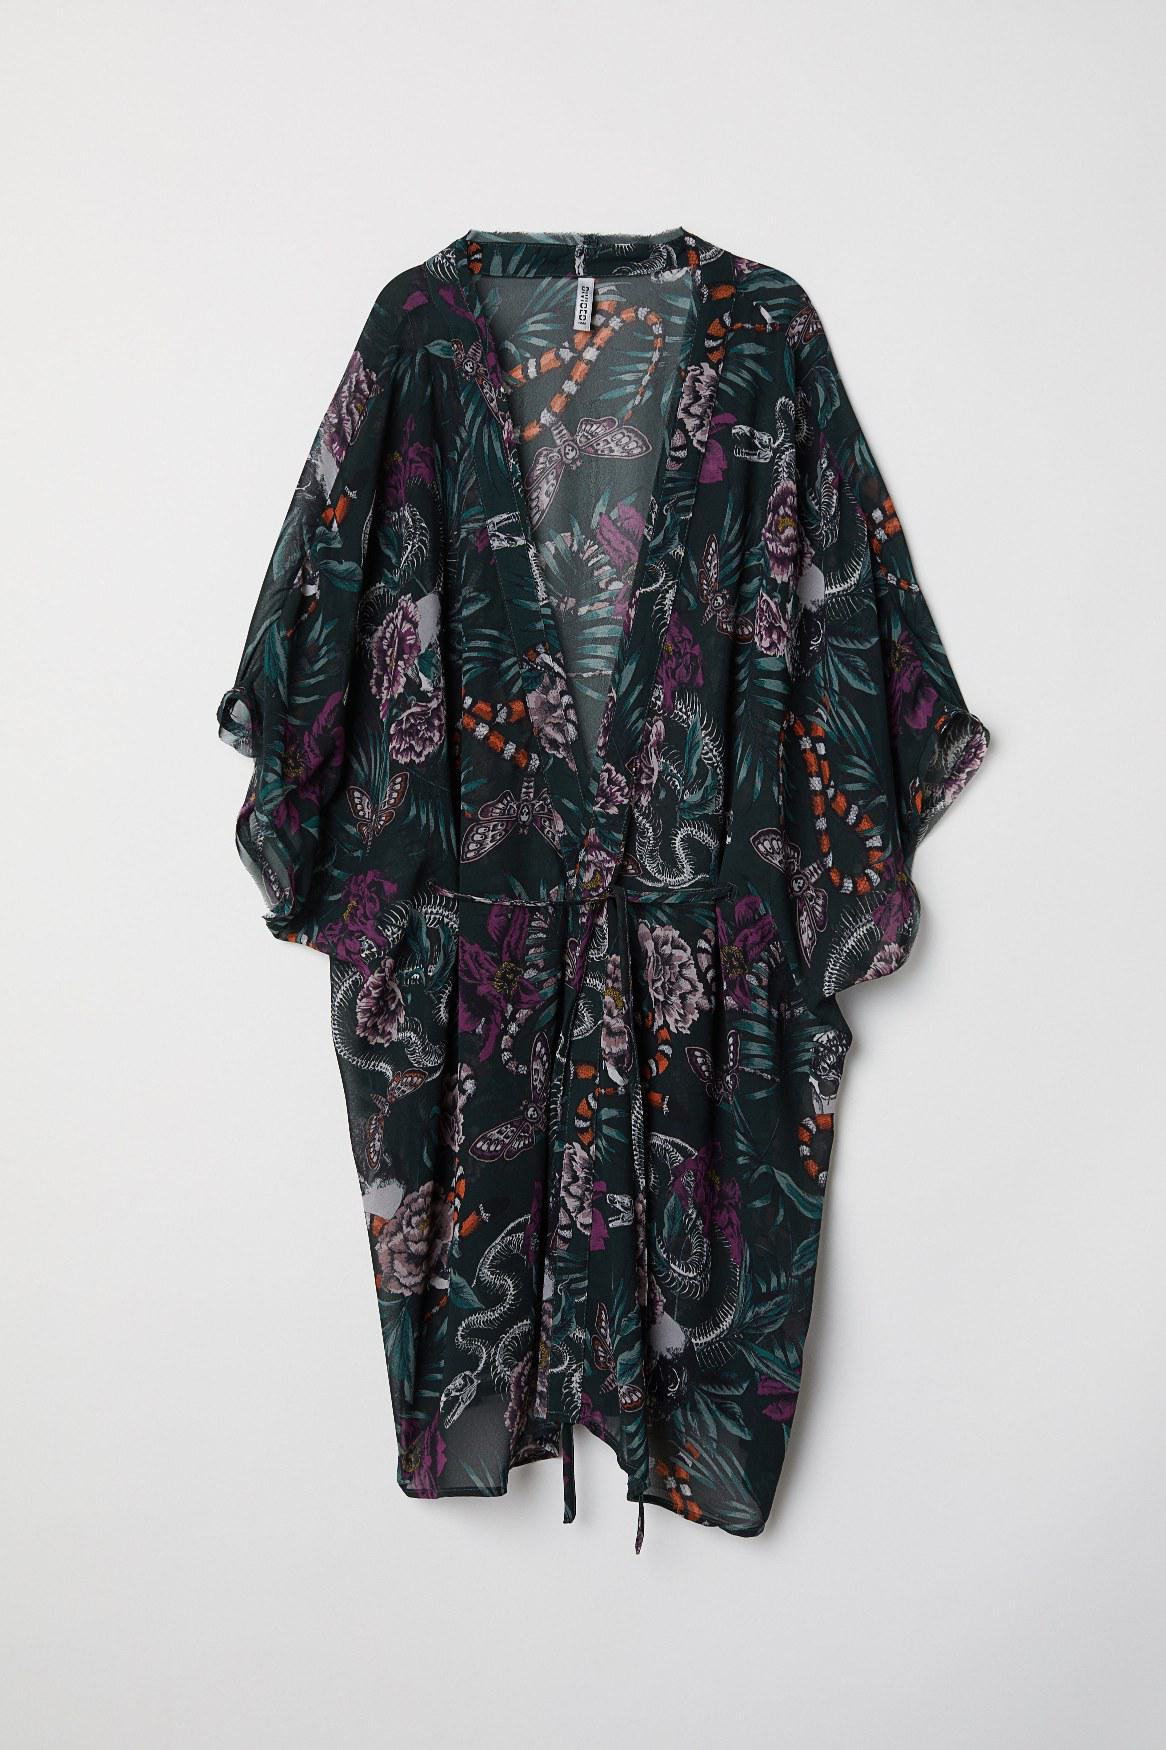
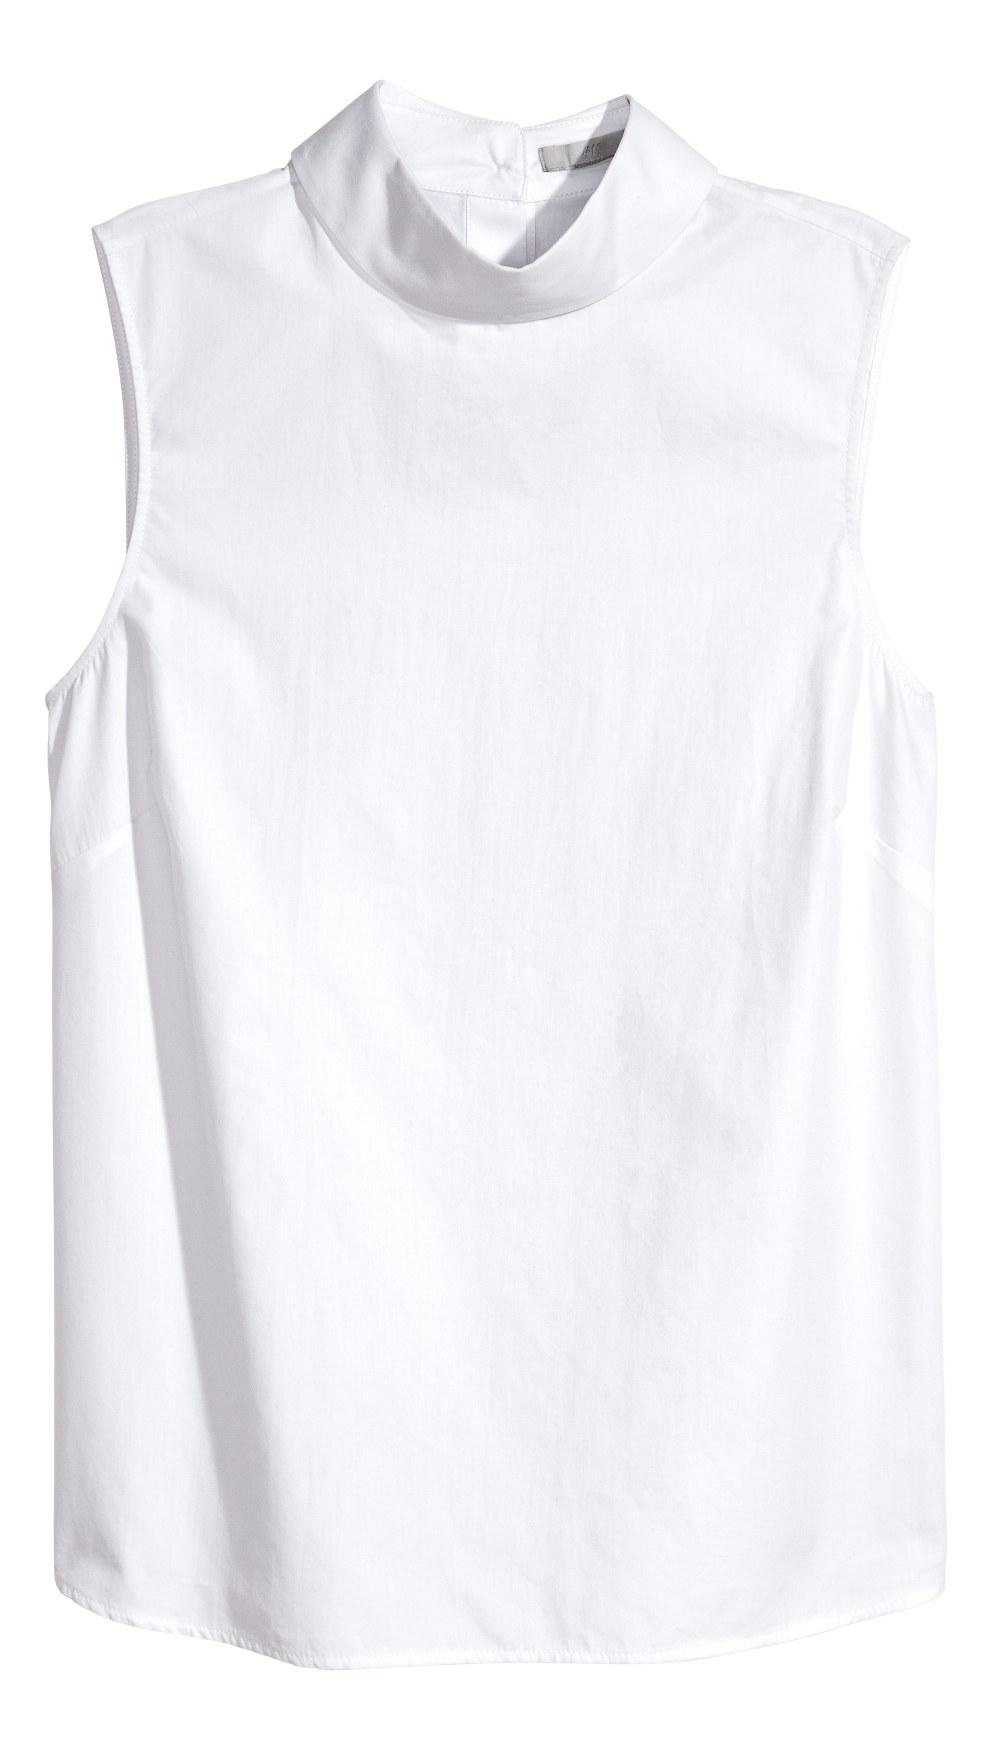
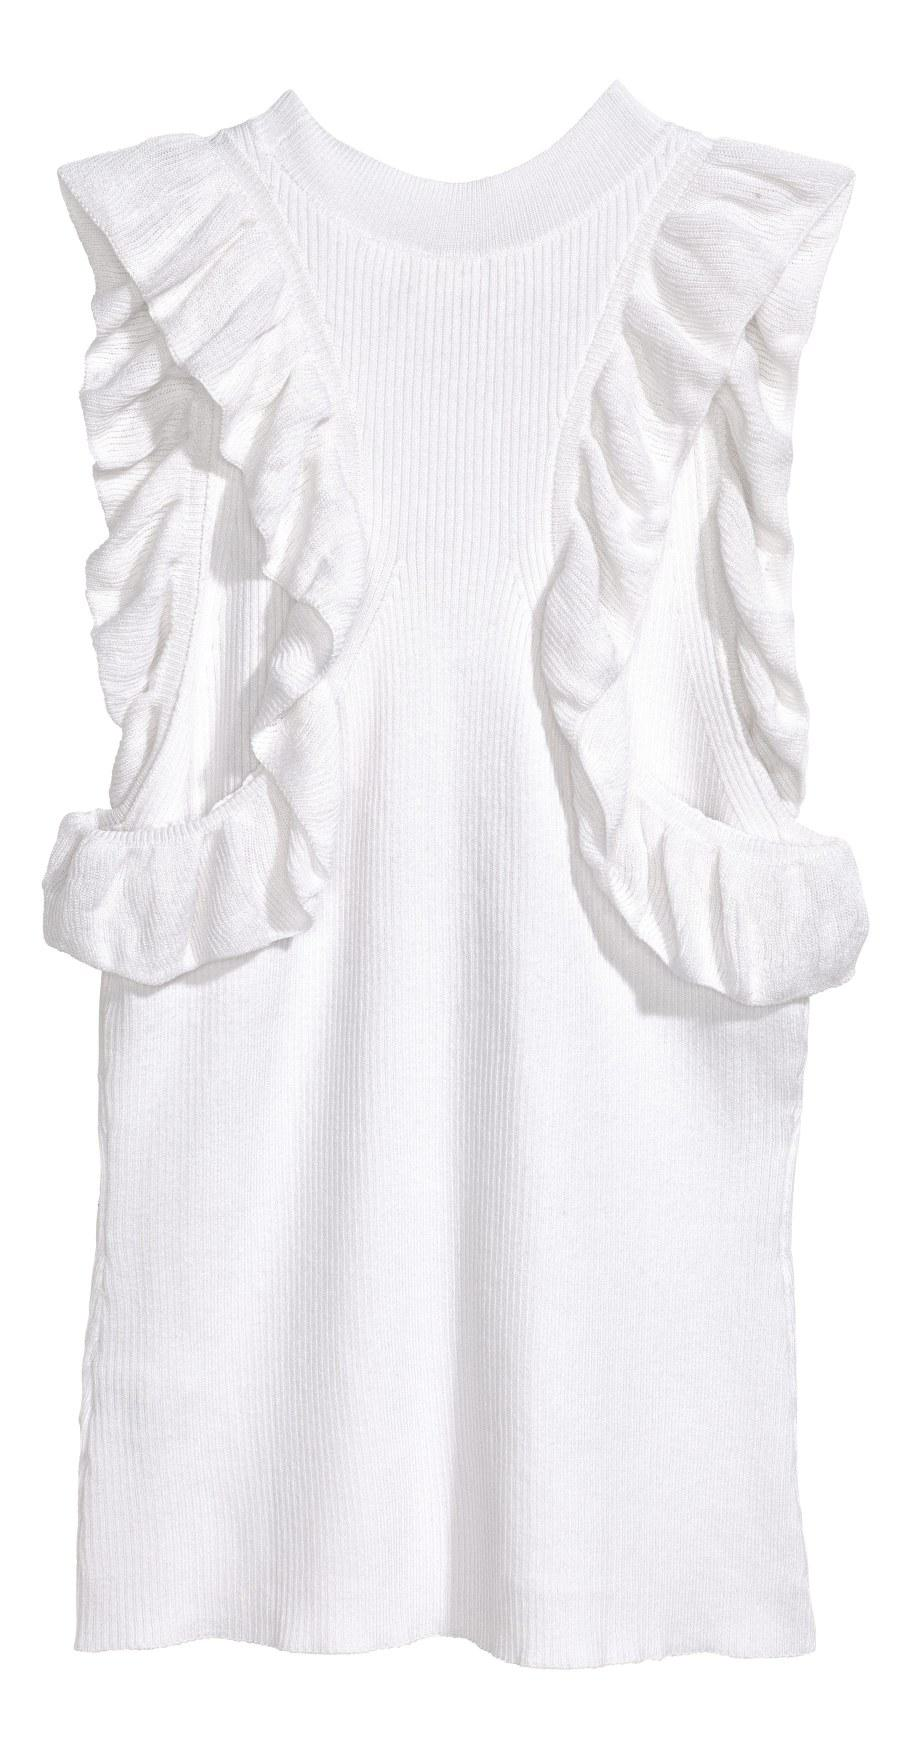
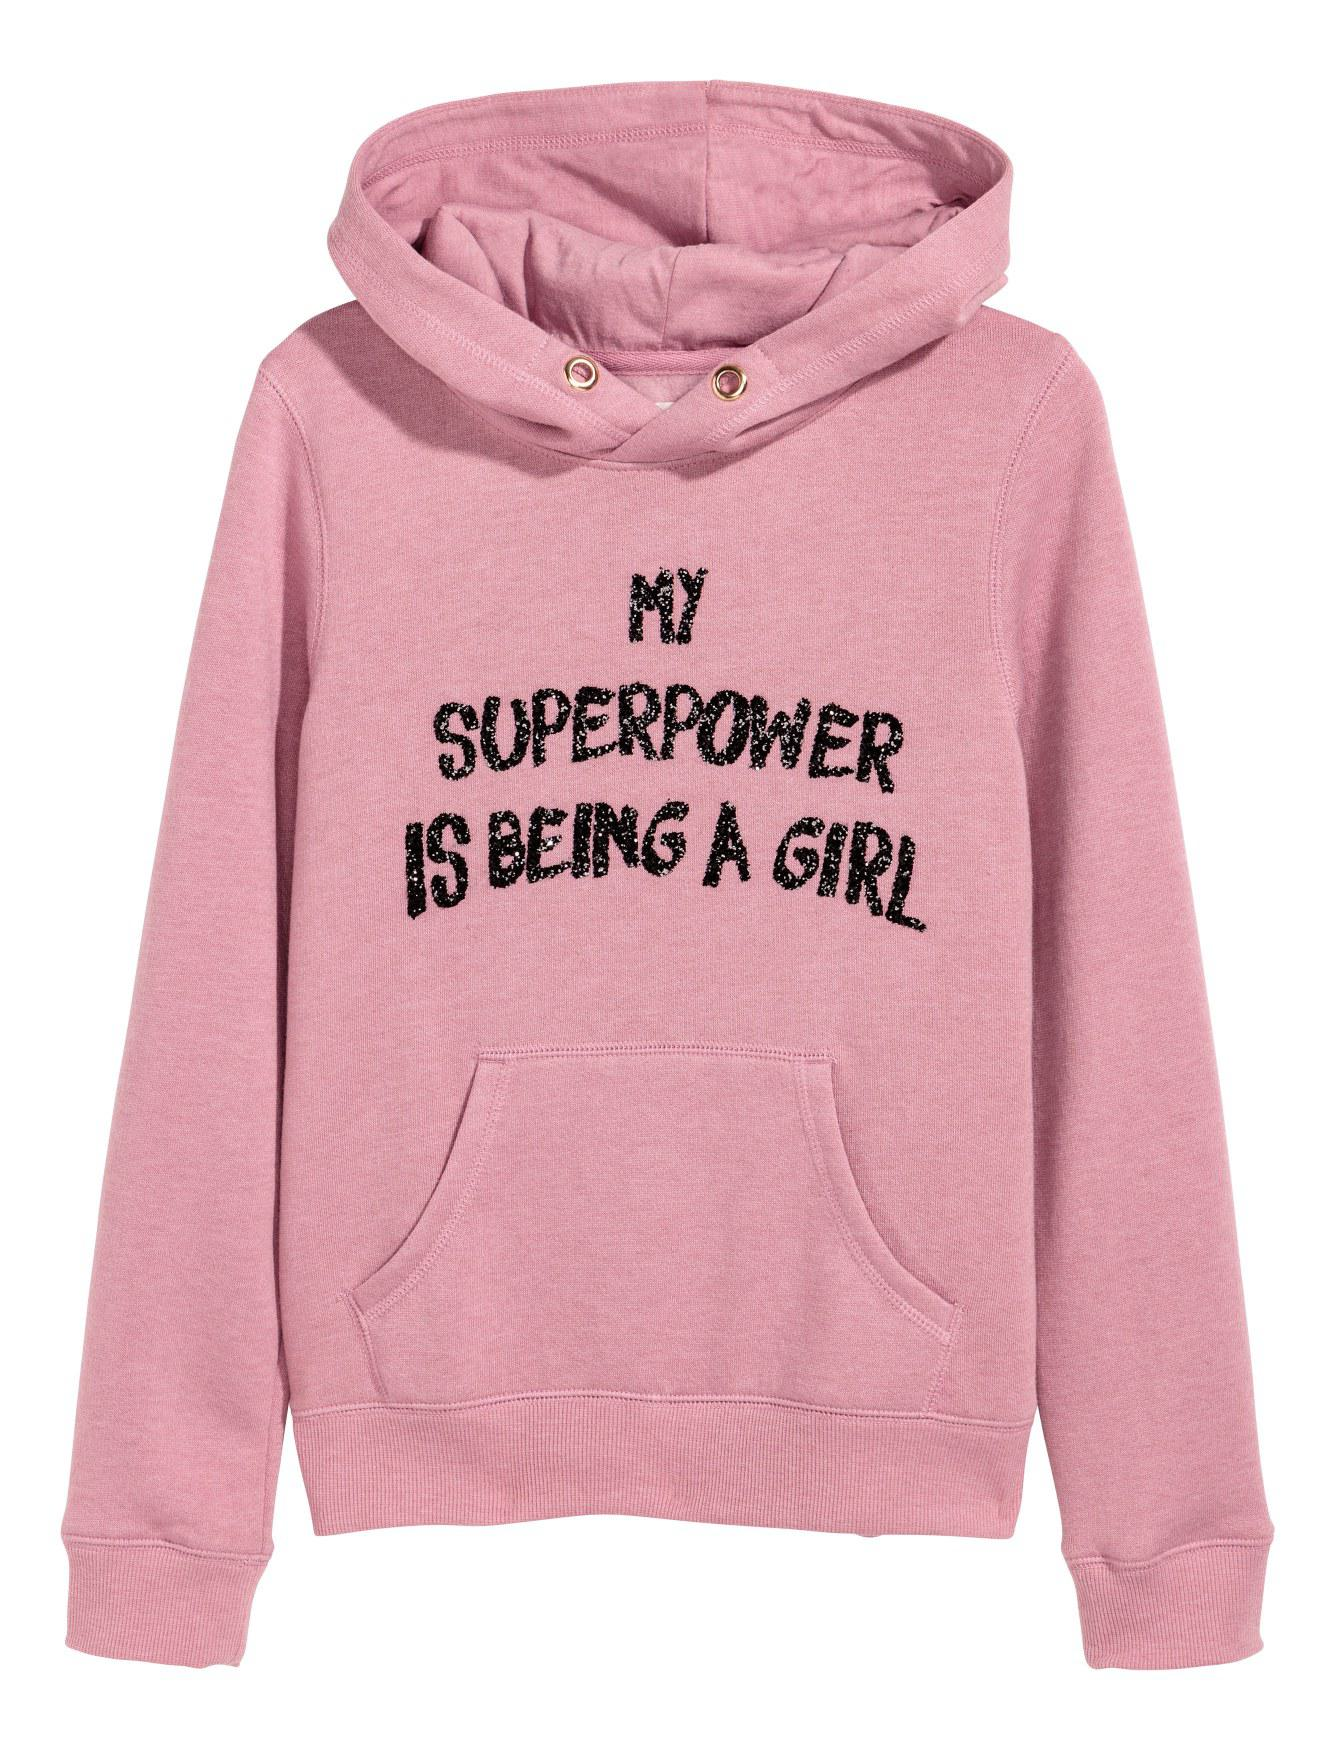
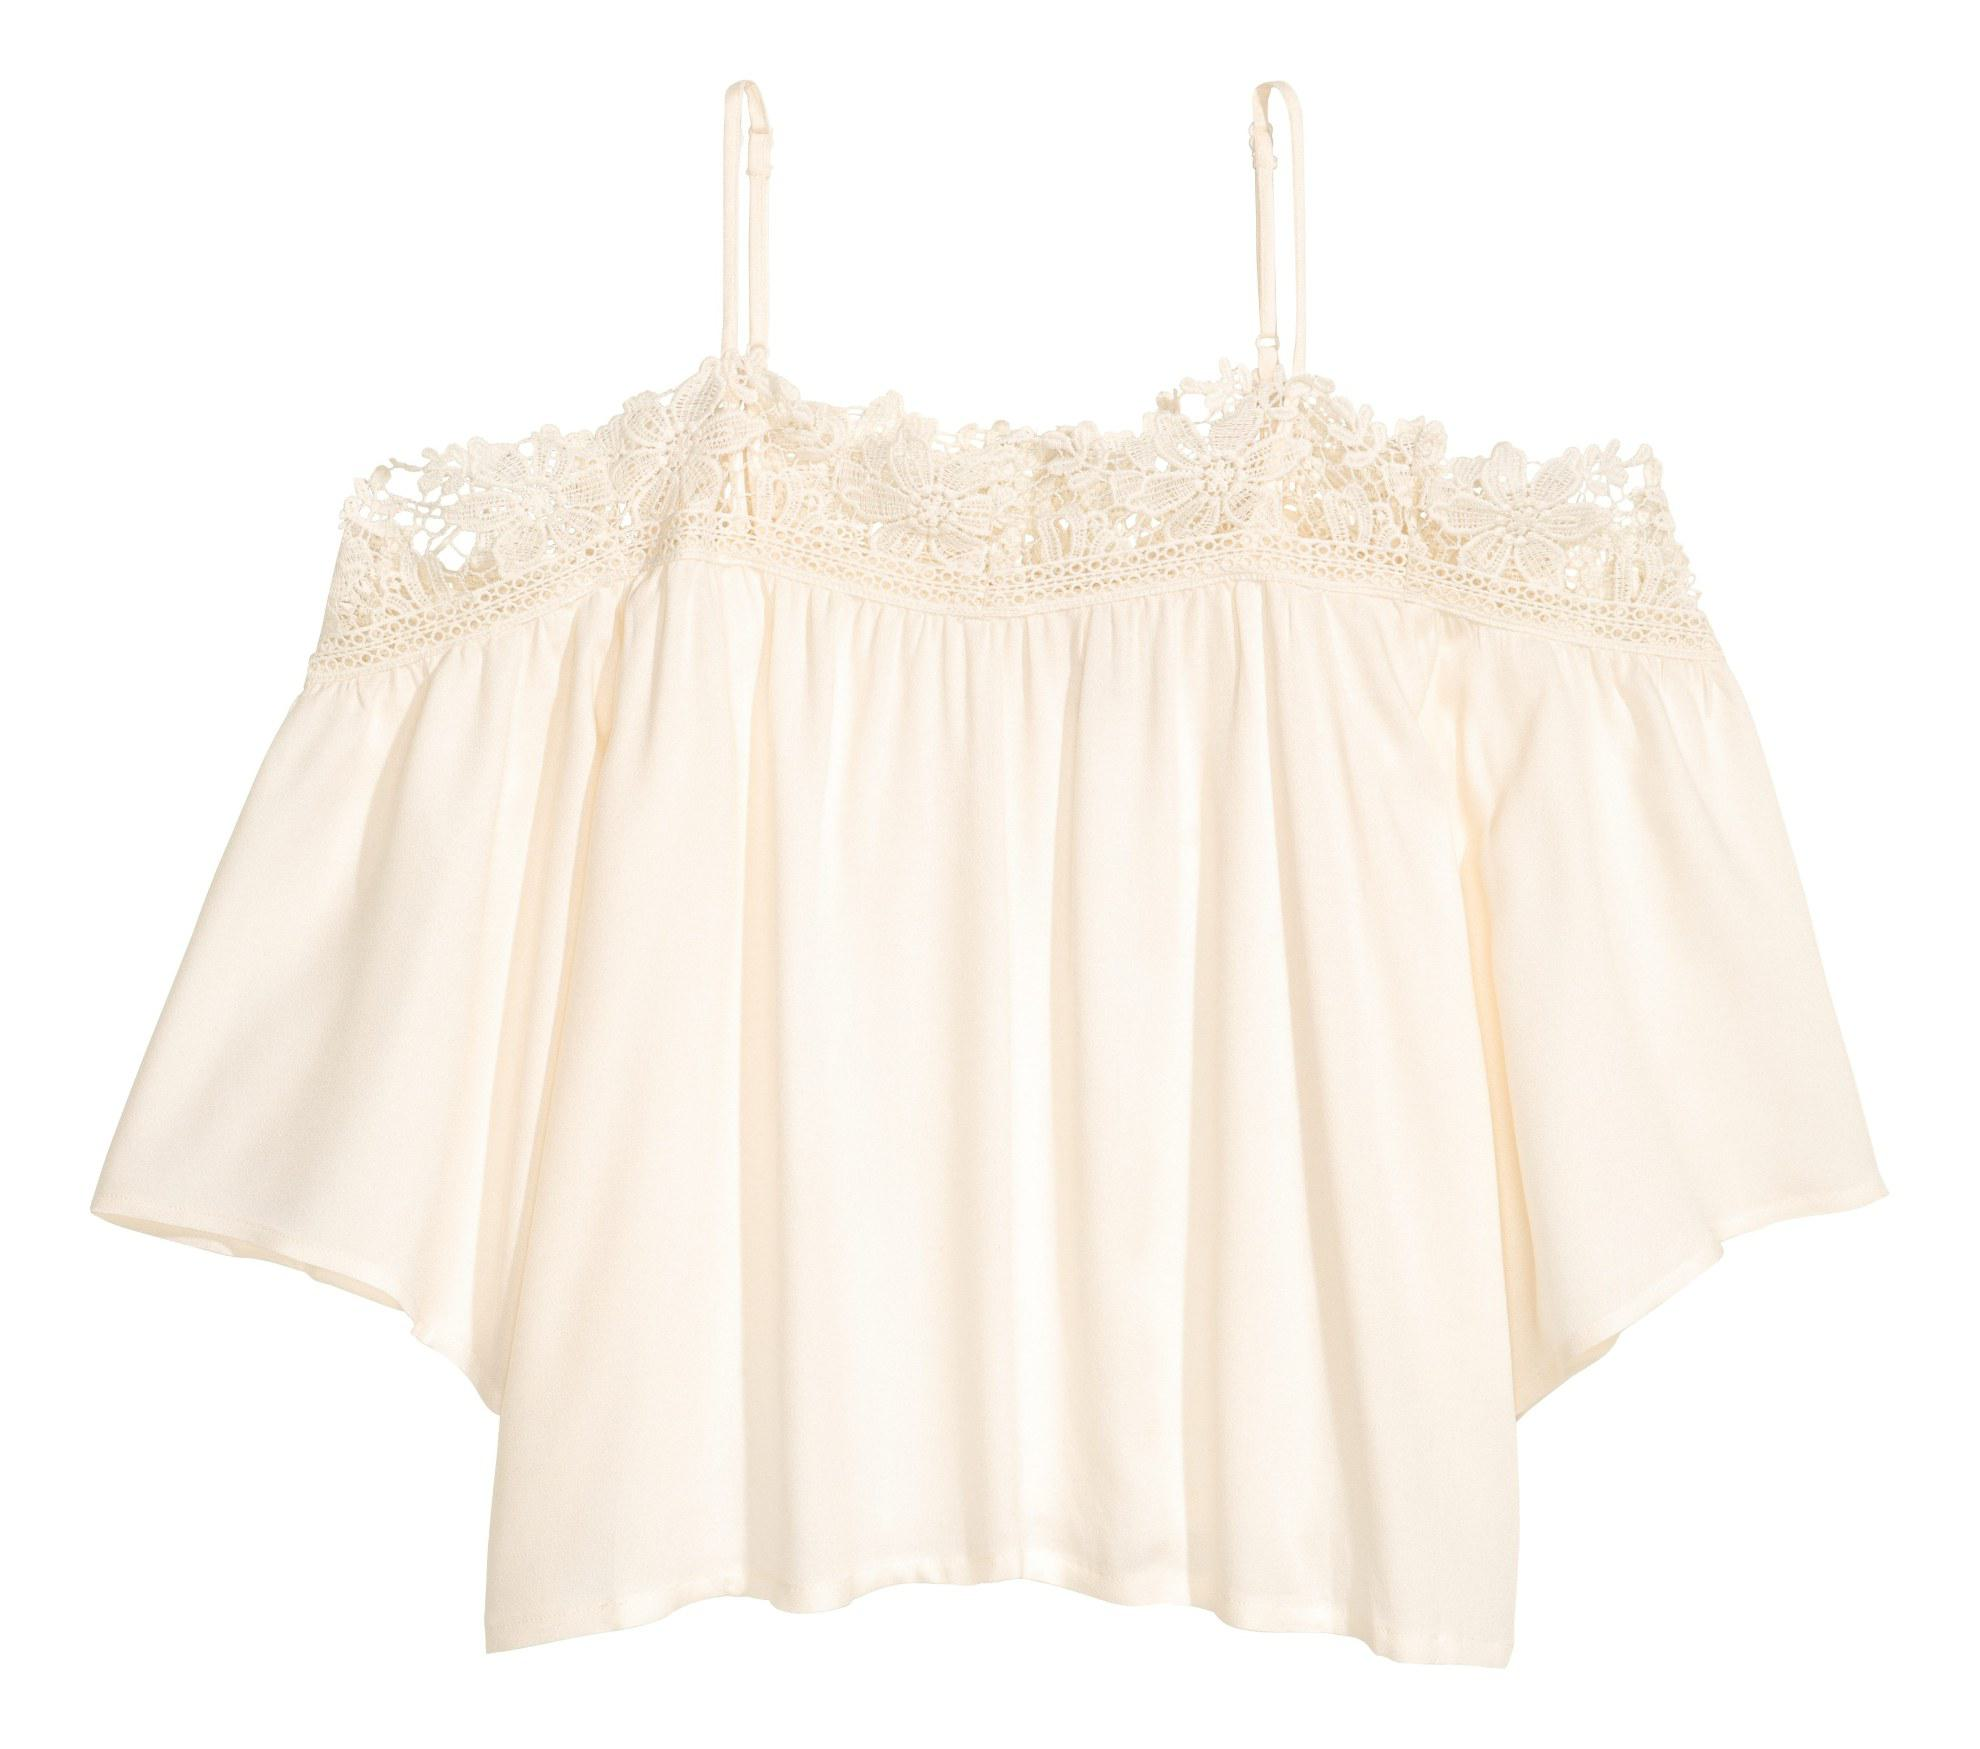
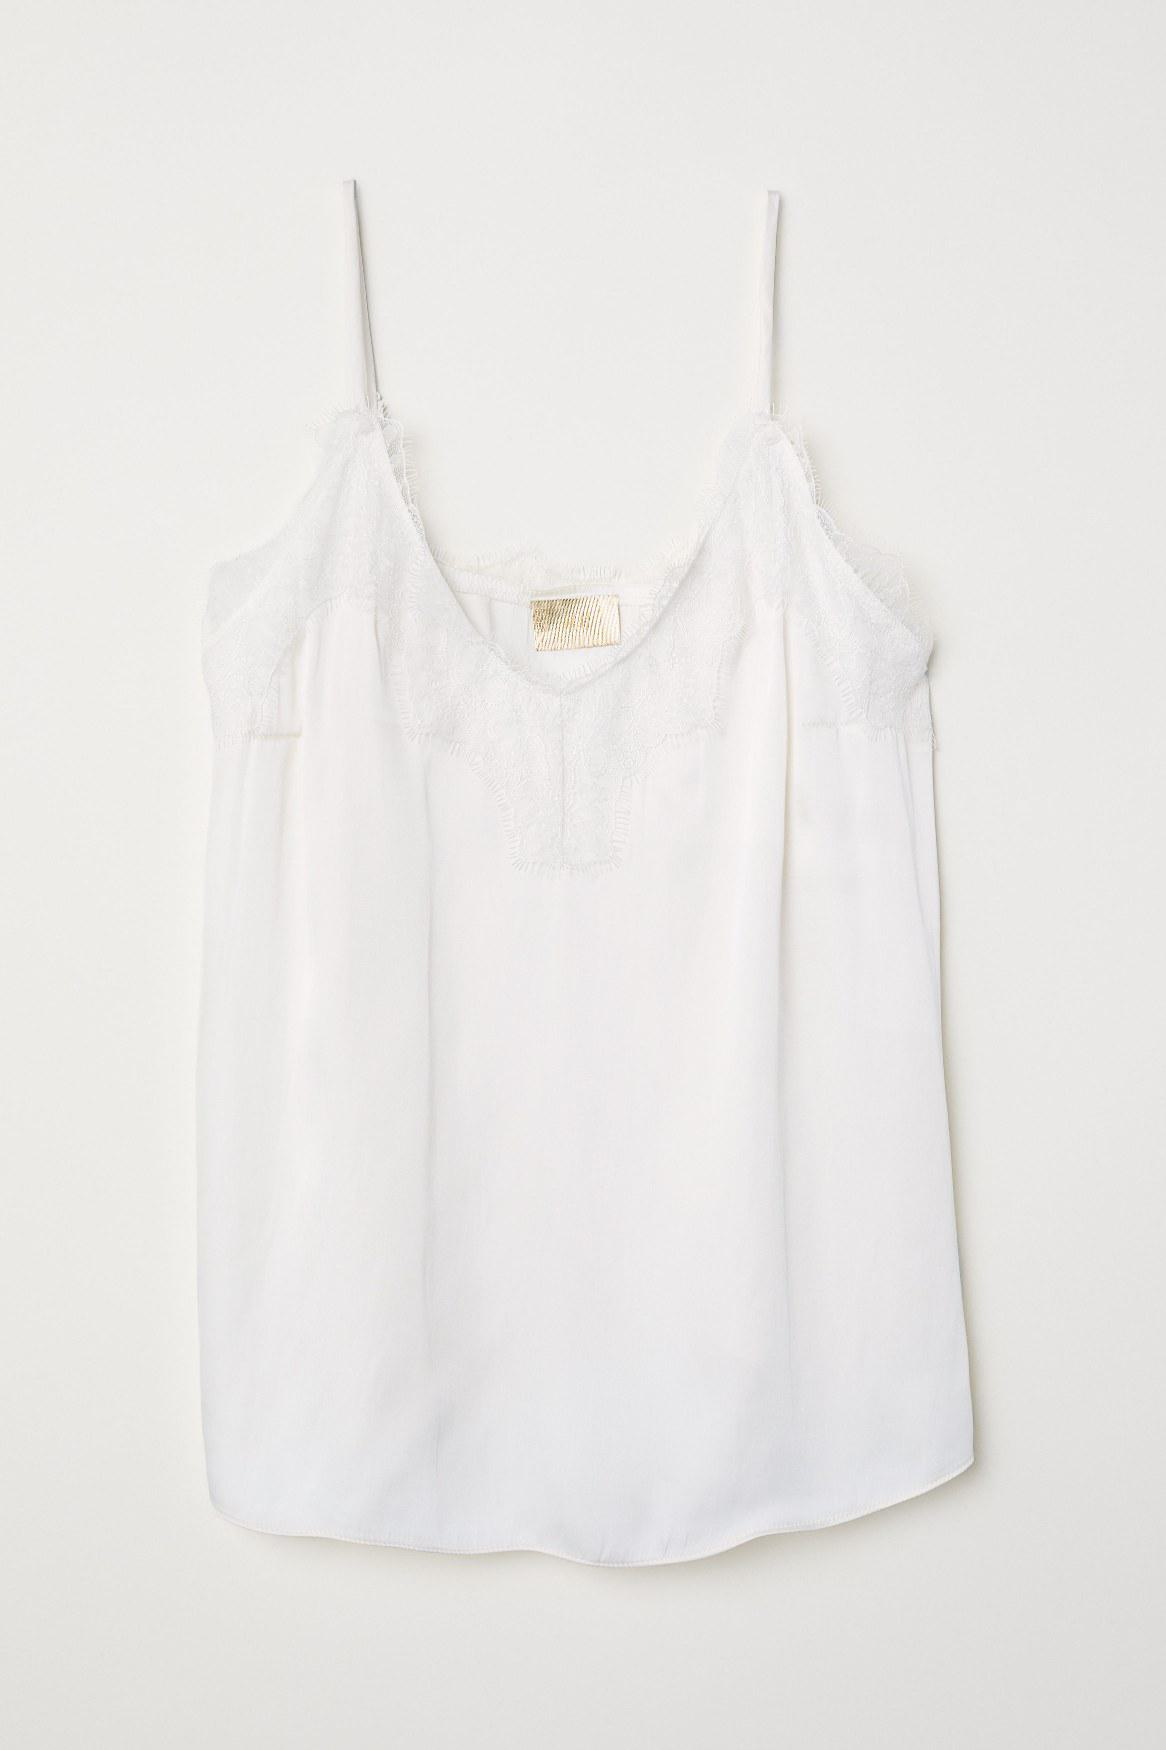
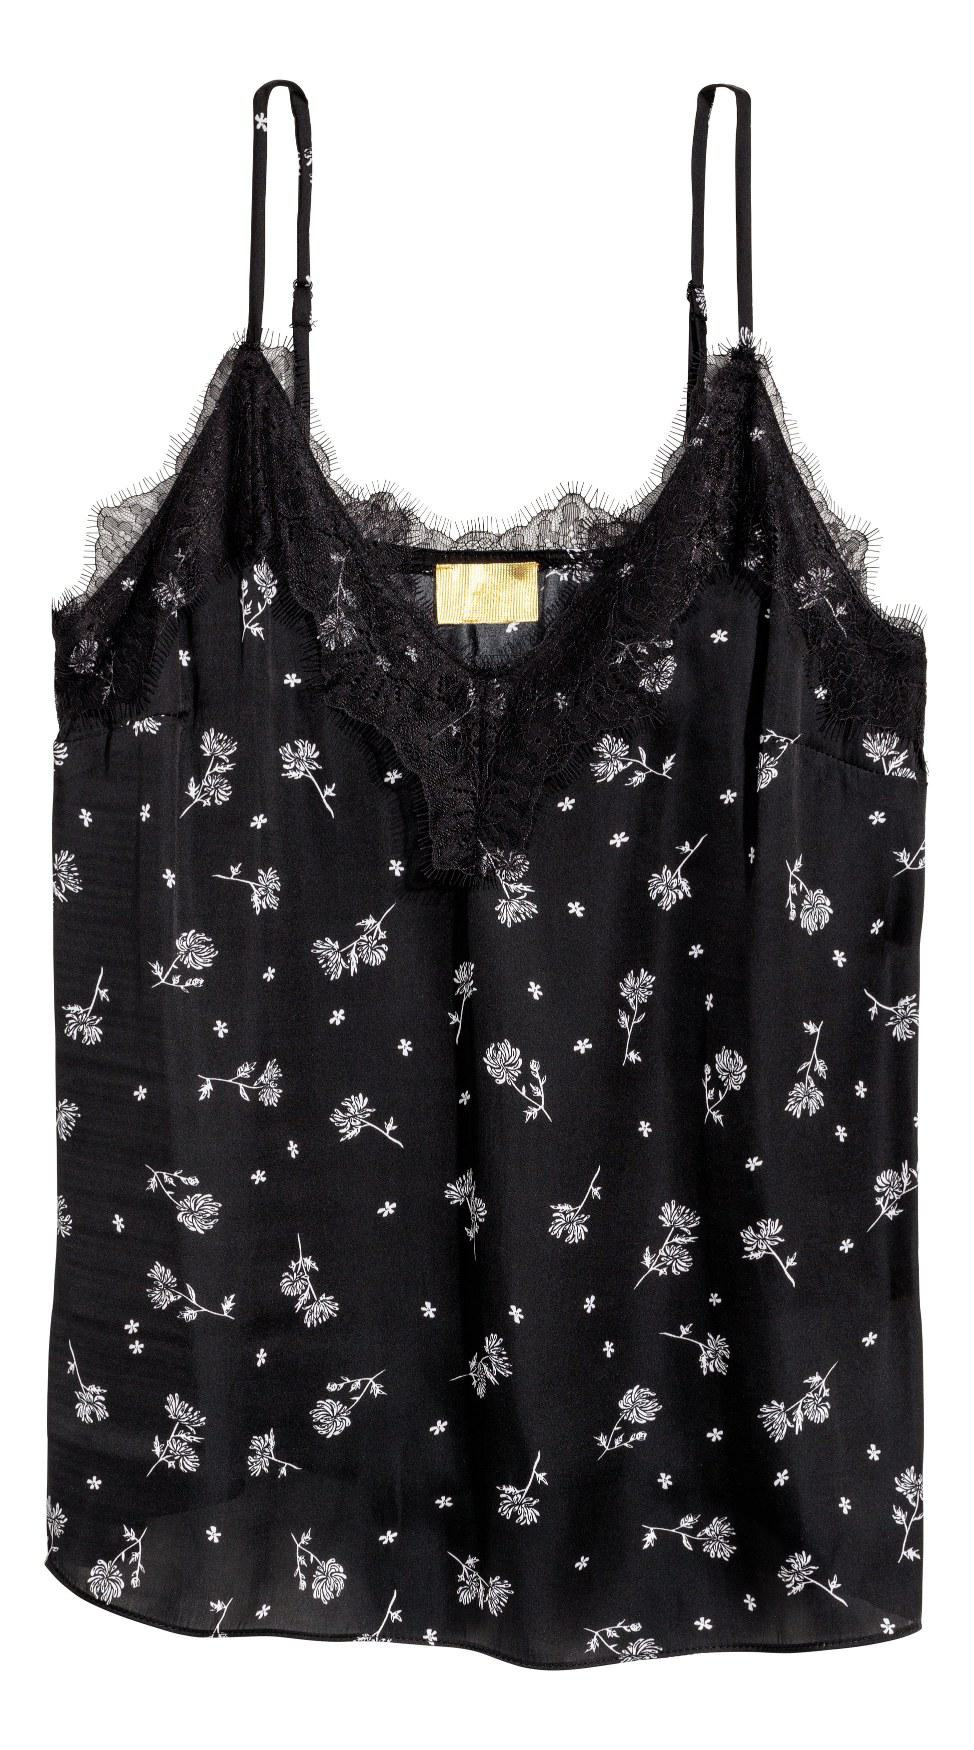
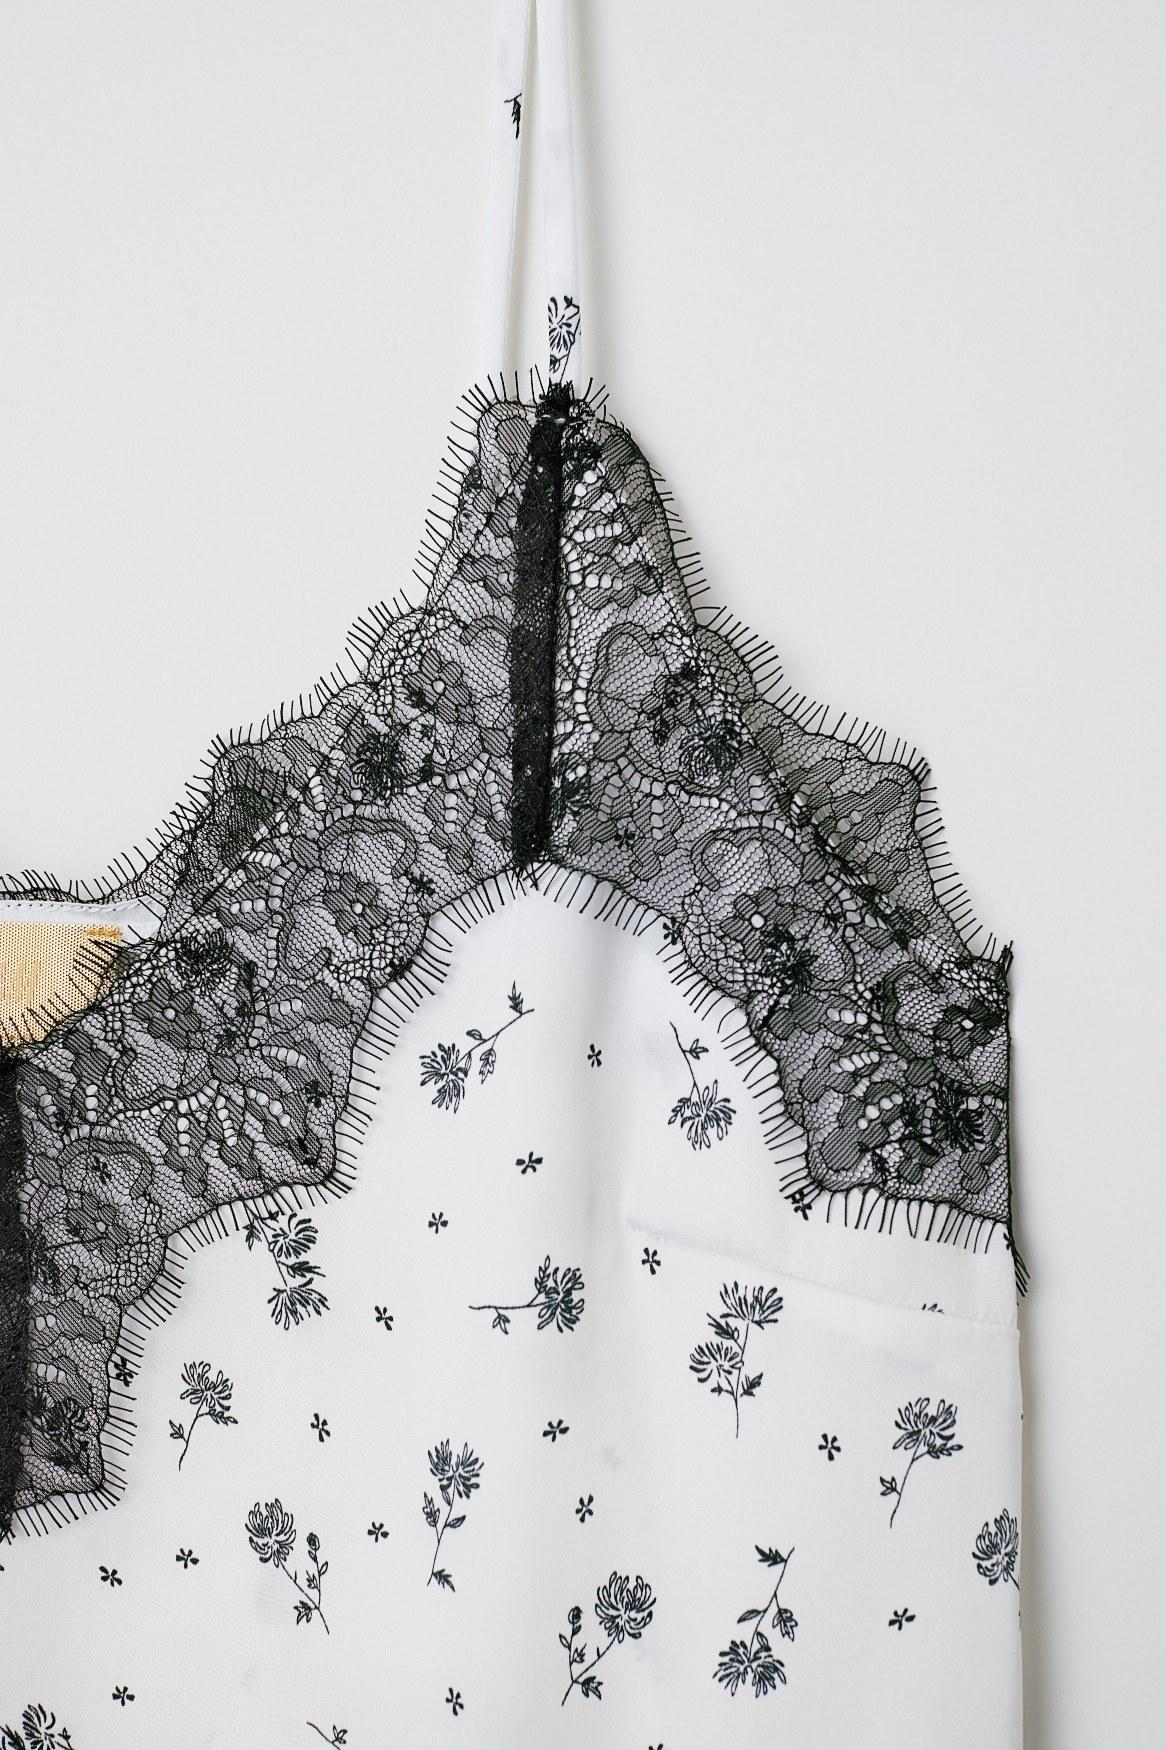
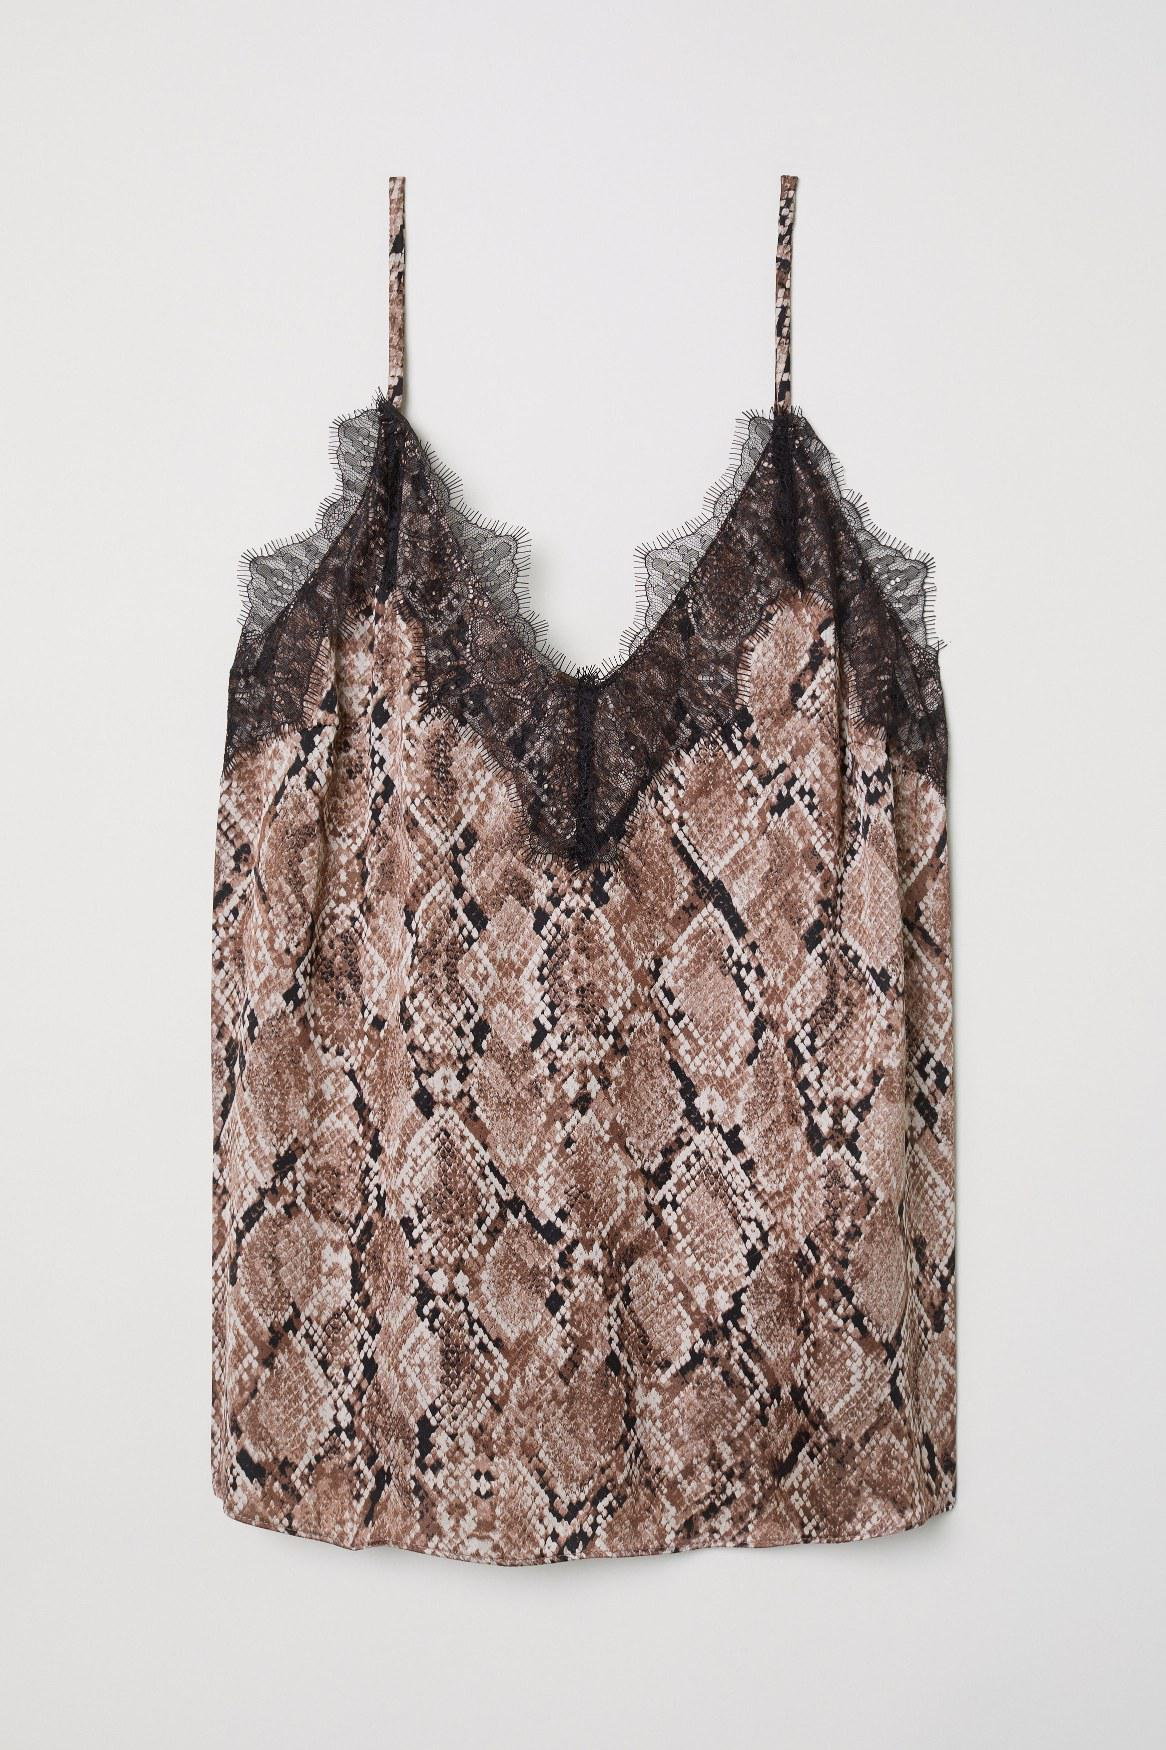
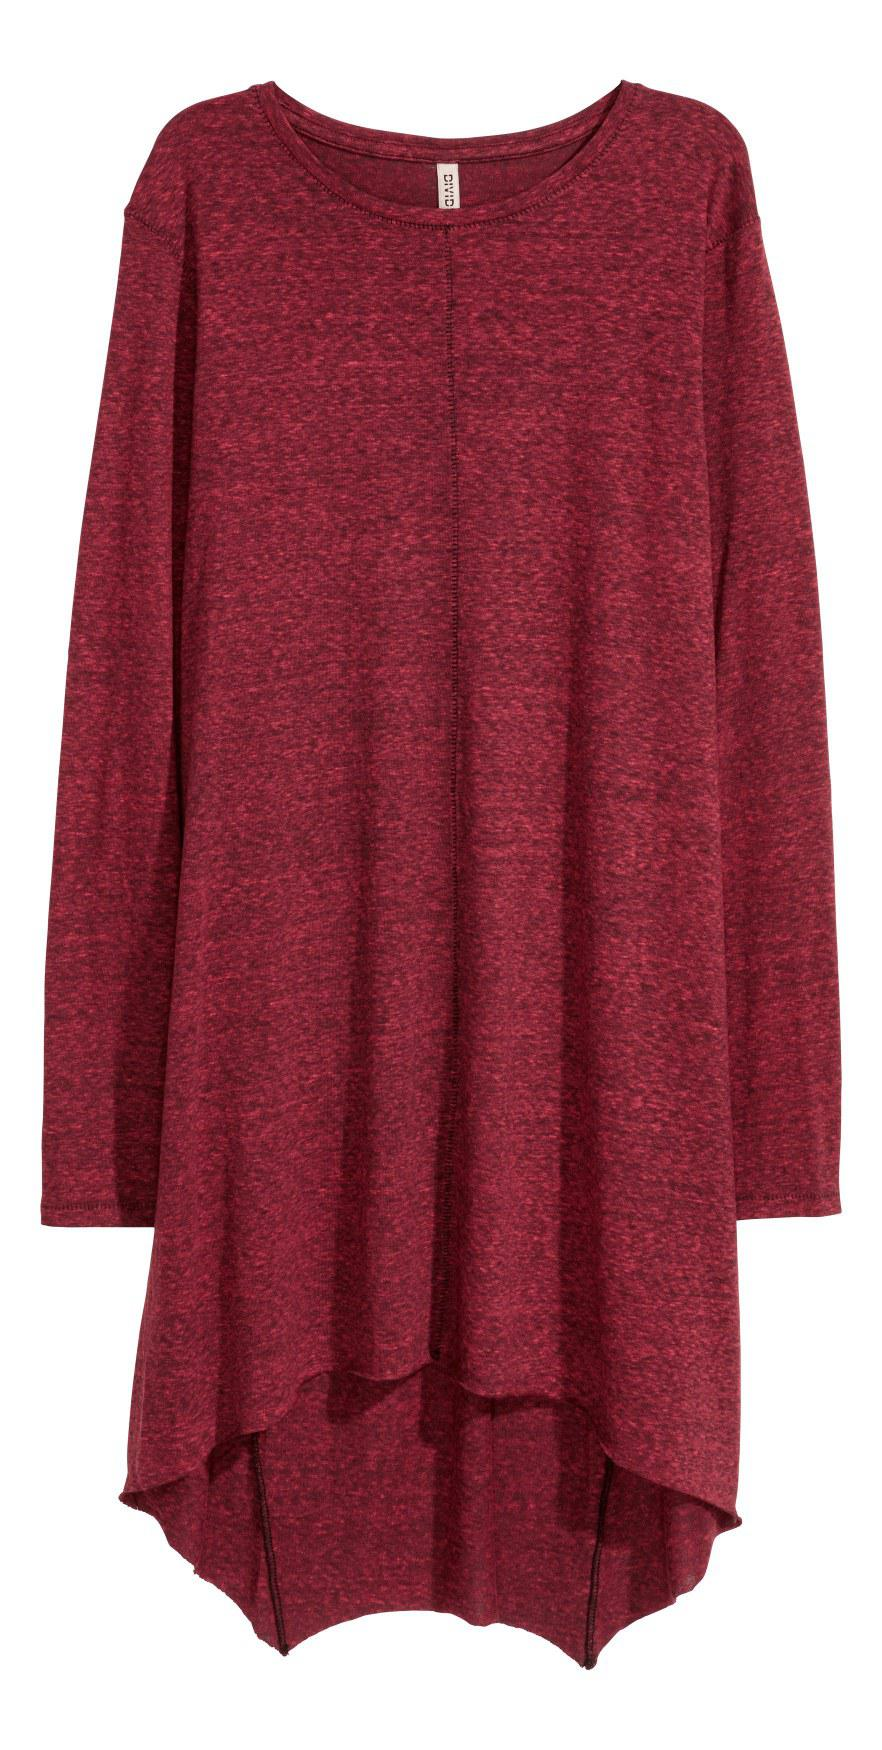
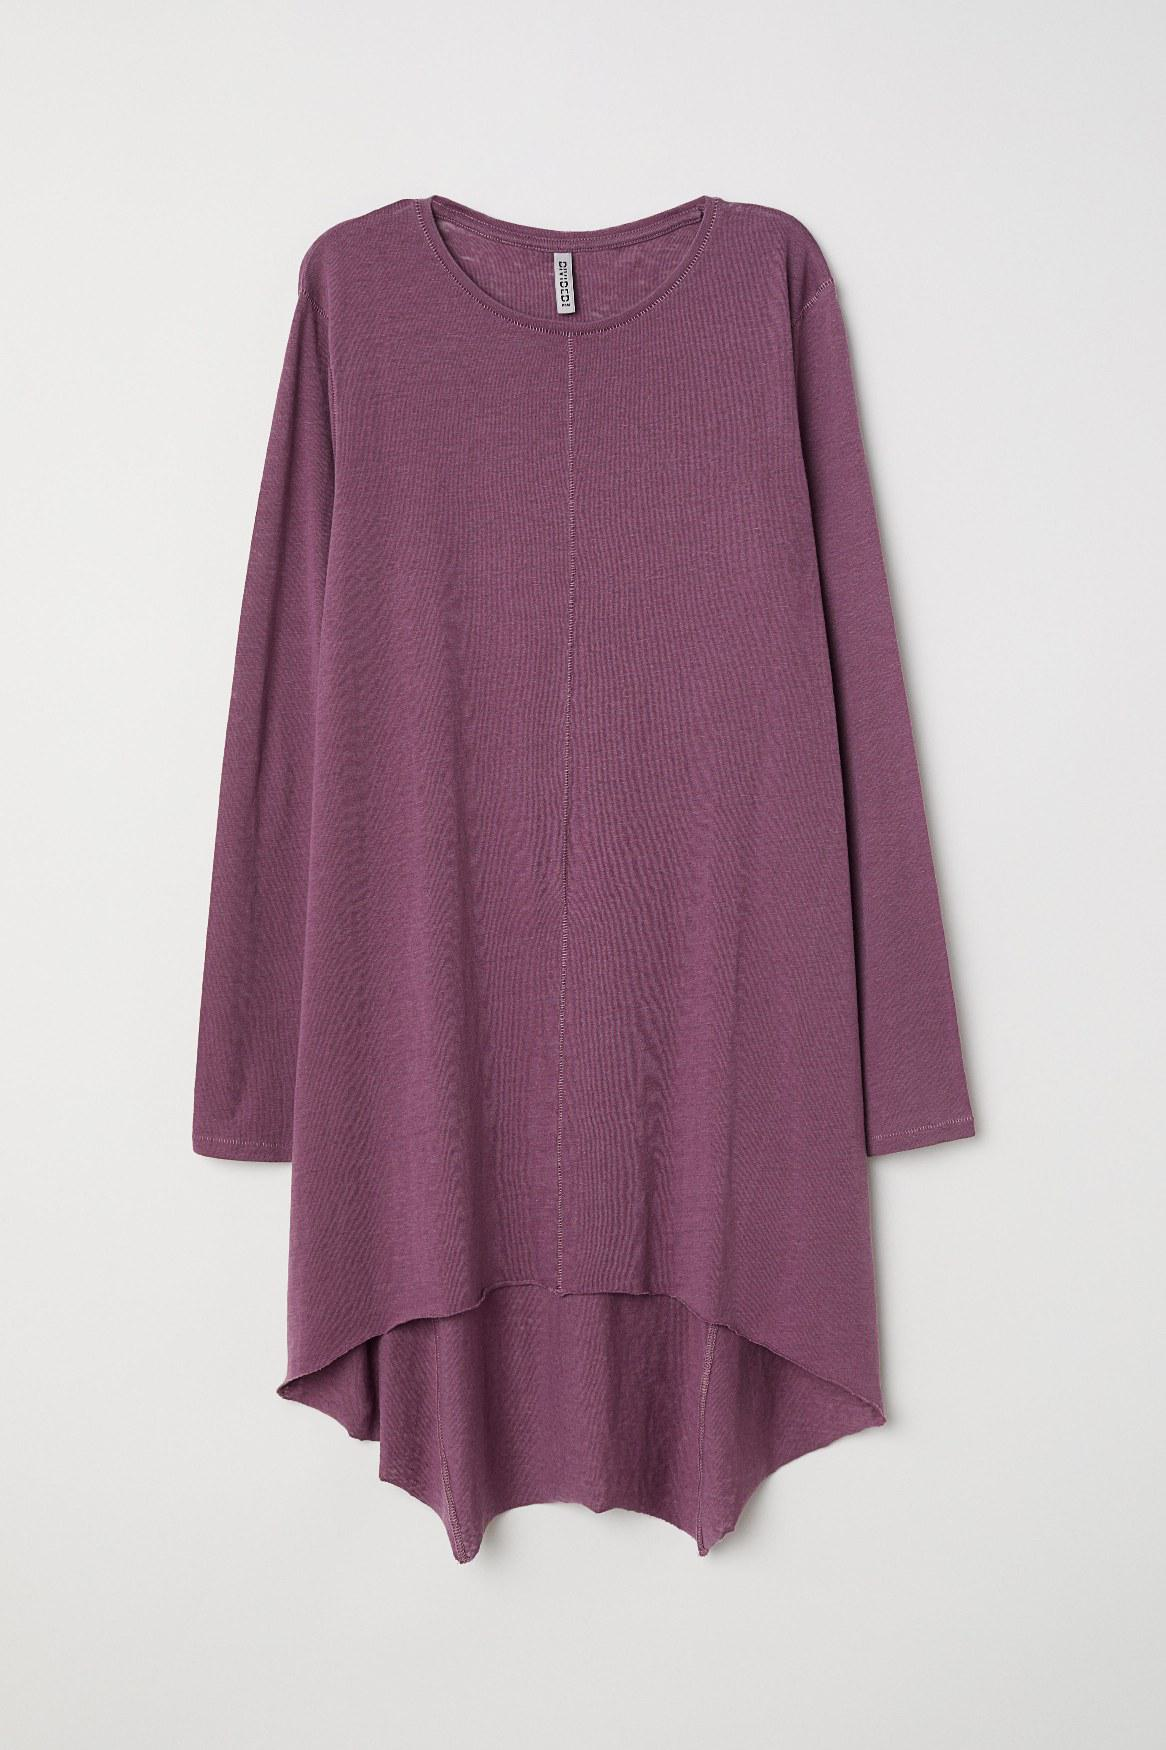
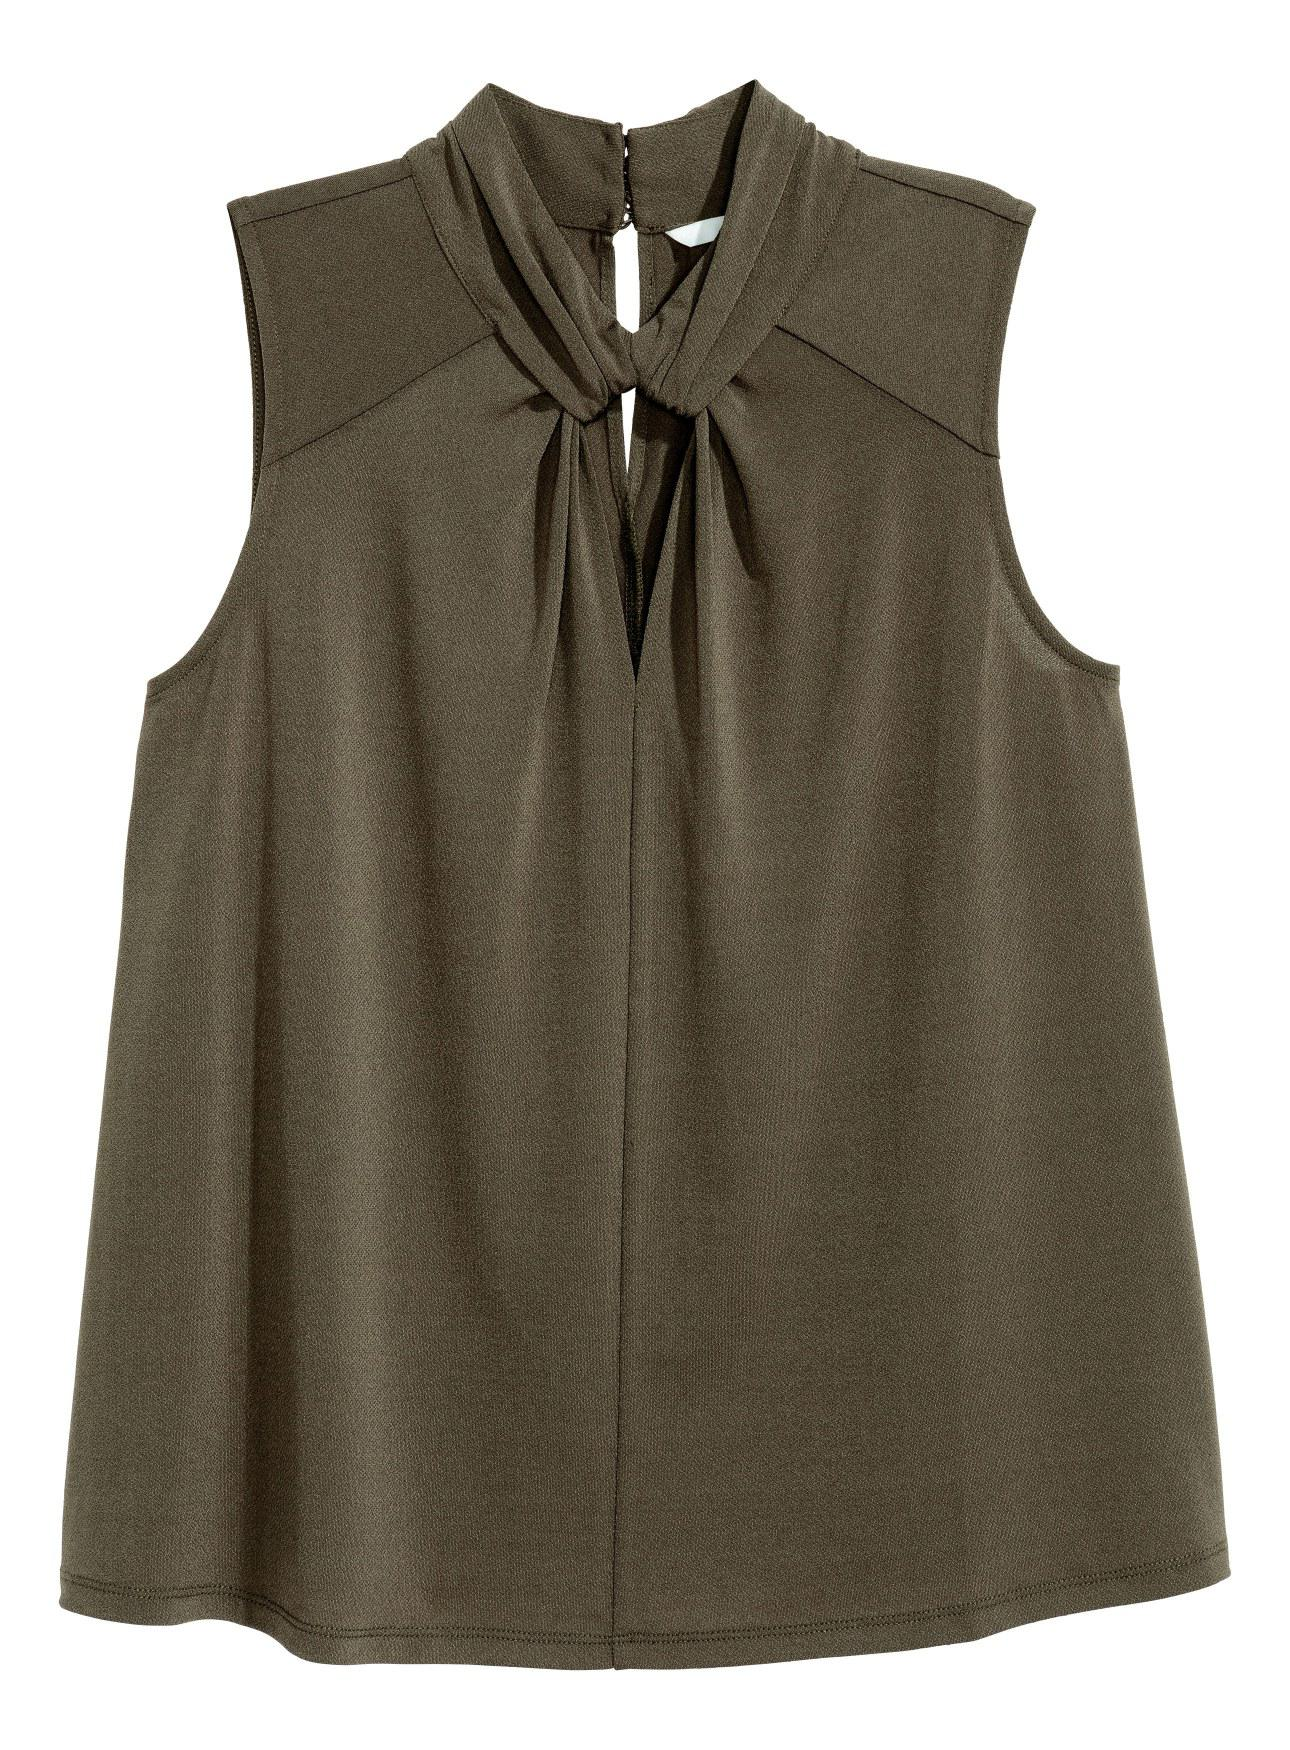
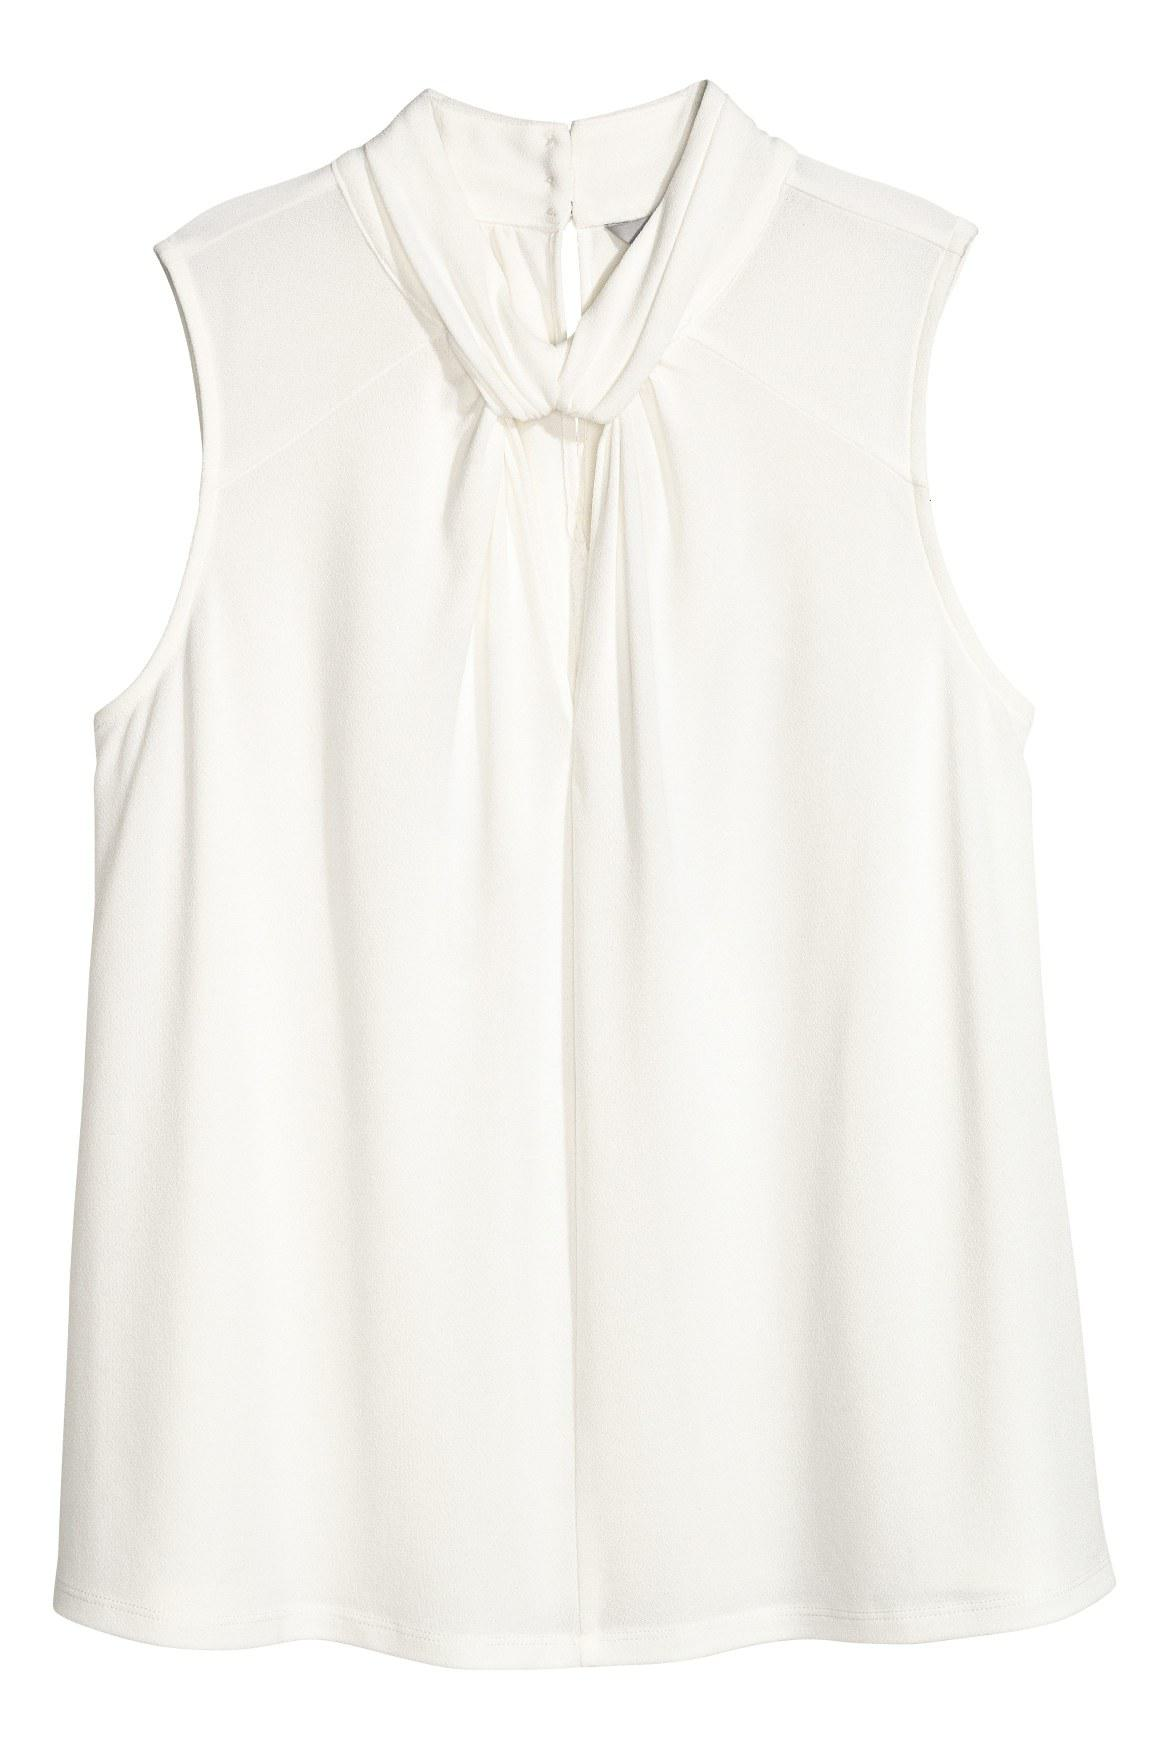
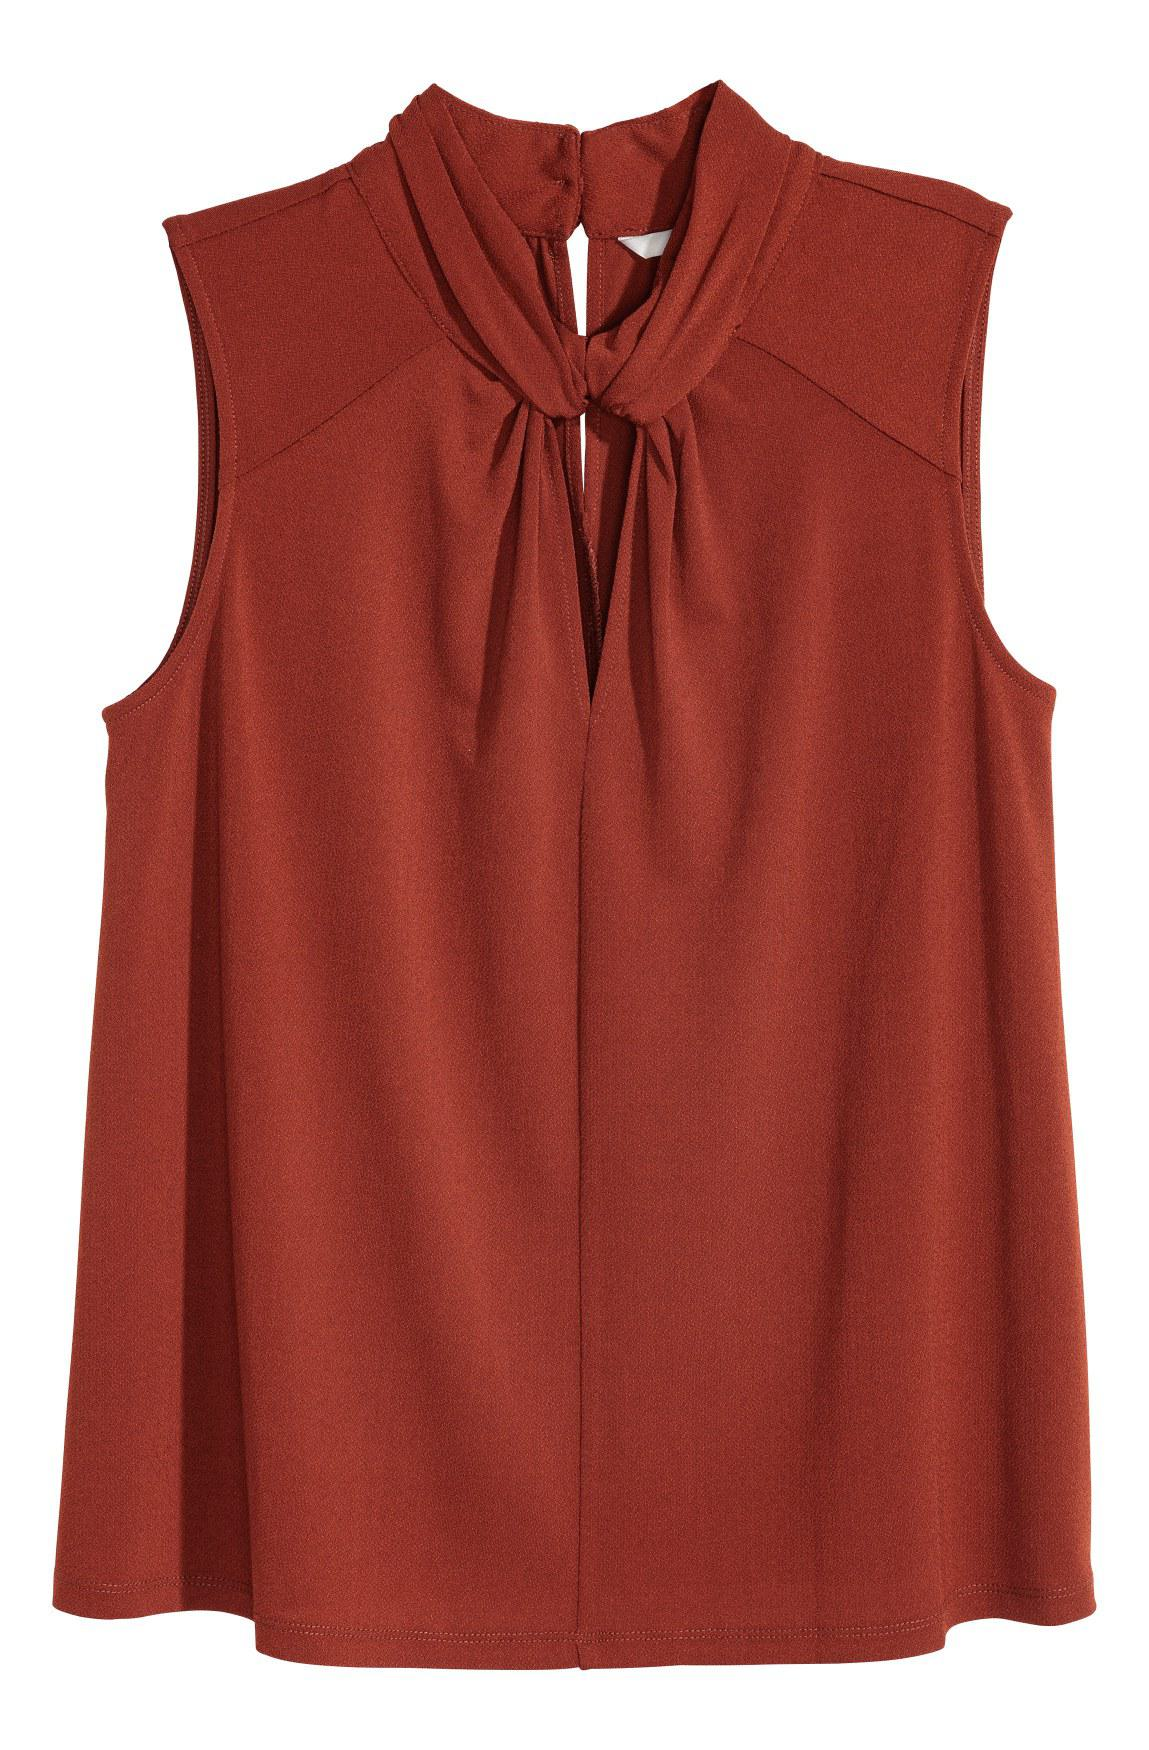
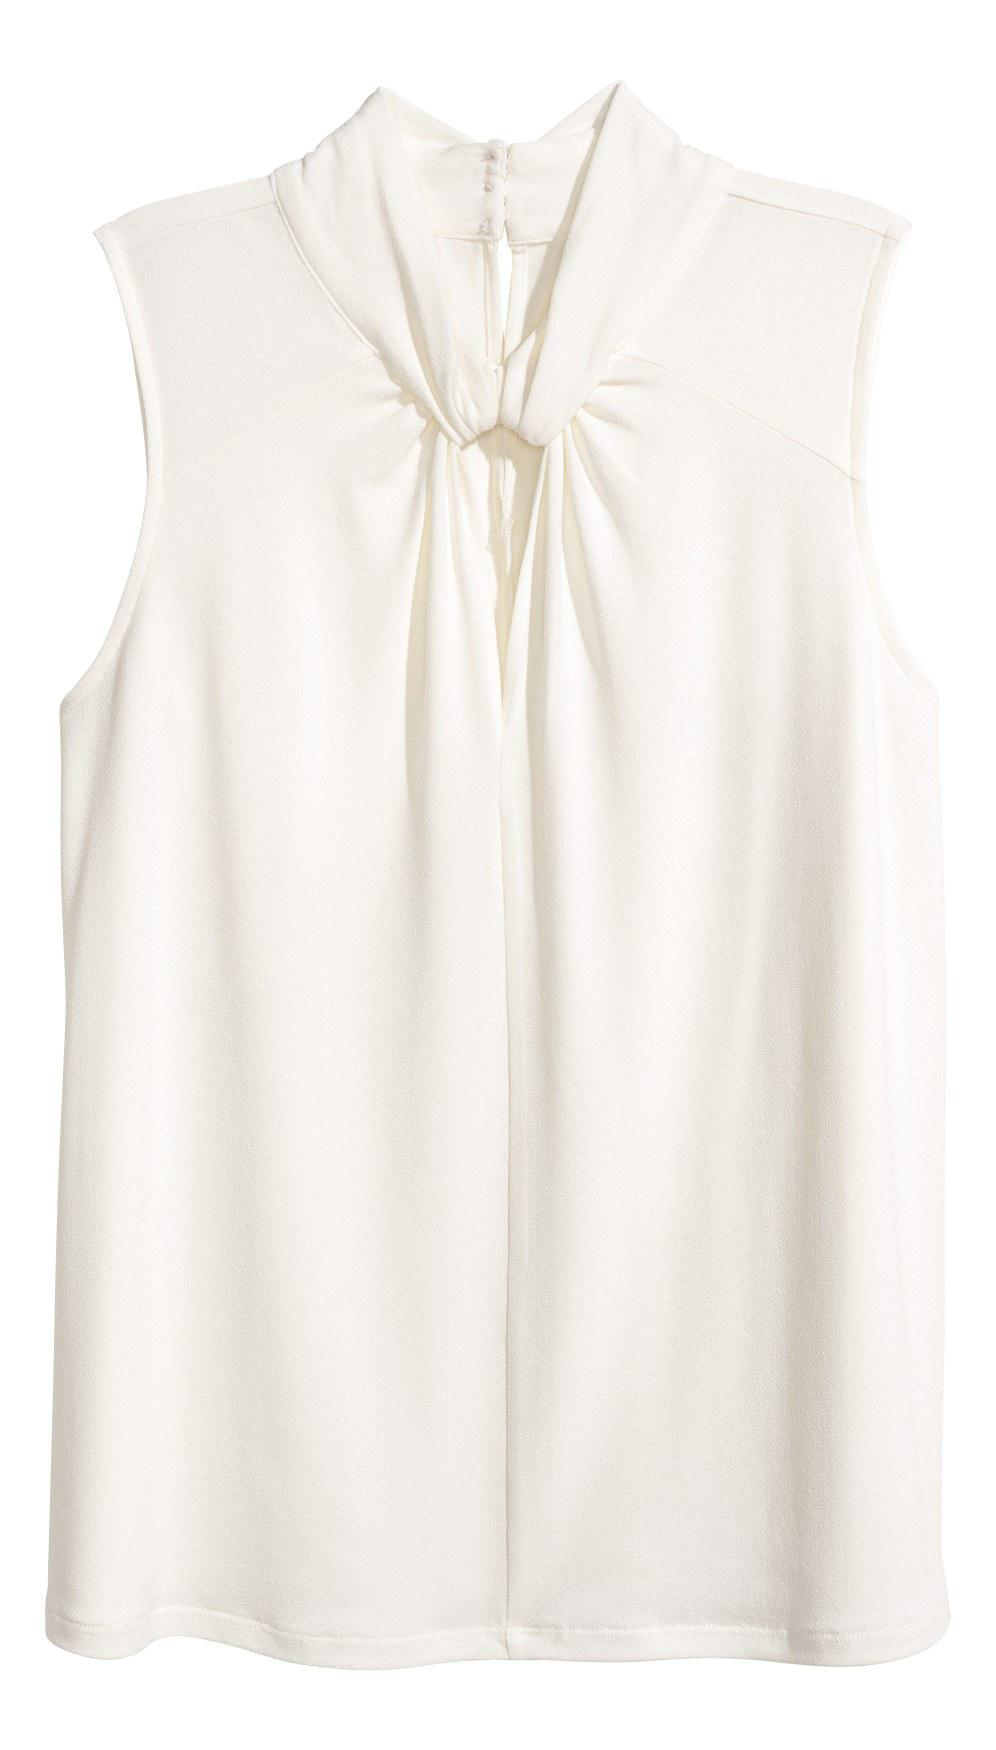
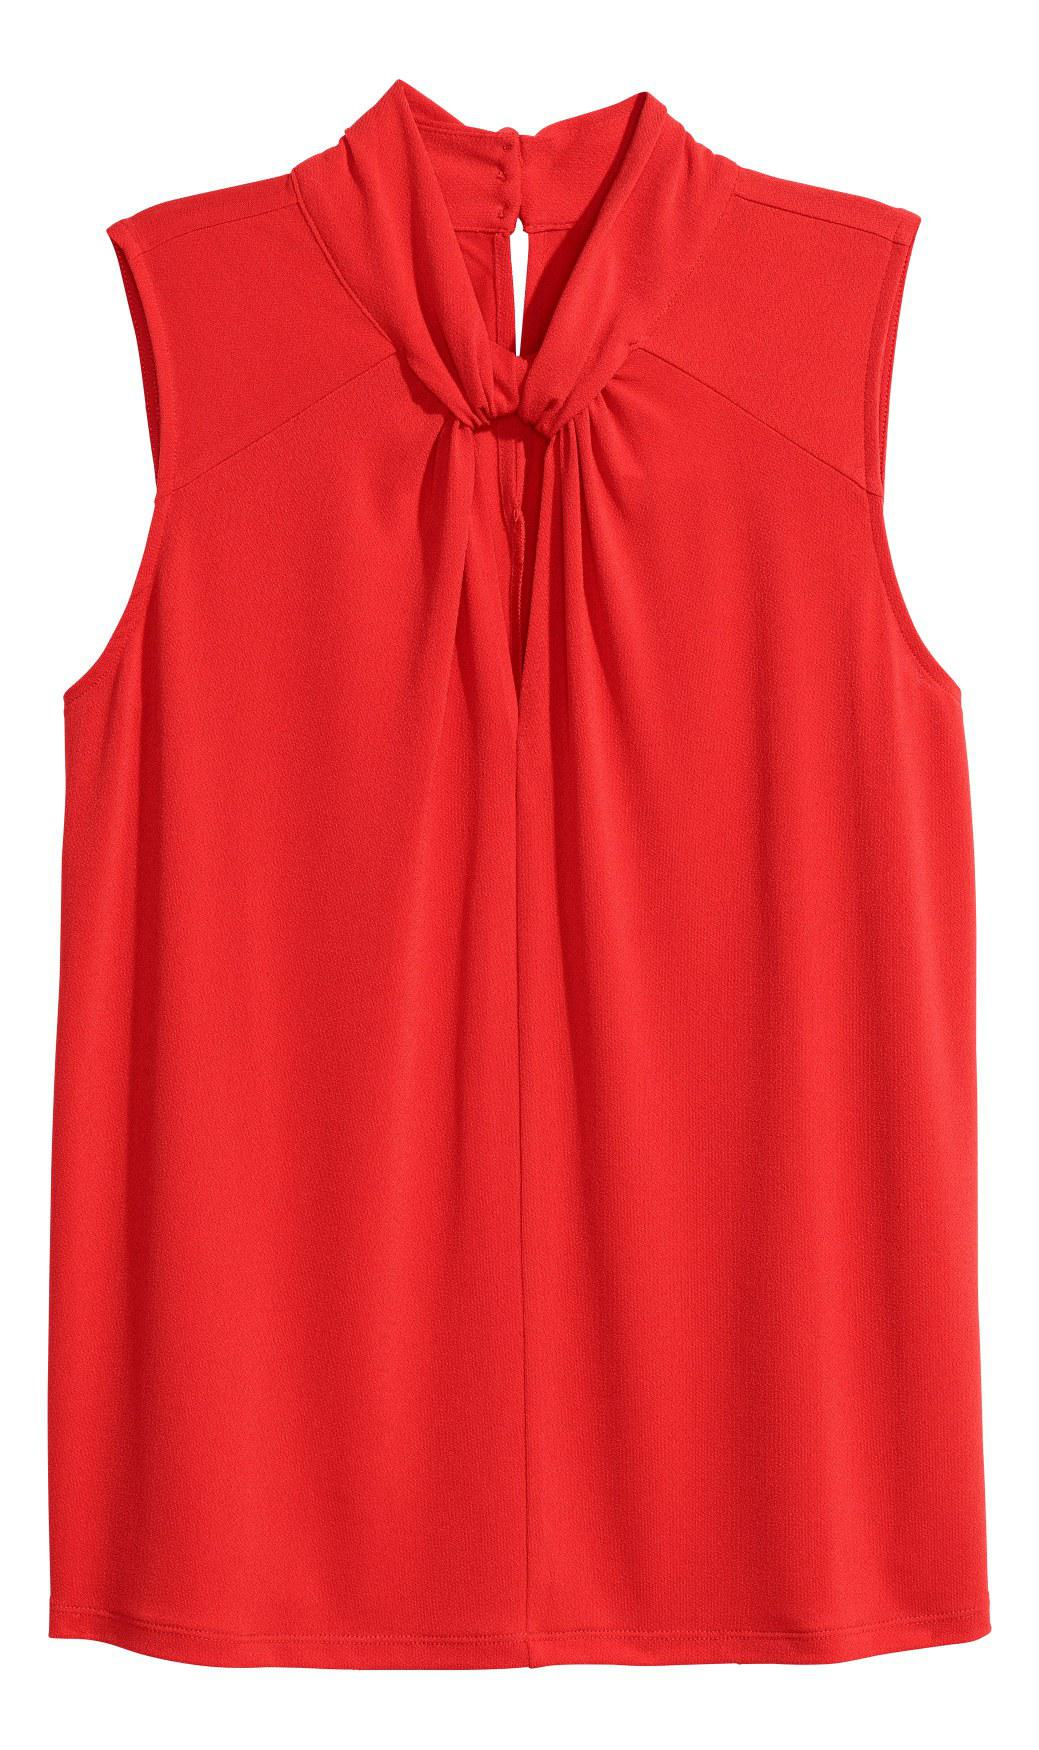
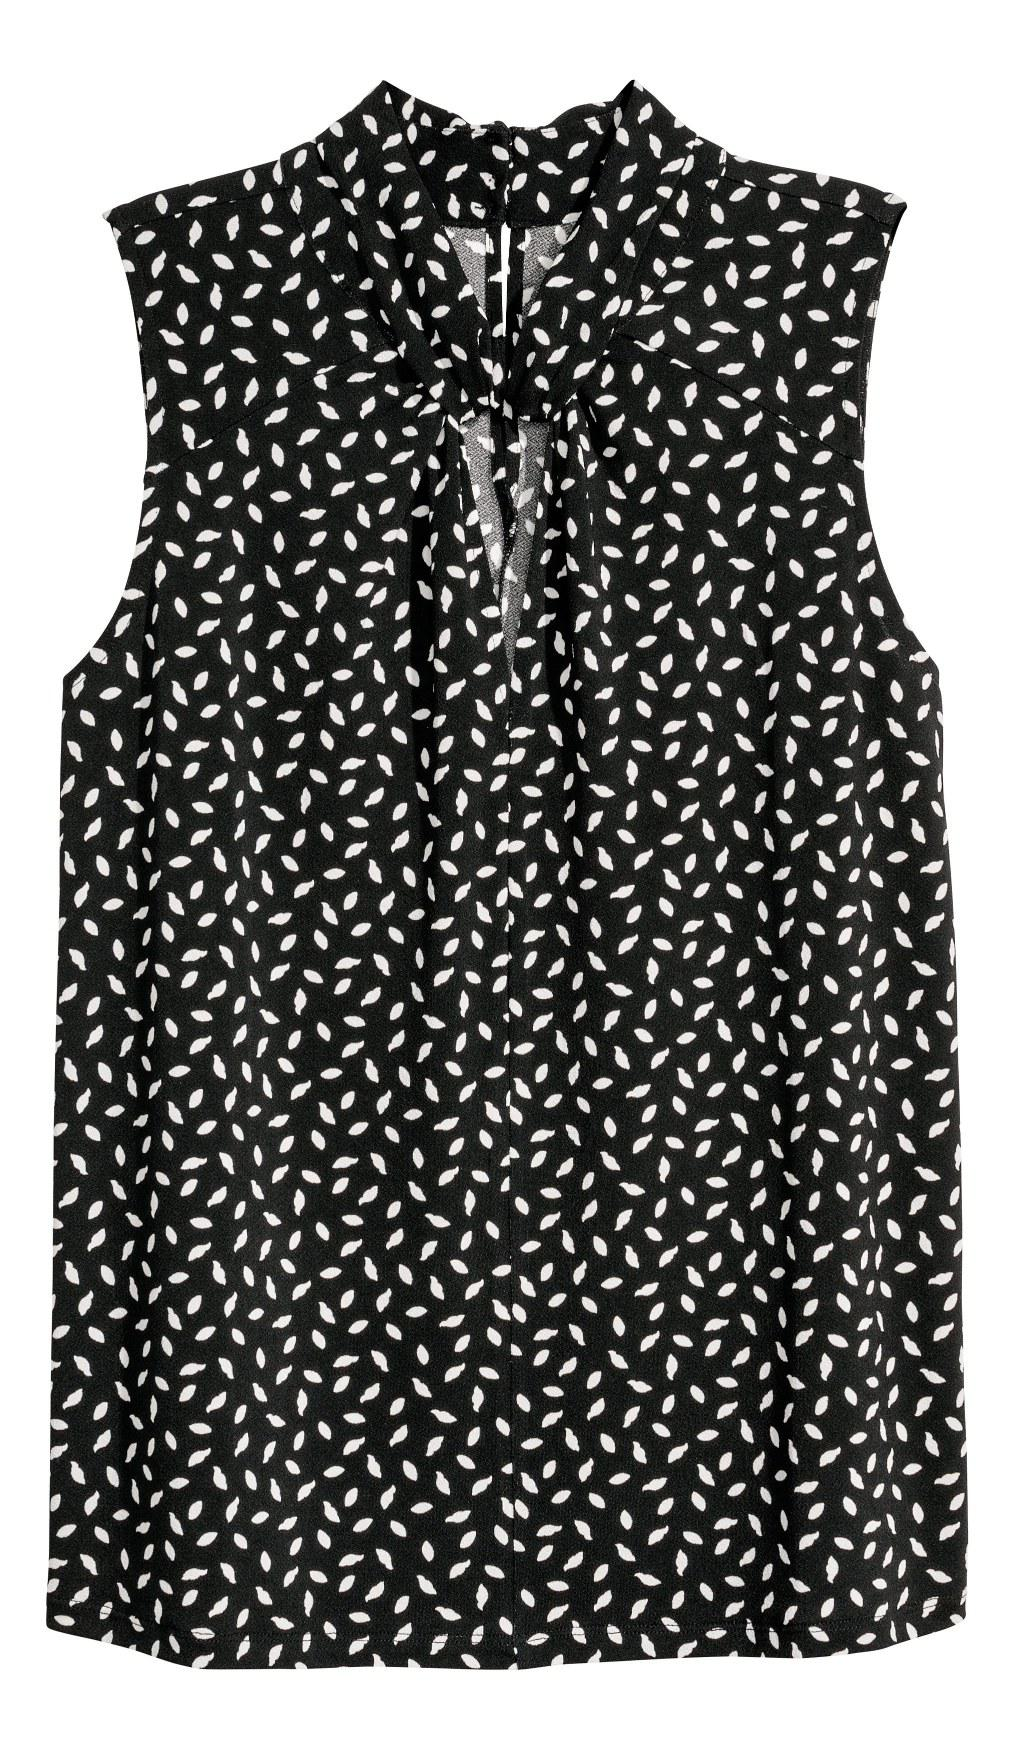

In [172]:
# Only display a small number of rows (20) otherwise image processing is too slow.
rf_incorrect_labels_info_subset = rf_incorrect_labels_info[:10]
rf_incorrect_labels_info_subset['image'] = rf_incorrect_labels_info_subset.index.map(get_image_path)
display_images(rf_incorrect_labels_info_subset, 'image')

Looking at these incorrectly labeled products shows the majority are of hoodies being labeled as Outerwear vs. the correct label of Sweater/Cardigan/Vest. This is a gray area and indicates the two product categories should be merged since they are so similar. 
Some other examples of tops are predicted to be tops in the model but the original dataset is Sweater/Cardigan/Vest which is a data labeling error that should be fixed. 

### KNN Classifier 


In [175]:
time_start = time.time()
knn_clf = KNeighborsClassifier()

knn_params = {'n_neighbors':[3, 5, 10],
              'algorithm' : ["kd_tree"],
              'leaf_size' : [300]
#             'weights':['uniform', 'distance']
             }
knn_random_cv = RandomizedSearchCV(knn_clf, param_distributions = knn_params, n_jobs=-1, cv=2, scoring='f1_weighted')

knn_random_cv.fit(X_train_full,y_train)



/Users/pandabear/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=2, estimator=KNeighborsClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['kd_tree'],
                                        'leaf_size': [300],
                                        'n_neighbors': [3, 5, 10]},
                   scoring='f1_weighted')

In [176]:
best_model_knn = knn_random_cv.best_estimator_

y_pred_knn = best_model_knn.predict(X_test_full)
print(time.time() - time_start)
print(classification_report(y_test, y_pred_knn))

6265.864943027496
                       precision    recall  f1-score   support

          Accessories       0.84      0.82      0.83      1239
                  Bag       0.86      0.87      0.87       380
             Bodysuit       0.59      0.50      0.54       240
                Dress       0.72      0.86      0.78      3106
          Full length       0.64      0.40      0.49       861
                  Hat       0.90      0.91      0.91       687
              Jewelry       0.90      0.94      0.92       519
            Outerwear       0.85      0.79      0.82      2373
                Shoes       0.98      0.97      0.98      1122
               Shorts       0.78      0.85      0.81      1156
                Skirt       0.78      0.69      0.73       849
         Socks/Tights       0.82      0.72      0.77      1156
Sweater/Cardigan/Vest       0.73      0.83      0.78      4047
             Swimwear       0.83      0.74      0.78       795
              T-shirt       0.73    

Text(0.5, 1.0, 'Confusion Matrix for Product title, image classification features')

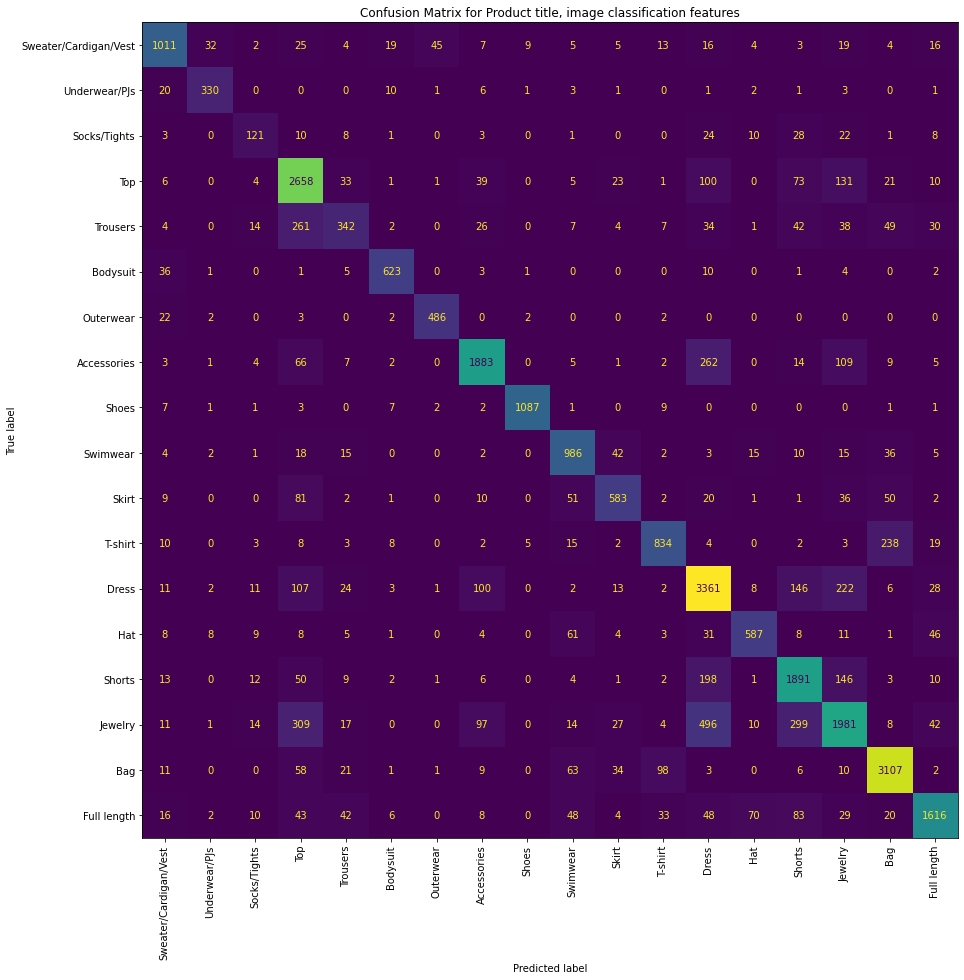

In [178]:
# Display confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
display = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred_knn,
        display_labels=product_cat,
        ax=ax, colorbar=False,
#         cmap=plt.cm.Blues,
        xticks_rotation='vertical')
ax.set_title("Confusion Matrix for Product title, image classification features")

The performance of classes Top, Accessories, T-shirt, Dress, Shorts, Jewelry are worse than the Random Forest model. 
Underwear/PJs performed better, and the model doesn't seem confuse the product for T-shirts or Trousers, which is understandable from looking at the image alone. 

The KNN model also takes the longest out of the 3 models to run. 


## Conclusion

Overall, these classifications models (SGDC, Random Forest, KNN) performed similarly and well enough for the large classes. There is some confusion between categories that are similar or subsets of each other (Accessories and Jewelry, Tops and T-shirt) which is understandable. 

The models even highlighted data that had been misclassified in the original dataset, and I took this opportunity to spot check the rows where the model had the highest predicted confidence scores but the predicted label was different to the true label. 

In the next notebook, I will investigate using deep learning architecture, and compare the performance of the top 3 and worst 3 classes to the classification models in this notebook.